# TerraVector-Clust: Hierarchical Clustering for Global Geophysical Datasets

This notebook demonstrates the TerraVector-Clust method, a hierarchical clustering technique using the EVPT metric. It is applied to globally comprehensive datasets, such as ITRF2008 and ITRF2020 reference frames, as well as local datasets around Taiwan.
The notebook includes utility functions for geodesic calculations, Euler vector computations, and clustering evaluation. Ensure that you have the necessary datasets before running the demonstration.

## 1. Imports and Configurations

This section includes all the necessary libraries for the computations, plotting, and geospatial data handling used in the TerraVector-Clust method. Plotting configurations are also defined here.

In [ ]:
# Install pygmt if using Google Colab; if otherwise, please comment this cell out
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install pygmt

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...

Looking for: ['pygmt']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64   1%
conda-forge/noarch    ⣾  [+] 0.2s
conda-forge/linux-64   9%
conda-forge/noarch     2%[+] 0.3s
conda-forge/linux-64  22%
conda-forge/noarch    11%[+] 0.4s
conda-forge/linux-64  30%
conda-forge/noarch    48%[+] 0.5s
conda-forge/linux-64  38%
conda-forge/noarch    67%[+] 0.6s
conda-forge/linux-64  47%
conda-forge/noarch    87%[+] 0.7s
conda-forge/linux-64  55%
conda-forge/noarch    96%[+] 0.8s
conda-forge/linux-64  55%
conda-forge/noarch    96%conda-forge/noarch                                
[+] 0.9s
conda-forge/linux-64  60%[+] 1.0s
conda-forge/linux-64  67%[+] 1.1s
conda-forge/linux-64  76%[+] 1.2s
conda-forge/linux-64  92%[+] 1.3s
conda-forge/linux-64 100%[+] 1.4s
conda-forge/linux-64 

In [ ]:
# Mount Google Drive (if using Google Colab; if otherwise, please comment the following two lines out)
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Necessary imports
import numpy as np  # For numerical computations
import matplotlib.pyplot as plt  # For plotting
import matplotlib  # For controlling plot configurations
from scipy import linalg  # For linear algebra routines
import pandas as pd  # For data manipulation with dataframes
import random  # For generating random values
import math  # For mathematical functions
import matplotlib.gridspec as gridspec  # For customizing subplot layouts
import pygmt  # For working with geospatial data (GMT interface)
import scipy.cluster.hierarchy as shc  # For hierarchical clustering
from scipy.spatial.distance import squareform  # For distance matrix transformations
from scipy.cluster.hierarchy import fcluster  # For extracting clusters from hierarchical trees
import seaborn as sns  # For enhanced data visualization
import matplotlib.colors as mcolors  # For color maps
import matplotlib.ticker as ticker  # For controlling tick locators and formats
from sklearn.metrics.cluster import adjusted_rand_score  # For evaluating clustering similarity

# Configure fonts and plot appearance
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
matplotlib.rcParams['xtick.direction'] = 'out'  # X-axis ticks point outward
matplotlib.rcParams['ytick.direction'] = 'out'  # Y-axis ticks point outward
matplotlib.rcParams['lines.linewidth'] = 2  # Set default line width
matplotlib.rcParams['axes.xmargin'] = 0  # No margin on X-axis
matplotlib.rcParams['axes.ymargin'] = 0  # No margin on Y-axis

In [ ]:
FILEPATH = "/content/gdrive/My Drive/Geodeticclustering/code/"

## 2. Utility Functions

This section defines various utility functions used in the TerraVector-Clust method. These include functions for geodesic calculations, Euler pole translations, rotation matrices, and more. Detailed inline comments and docstrings are provided to explain the purpose of each function.

In [ ]:
#Required functions of our method
def geodesicpt(p_start,p_end,v):
  """
    Parallel translation via "geodesic" of tangent vector v at p to q).

    Parameters:
    - p_start: Start point (numpy array of [x,y,z])
    - p_end: End point (numpy array of [x,y,z])
    - v: Velocity vector at start point (numpy array of [x,y,z])

    Returns:
    - numpy array: Velocity vector at end point
  """

  # Calculate 3 othogonal vectors e1 , e2 , e3
  e1 = p_start
  e3 = np.cross(p_start, p_end)
  e3 /= np.linalg.norm(e3)
  e2 = np.cross(e3, e1)

  # Representation
  v_a = v.dot(e2)
  v_b = v.dot(e3)
  corresp_t= np.arctan2(e2.dot(p_end), e1.dot(p_end))

  gamma_t = np.cos(corresp_t)*e1 + np.sin(corresp_t)*e2
  gamma_t_v = v_a * np.cos(corresp_t) *e2 - v_a * np.sin(corresp_t) * e1 + v_b * e3

  return gamma_t_v


#Translation of velocity along the rotational motion)
def Eulerpole_translation(p_start,p_end,omega,v):
  #=============================================
  # Input:
  ##  Start point                    : p_start: array of (x,y,z)
  ##  End point                      : p_end  : array of (x,y,z)
  ##  Euler pole                     : omega  : array of (x,y,z)
  ##  Velocity vector at start point : v      : array of (x,y,z)
  # Output:
  ##  Velocity vector at end point   : gamma_t_v : array of (x,y,z)
  #=============================================

  e_omega_1_start = p_start
  e_omega_2_start = np.cross(omega,e_omega_1_start) #tangent
  e_omega_2_start = e_omega_2_start / np.sqrt(sum(e_omega_2_start**2)) #tangent
  e_omega_3_start = np.cross(e_omega_2_start,e_omega_1_start) #tangent

  v_a = v.dot(e_omega_2_start)
  v_b = v.dot(e_omega_3_start)
  amplituderatio = (np.sqrt(np.sum(np.cross(omega,p_end)**2)))/(np.sqrt(np.sum(np.cross(omega,p_start)**2))+0.000001)

  e_omega_1_end = p_end
  e_omega_2_end = np.cross(omega,e_omega_1_end) # tangent
  e_omega_2_end = e_omega_2_end / np.sqrt(sum(e_omega_2_end**2)) # tangent
  e_omega_3_end = np.cross(e_omega_2_end,e_omega_1_end)#tangent
  return (amplituderatio*v_a * e_omega_2_end) + (amplituderatio*v_b * e_omega_3_end)


#Create rotation matrix
def rotation_aroundEulerpole(omega,angle):
  #=============================================
  # Input:
  ##  Euler pole                              : omega  : array of (x,y,z)
  ##  Angle according to the right hand rule  : angle  : scalar
  # Output:
  ##  Rotation matrix
  #=============================================

  #Using Rodrigues' rotation formula
  nx = omega[0]
  ny = omega[1]
  nz = omega[2]
  K = np.array([[ 0, -nz, ny],[nz,0,-nx],[-ny,nx,0]])
  I = np.identity(3)
  return I+np.sin(angle)*K+(1-np.cos(angle))*K@K


#Matrix representing the cross product
def create_skewsymmetric(vec):
  #=============================================
  # Input:
  ##  vector  : vec  : array of (x,y,z)
  # Output:
  ##  matrix corresponding to the cross product with respect to vec
  #=============================================
  R = np.array([ [0 , vec[2], -vec[1]], [ -vec[2], 0, vec[0]], [ vec[1], -vec[0], 0 ] ])
  return R


#Calculate the Euler vector using two points in the tangent bundle (pair of position and velocity vector)
def find_Eulervector(bundle_start,bundle_end):
  #Note: bundle is a (2,3)-array of [[location],[tangent vector]]
  #=============================================
  # Input:
  ##  bundle of the starting point : bundle_start
  ##  bundle of the end point      : bundle_end
  # Output:
  ##  Fitted Euler vector
  #=============================================

  p_start,v_start = bundle_start
  p_end, v_end    = bundle_end
  R_start = create_skewsymmetric(p_start)
  R_end = create_skewsymmetric(p_end)
  R_combined  = np.vstack((R_start,R_end))
  v_combined  = np.hstack((v_start,v_end))
  omega = linalg.pinv(R_combined) @ v_combined

  return omega

#Calculate bases of the tangent vector at (latitute, longitude)
def tangential_representation(lat,lon):
  #=============================================
  # Input:
  ##  latitude : lat
  ##  longitude: lon
  # Output:
  ##  3-D representation of the point and two orthogonal bases
  #=============================================
  x = np.cos(lat) * np.sin(lon)
  y = np.cos(lat) * np.cos(lon)
  z = np.sin(lat)
  point = np.array([x,y,z])

  e_vlat = np.array([ (-1)*np.sin(lat)*np.sin(lon),
                      (-1)*np.sin(lat)*np.cos(lon),
                      np.cos(lat)])

  e_vlon   = np.array([ np.cos(lat)*np.cos(lon),
                        (-1)*np.cos(lat)*np.sin(lon),
                      0])

  return point,e_vlat,e_vlon


#Calculate the mean of Euler vectors
def VMmean_omega(omegas):
  #=============================================
  # Input:
  ##  n Euler vectors : omegas : array of (n,3)
  # Output:
  ##  Mean of Euler vectors
  #=============================================
  num_omegas = omegas.shape[0]
  #Calculate Veronese-Whittney embedding
  S_omega=sum([np.outer(omegas[i,:]/np.sqrt(np.sum(omegas[i,:]**2)),omegas[i,:]/np.sqrt(np.sum(omegas[i,:]**2))) for i in range(num_omegas)])
  M_omega=linalg.eig(S_omega)[1][:,0]
  return M_omega


#Calculate the angular distant between Euler poles
def distance_betweenpoles(omega1,omega2):
  #=============================================
  # Input:
  ##  2 Euler vectors : omega1 , omega2 : array of [x,y,z] for each
  # Output:
  ##  Angular distance
  #=============================================
  tmp = np.cross(omega1,omega2)
  return np.sum(tmp**2)


#Calculate the dissimilarity defined by the residual by the two-point Euler vector estimation
def EVfit_distance(bundle_start,bundle_end):
  #Note: bundle is a (2,3)-array of [[location],[tangent vector]]
  #=============================================
  # Input:
  ##  2 bundles : bundle_start,bundle_end
  # Output:
  ##  Dissimilarity of two bundles defined by Euler vector estimation
  #=============================================
  if np.all(bundle_start==bundle_end):
    dist = 0.
  else:
    omega = find_Eulervector(bundle_start=bundle_start,bundle_end=bundle_end)
    res_start = np.sqrt(np.sum( ( bundle_start[1]-np.cross(omega,bundle_start[0]))**2))
    res_end = np.sqrt(np.sum( ( bundle_end[1]-np.cross(omega,bundle_end[0]))**2))
    dist = np.sqrt(res_start**2+res_end**2)
  return dist

#Calculate the dissimilarity defined by the residual by the parallel tranlation
def PTEuc_distance(bundle_start,bundle_end):
  #Note: bundle is a (2,3)-array of [[location],[tangent vector]]
  #=============================================
  # Input:
  ##  2 bundles : bundle_start,bundle_end
  # Output:
  ##  Dissimilarity of two bundles defined by the residual by the parallel tranlation
  #=============================================
  if np.all(bundle_start==bundle_end):
    dist = 0.
  else:
    gamma_t_v1 = geodesicpt(p_start=bundle_start[0],p_end=bundle_end[0],v=bundle_start[1])
    ret = np.sqrt(sum((gamma_t_v1 - bundle_end[1])**2))
  return ret

#Calculate the composite of Euler vector dissimilarity and parallel tranlation dissimilarity
def combinedEVPTfit_distance(bundle_start,bundle_end,alpha):
  #Note: bundle is a (2,3)-array of [[location],[tangent vector]]
  #=============================================
  # Input:
  ##  2 bundles : bundle_start,bundle_end
  ##  weight for the composition : alpha=[alpha1,alpha2]
  # Output:
  ##  Composite dissimilarity
  #=============================================
  if np.all(bundle_start==bundle_end):
    dist = 0.
  else:
    dist = alpha[0]*EVfit_distance(bundle_start,bundle_end)+alpha[1]*PTEuc_distance(bundle_start,bundle_end)
  return dist


def sorted_indices(arr):
    return np.argsort(arr)
def entropy(p):
  if (p==0.) or (p==1.):
    return 0
  else:
    return -p * np.log2(p) - (1-p)*np.log2(1-p)
def color_func(x):
    return 'gray'

## 3. TerraVector-Clust Method Explanation

The TerraVector-Clust method is a hierarchical clustering technique using a hybrid metric (EVPT metric):
\begin{align}
    d_{\mathrm{EVPT}}(\{\mathbf{v}_{P},\mathbf{r}_{P}\}\,,\,\{\mathbf{v}_{Q},\mathbf{r}_{Q}\})
    = \alpha_{1} d_{\mathrm{PT}}(\{\mathbf{v}_{P},P\}\,,\,\{\mathbf{v}_{Q},Q\}) + \alpha_{2} d_{\mathrm{EV}}(\{\mathbf{v}_{P},P\}\,,\,\{\mathbf{v}_{Q},Q\}),
\end{align}
where $(\alpha_{1},\alpha_{2})$ is a weight vector. For more details, please refer to the associated manuscript.

## 4. Demonstration: Clustering with Global Datasets (ITRF2008 and ITRF2020)

In this section, we demonstrate the application of the TerraVector-Clust method on global datasets. The datasets used in this demonstration include the ITRF2008 and ITRF2020 reference frames, along with plate boundary information from Bird (2003). Please ensure you have the necessary datasets before running this section.

**References:**
- Altamimi, Z., Métivier, L., & Collilieux, X. (2012). ITRF2008 plate motion model. Journal of Geophysical Research: Solid Earth, 117 (B7).
- Altamimi, Z., Métivier, L., Rebischung, P., Collilieux, X., Chanard, K., & Barnéoud, J. (2023). ITRF2020 plate motion model. Geophysical Research Letters, 50 (24), e2023GL106373.
- Bird, P. (2003), An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027.

#Demo for global datasets (ITRF2008 and ITRF2020)

To examine our proposed method (TerraVector-Clust)  at a global scale, we apply it to the globally comprehensive dataset used in establishing the ITRF2008 and ITRF2020 reference frames (Altamimi et al., 2008; Altamimi et al. 2023)

This demo uses the datasets provided by Altamimi et al. (2008, 2023) and the information on the plate boundaries by Bird (2003)
(see also https://github.com/fraxen/tectonicplates?tab=readme-ov-file)

- Altamimi, Z., Métivier, L., & Collilieux, X. (2012). ITRF2008 plate motion model. Journal of Geophysical Research: Solid Earth, 117 (B7).
- Altamimi, Z., Métivier, L., Rebischung, P., Collilieux, X., Chanard, K., & Barnéoud, J. (2023). Itrf2020 plate motion model. Geophysical Research Letters, 50 (24), e2023GL106373.
- Bird, P. (2003), An updated digital model of plate boundaries, Geochemistry Geophysics Geosystems, 4(3), 1027.

# ITRF2008

**Data registration**

In [ ]:
#Data registration

#Loading Data
ITRF2008_vec=pd.read_csv(FILEPATH+'ITRF2008.csv')
Platename=ITRF2008_vec["PlateName"].unique()
num_of_stations_ITRF2008 = len(ITRF2008_vec["lat"])

#Identifying Type
ITRF2008_vec["PlateName"]=ITRF2008_vec["PlateName"].astype('str')
ITRF2008_vec["lon"]=ITRF2008_vec["lon"].astype('float64')
ITRF2008_vec["lat"]=ITRF2008_vec["lat"].astype('float64')
ITRF2008_vec["Eastward[mm/a]"]=ITRF2008_vec["Eastward[mm/a]"].astype('float64')
ITRF2008_vec["Northward[mm/a]"]=ITRF2008_vec["Northward[mm/a]"].astype('float64')
ITRF2008_vec["Error_east"]=ITRF2008_vec["Error_east"].astype('float64')
ITRF2008_vec["Error_north"]=ITRF2008_vec["Error_north"].astype('float64')
ITRF2008_vec["Error_east2"]=ITRF2008_vec["Error_east2"].astype('float64')
ITRF2008_vec["Error_north1"]=ITRF2008_vec["Error_north1"].astype('float64')

#Pre-registration
ITRF2008_vec["x"]=0.
ITRF2008_vec["y"]=0.
ITRF2008_vec["z"]=0.
ITRF2008_vec["v_x"]=0.
ITRF2008_vec["v_y"]=0.
ITRF2008_vec["v_z"]=0.
ITRF2008_vec["PlateCap"]="A"
ITRF2008_vec["v_lat_sd_x"]=0.
ITRF2008_vec["v_lat_sd_y"]=0.
ITRF2008_vec["v_lat_sd_z"]=0.
ITRF2008_vec["v_lon_sd_x"]=0.
ITRF2008_vec["v_lon_sd_y"]=0.
ITRF2008_vec["v_lon_sd_z"]=0.

data_scaling=0.01

for i in range(num_of_stations_ITRF2008):
  lat = ITRF2008_vec["lat"][i]*(np.pi/180)
  lon = ITRF2008_vec["lon"][i]*(np.pi/180)
  tangentrep = tangential_representation(lat,lon)
  x,y,z=tangentrep[0]
  e_vlat=tangentrep[1]
  e_vlon=tangentrep[2]
  vlat = data_scaling*(ITRF2008_vec["Northward[mm/a]"][i])* e_vlat
  vlon = data_scaling*(ITRF2008_vec["Eastward[mm/a]"][i]) * e_vlon
  vlat_sd = data_scaling*(ITRF2008_vec["Error_north"][i])* e_vlat
  vlon_sd = data_scaling*(ITRF2008_vec["Error_east"][i]) * e_vlon
  v       = vlat+vlon

  ITRF2008_vec.at[i,"x"]=x
  ITRF2008_vec.at[i,"y"]=y
  ITRF2008_vec.at[i,"z"]=z
  ITRF2008_vec.at[i,"v_x"]=v[0]
  ITRF2008_vec.at[i,"v_y"]=v[1]
  ITRF2008_vec.at[i,"v_z"]=v[2]
  ITRF2008_vec.at[i,"v_z"]=v[2]
  ITRF2008_vec.at[i,"PlateCap"]=ITRF2008_vec.at[i,"PlateName"][0:3]


#Registaration of 3D data
bundle_array_ITRF2008 = np.array([
    (ITRF2008_vec.loc[i,["x","y","z"]].astype(float).values,ITRF2008_vec.loc[i,["v_x","v_y","v_z"]].astype(float).values)
                                for i in range(num_of_stations_ITRF2008)])


#Registration of 2D data
vel_array_ITRF2008 = np.array([
    np.hstack((ITRF2008_vec.loc[i,["x","y","z"]].astype(float).values,
                             ITRF2008_vec.loc[i,["Eastward[mm/a]","Northward[mm/a]"]].astype(float).values))
                          for i in range(num_of_stations_ITRF2008)])

In [ ]:
#Information of Plate boundaries

knownborders_list = []
with open(FILEPATH+"PB2002_boundaries.dig.txt") as f:
    for line in f.readlines():
        line = line.rstrip()
        if line[0]==" ":
          knownborders_list.append(list(map(float, line.split(","))))

knownborders_array=np.array(knownborders_list)

**Similarity metric computation**

In [ ]:
#Calculating EVPT metrics for all pairs of cites
#alphaparams is a weight vector
alphaparams=np.array([1.,1.])


EVPTfit_distmat_ITRF2008 = np.zeros(num_of_stations_ITRF2008*num_of_stations_ITRF2008).reshape((num_of_stations_ITRF2008,num_of_stations_ITRF2008))
EVfit_distmat_ITRF2008 = np.zeros(num_of_stations_ITRF2008*num_of_stations_ITRF2008).reshape((num_of_stations_ITRF2008,num_of_stations_ITRF2008))
PTEuc_distmat_ITRF2008 = np.zeros(num_of_stations_ITRF2008*num_of_stations_ITRF2008).reshape((num_of_stations_ITRF2008,num_of_stations_ITRF2008))
EVPTfit_list = np.zeros(num_of_stations_ITRF2008*num_of_stations_ITRF2008*9).reshape((num_of_stations_ITRF2008,num_of_stations_ITRF2008,9))

for i in range(num_of_stations_ITRF2008):
  for j in range(i+1,num_of_stations_ITRF2008):
    EVPTfit_distmat_ITRF2008[i,j]=combinedEVPTfit_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j],alpha=alphaparams)
    EVPTfit_distmat_ITRF2008[j,i]=combinedEVPTfit_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j],alpha=alphaparams)

    EVfit_distmat_ITRF2008[i,j]=EVfit_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j])
    EVfit_distmat_ITRF2008[j,i]=EVfit_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j])

    PTEuc_distmat_ITRF2008[i,j]=PTEuc_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j])
    PTEuc_distmat_ITRF2008[j,i]=PTEuc_distance(bundle_start=bundle_array_ITRF2008[i],bundle_end=bundle_array_ITRF2008[j])

Vel_distmat_ITRF2008 = np.zeros(num_of_stations_ITRF2008*num_of_stations_ITRF2008).reshape((num_of_stations_ITRF2008,num_of_stations_ITRF2008))
for i in range(num_of_stations_ITRF2008):
  for j in range(i+1,num_of_stations_ITRF2008):
    Vel_distmat_ITRF2008[i,j]=np.sqrt(np.sum((vel_array_ITRF2008[i][[3,4]]-vel_array_ITRF2008[j][[3,4]])**2))
    Vel_distmat_ITRF2008[j,i]=np.sqrt(np.sum((vel_array_ITRF2008[i][[3,4]]-vel_array_ITRF2008[j][[3,4]])**2))

**Hierarchical agglomerative clustering**

In [ ]:
#Select linkage method among average, single, complete
method="average"
#Select similarity among PT, EV, EVPT
distchange="EVPT"

if distchange=="EVPT":
  pdistform_ITRF2008 = squareform(EVPTfit_distmat_ITRF2008)
elif distchange=="PT":
  pdistform_ITRF2008 = squareform(PTEuc_distmat_ITRF2008)
elif distchange=="EV":
  pdistform_ITRF2008 = squareform(EVfit_distmat_ITRF2008)

HAC_ITRF2008 = shc.linkage(pdistform_ITRF2008,method=method)

**Dendrogram of the result**

Text(0, 0.5, 'EVPT metric value')

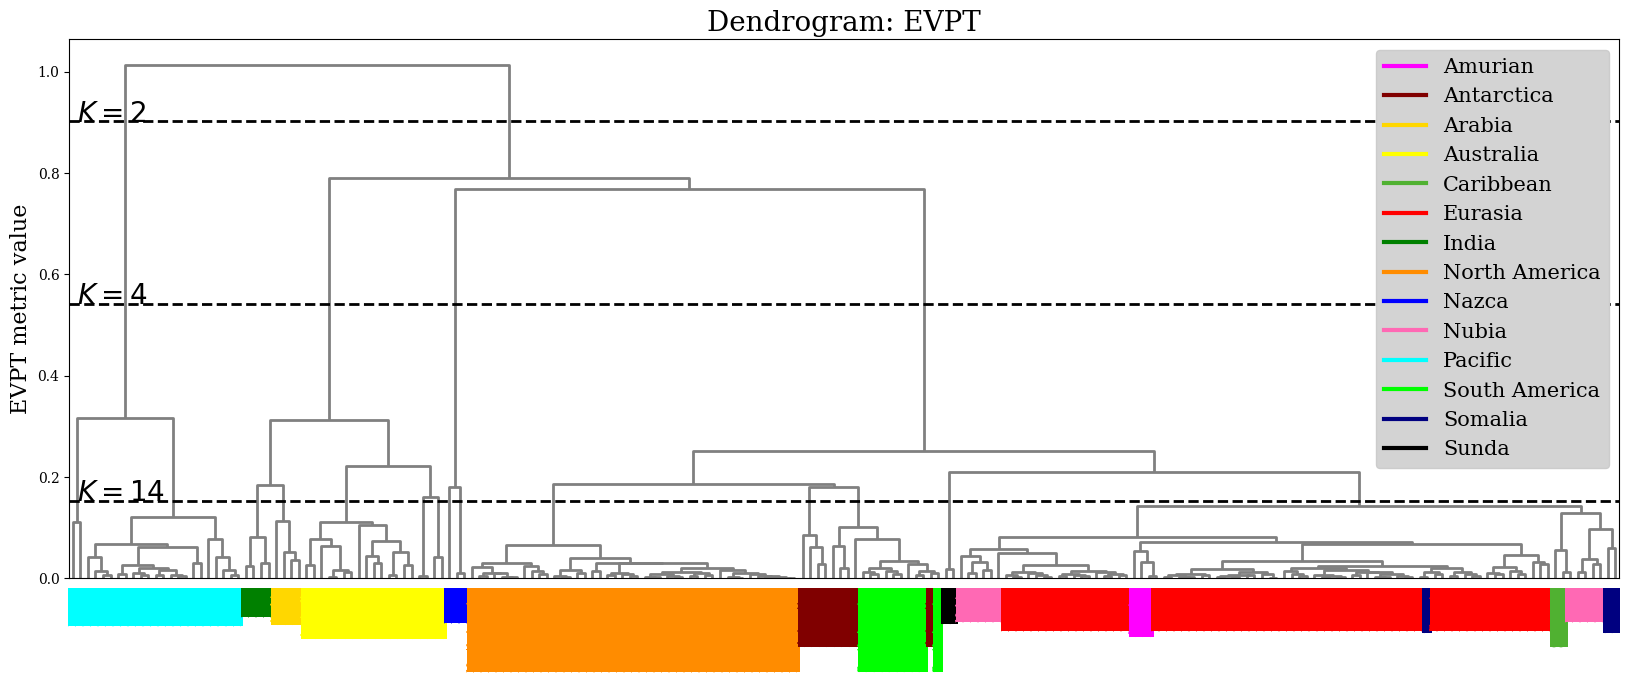

In [ ]:
#Colorlist for plot
colorlist_ITRF2008=['#ff00ff','#800000','#ffd700','#ffff00','#50b131','#ff0000','#008000','#ff8c00','#0000ff','#ff69b4','#00ffff','#00ff00','#000080','#000000']

#Plot dendrogram
fig, ax = plt.subplots(figsize=(20, 7))
dn = shc.dendrogram(HAC_ITRF2008,orientation='top',labels=list(ITRF2008_vec["PlateName"]),
                    leaf_font_size=8,color_threshold=100,link_color_func=color_func)
for t in ax.get_xticklabels():
    txt = t.get_text()
    t.set_color(colorlist_ITRF2008[np.where(Platename==txt)[0][0]])
    t.set_bbox(dict(facecolor=colorlist_ITRF2008[np.where(Platename==txt)[0][0]],boxstyle='square,pad=0.0', edgecolor='none', alpha=1.0))
for p in Platename:
  plt.plot(0,0,marker='o',markersize=0,color=colorlist_ITRF2008[np.where(Platename==p)[0][0]],label=p)
legend = plt.legend(fontsize=15,facecolor='lightgray',framealpha=1.0)
for handle in legend.legend_handles:
    handle.set_linewidth(3.0)
plt.title("Dendrogram: "+distchange,fontsize=20)

#get height for K=2
K=2
height_2=(HAC_ITRF2008[:,2][-K]+HAC_ITRF2008[:,2][-(K-1)])/2
#get height for K=4
K=4
height_4=(HAC_ITRF2008[:,2][-K]+HAC_ITRF2008[:,2][-(K-1)])/2
#get height for K=14
K=14
height_14=(HAC_ITRF2008[:,2][-K]+HAC_ITRF2008[:,2][-(K-1)])/2
ax.axhline(y=height_2, color='k', linestyle='--')
ax.text(x=10,y=height_2,s=r"$K=2$",fontsize=20)
ax.axhline(y=height_4, color='k', linestyle='--')
ax.text(x=10,y=height_4,s=r"$K=4$",fontsize=20)
ax.axhline(y=height_14, color='k', linestyle='--')
ax.text(x=10,y=height_14,s=r"$K=14$",fontsize=20)
ax.set_ylabel(distchange+" metric value",fontsize=16)


**Map view of the clustering result with given number of clusters**



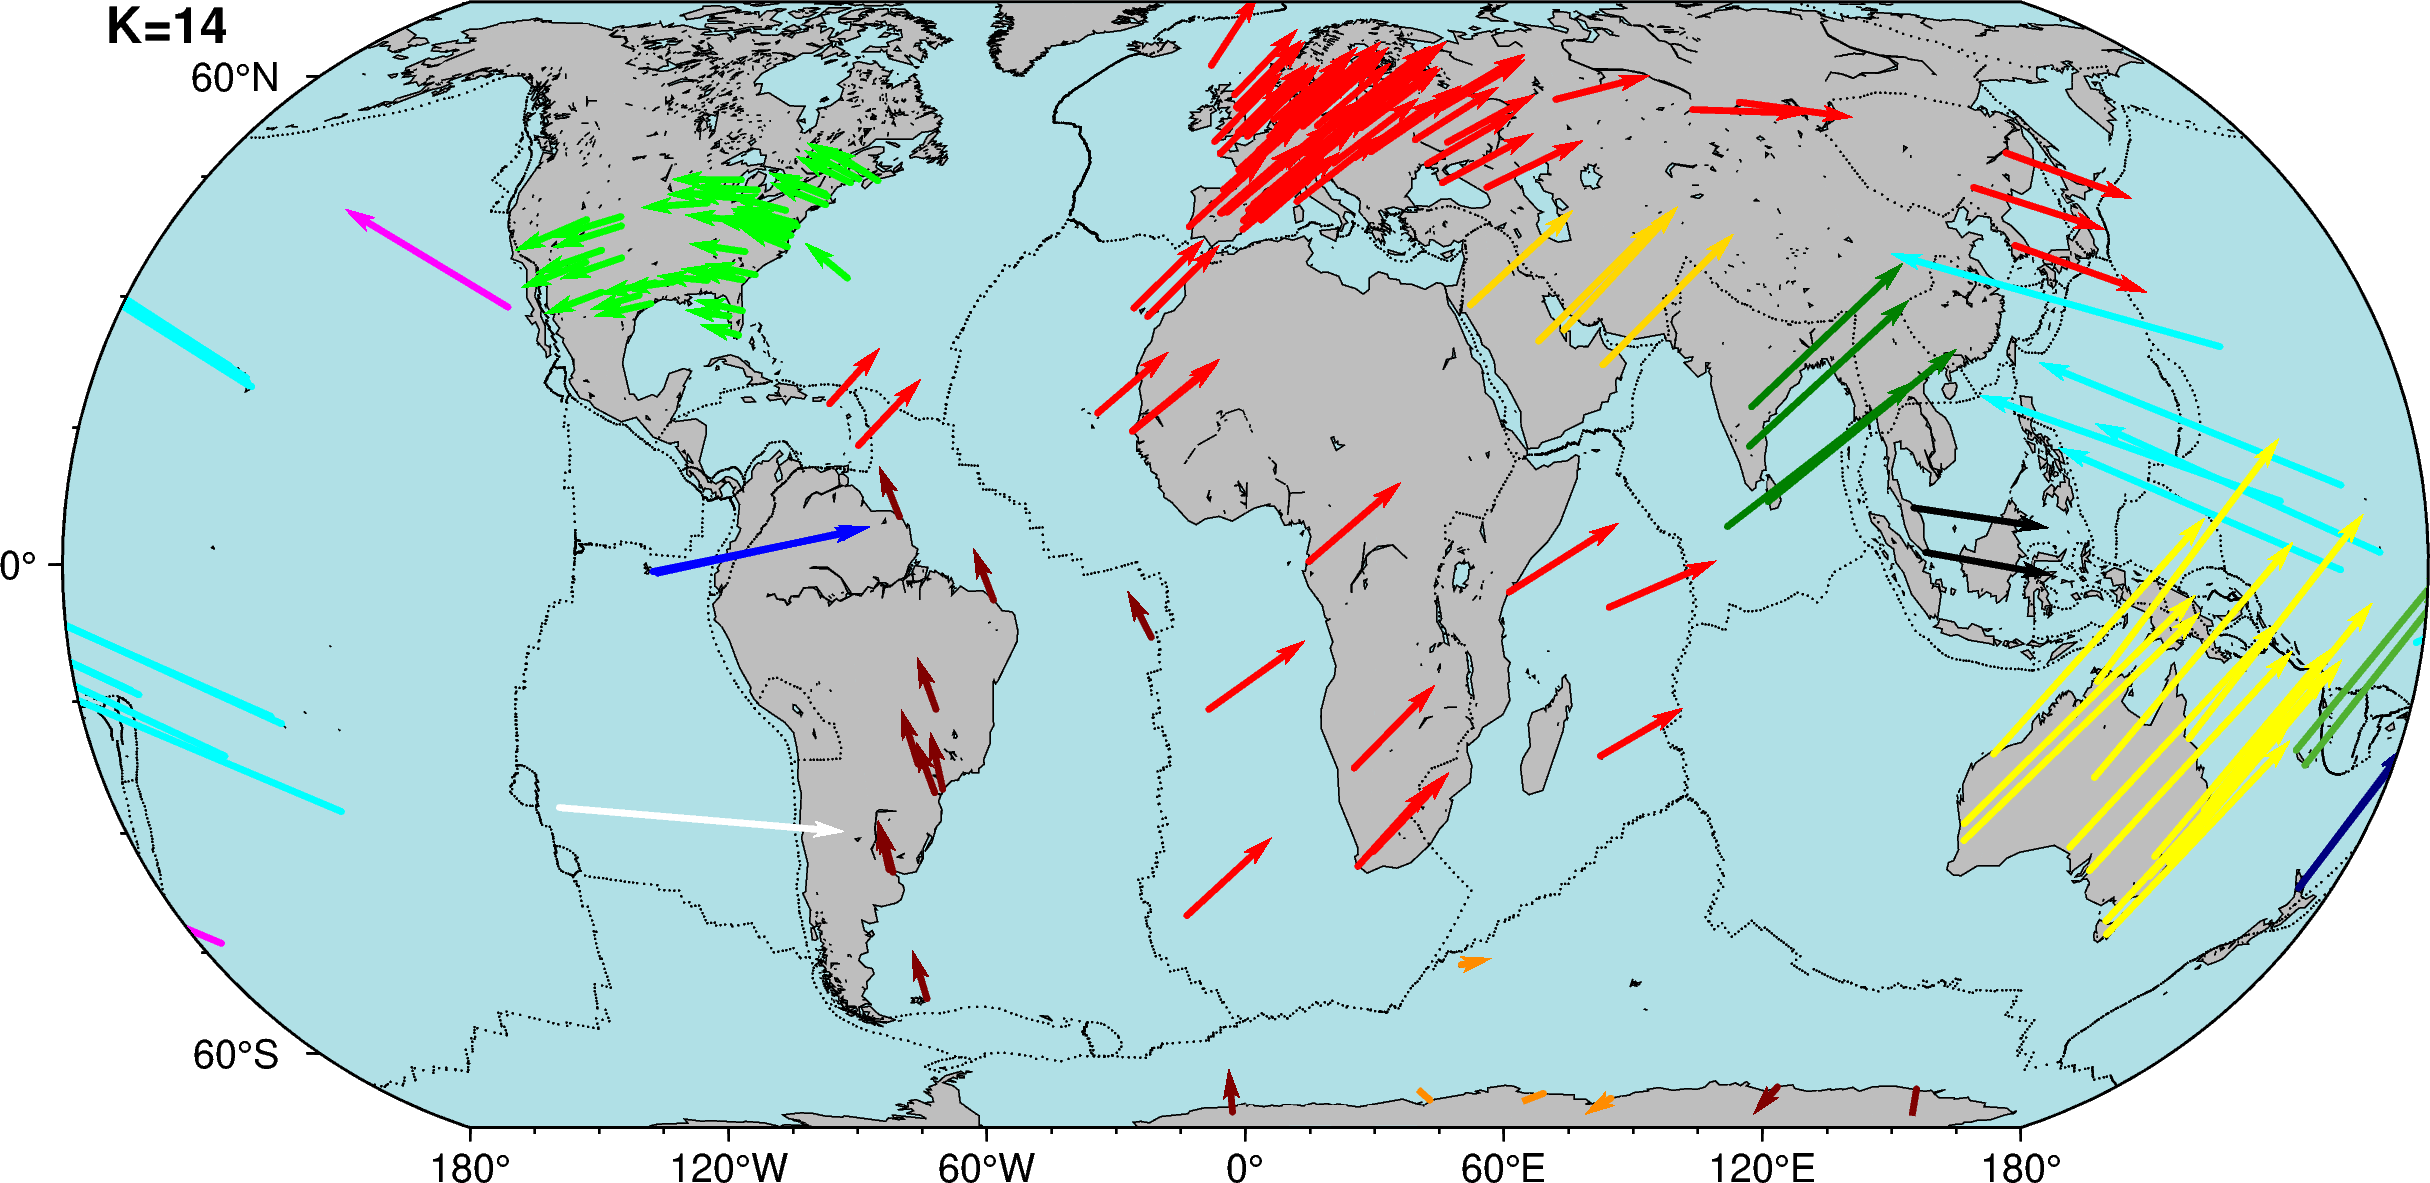

In [ ]:
#================================================================================
#Clustering result for given K
#Change K
K=14

clusters = fcluster(HAC_ITRF2008, K, criterion='maxclust')
color_pal = ['#ff00ff','#00ffff','#008000','#ffd700','#ffff00','#000080','#50b131','#0000ff','#ffffff','#00ff00','#ff8c00','#800000','#000000','#ff0000']

scale_p = 1.75
#================================================================================
#Information for plotting
df_K = pd.DataFrame(
    data={
        "x": ITRF2008_vec["lon"],
        "y": ITRF2008_vec["lat"],
        "east_velocity": scale_p*ITRF2008_vec["Eastward[mm/a]"],
        "north_velocity": scale_p*ITRF2008_vec["Northward[mm/a]"],
        "east_sigma": 0,
        "north_sigma": 0,
        "correlation_EN": 0,
        "SITE": clusters
    }
)
#================================================================================


#================================================================================
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", frame=True,zsize=20)

fig.coast(land="grey", water="powderblue",
  shorelines=True)


fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)

for i in range(num_of_stations_ITRF2008):
  fig.plot(x=ITRF2008_vec["lon"][i], y=ITRF2008_vec["lat"][i],
           style="c0.05c",fill=color_pal[(clusters[i]-1)])

for k in range(1,K+1):
  fig.velo(data=df_K[df_K["SITE"]==k],pen="1.5p,"+color_pal[k-1],
           vector="0.25c+p1p,"+color_pal[k-1]+"+e+g"+color_pal[k-1],spec="e0.02/0.05/0.1")
fig.text(text=" K="+str(K)+"                                     ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

**Matrix representation of the similarity metric**

Text(0.5, 1.0, 'EVPT similarity matrix')

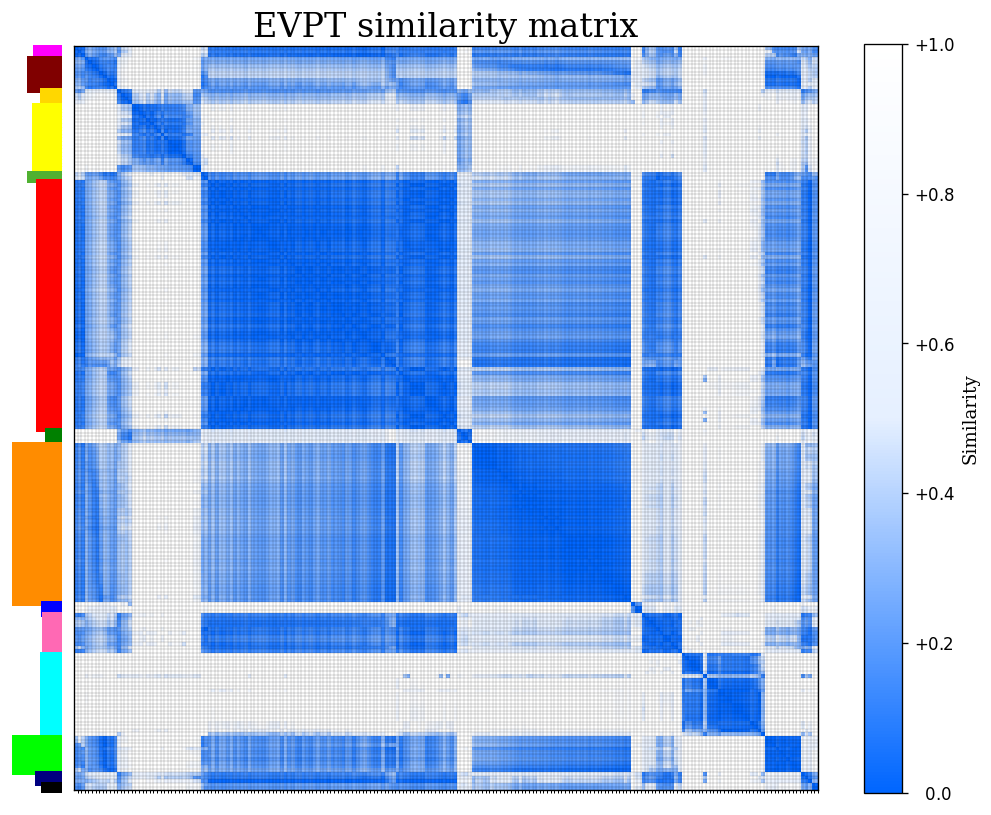

In [ ]:
#===================================================
distchange="EVPT"

if distchange=="EVPT":
  scaling = np.exp(EVPTfit_distmat_ITRF2008)-1
elif distchange=="PT":
  scaling = np.exp(PTEuc_distmat_ITRF2008)-1
elif distchange=="EV":
  scaling = np.exp(EVfit_distmat_ITRF2008)-1
elif distchange=="Vel":
  scaling = np.exp(0.01*Vel_distmat_ITRF2008)-1
#===================================================

fig, ax = plt.subplots(figsize=(10,10),dpi=120)


#==================================================================================
#Color map
cl = list()
cl.append( ( 0.00, matplotlib.colors.hsv_to_rgb((0.6, 1.  ,1))) )
cl.append( ( 0.50, matplotlib.colors.hsv_to_rgb((0.6, 0.1 ,1))) )
cl.append( ( 1.00, matplotlib.colors.hsv_to_rgb((0.0, 0.  ,1))) )
ccm = matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', cl)
#==================================================================================


plt.imshow(scaling ,interpolation='nearest',vmin=0,vmax=1,cmap=ccm)


#==================================================================================
#Setting label
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticks(range(num_of_stations_ITRF2008))
plt.gca().set_yticklabels(ITRF2008_vec["PlateName"],fontsize=4)
plt.tick_params(axis='both', which='both', top=False, left=False )
fmt = lambda p, pos=None : f'${p:+.1f}$' if p!=0 else '  $0.0$'
cb = plt.colorbar(format=ticker.FuncFormatter(fmt),shrink=0.81)
cb.set_label("Similarity", fontsize=11)
for t in ax.get_yticklabels():
    txt = t.get_text()
    t.set_color(colorlist_ITRF2008[np.where(Platename==txt)[0][0]])
    t.set_bbox(dict(facecolor=colorlist_ITRF2008[np.where(Platename==txt)[0][0]],
                    boxstyle='square,pad=0.0', edgecolor='none', alpha=1.0))
#==================================================================================



#==================================================================================
#Grid lines
plt.grid(True, which='both', color='black', linewidth=0.0, linestyle='-')
plt.gca().set_xticks(np.arange(scaling.shape[1])+0.5 , minor=True)
plt.gca().set_yticks(np.arange(scaling.shape[0])+0.5 , minor=True)
plt.gca().grid(True, which='minor', color='black', linewidth=0.1, linestyle='-')
#==================================================================================

plt.title(distchange+" similarity matrix",fontsize=20)

**Stability check**

In [ ]:
#===========================================
#Target number of clusters
K=14
clusters_K_ITRF2008=fcluster(HAC_ITRF2008, K, criterion='maxclust')
#===========================================


#===========================================
#Computation of leave-one-out probability and rand index

leaveout_result_ITRF2008 = []

for leaveout_index in range(num_of_stations_ITRF2008):
  safe_indices = [j for j in range(num_of_stations_ITRF2008) if j != leaveout_index ]
  pdistform_ITRF2008_loo = squareform(EVPTfit_distmat_ITRF2008[safe_indices][:,safe_indices])
  clusters_ITRF2008_loo = shc.linkage(pdistform_ITRF2008_loo,
            method=method)
  tmp=shc.fcluster(clusters_ITRF2008_loo, K, criterion='maxclust').tolist()
  tmp.insert(leaveout_index,K+10)
  leaveout_result_ITRF2008.append(np.array(tmp))


loo_adjusted_rand_score_ITRF2008 = []
for loo in range(num_of_stations_ITRF2008):
  exclude_indices = np.array([loo])
  mask = np.ones(len(leaveout_result_ITRF2008[loo]), dtype=bool)
  mask[exclude_indices] = False
  loo_adjusted_rand_score_ITRF2008.append(adjusted_rand_score(leaveout_result_ITRF2008[loo][mask],clusters_K_ITRF2008[mask]))

loo_probabilities_ITRF2008 = []
for loo in range(num_of_stations_ITRF2008):
  loo_probabilities_ITRF2008.append(np.array([ (1. == sum((leaveout_result_ITRF2008[loo][np.where(clusters_K_ITRF2008==k)[0]])/k)/len(np.where(clusters_K_ITRF2008==k)[0]))
                                    if (loo not in np.where(clusters_K_ITRF2008==k)[0]) else np.nan for k in range(1,K+1)]))
cluster_K_ITRF2008_loo_prob = np.nanmean(np.array(loo_probabilities_ITRF2008),axis=0)


#===========================================
#Computation of entropy

sorted_indices_byoriginal = np.hstack((tuple([np.where(clusters_K_ITRF2008==k)[0] for k in range(1,K+1)])))
Stability_tensor_ITRF2008=np.array([(1.0*np.array([[leaveout_result_ITRF2008[k][sorted_indices_byoriginal][i]==leaveout_result_ITRF2008[k][sorted_indices_byoriginal][j]
                                                  for i in range(num_of_stations_ITRF2008)] for j in range(num_of_stations_ITRF2008)])) for k in range(num_of_stations_ITRF2008)])
Rij_ITRF2008=Stability_tensor_ITRF2008.mean(axis=0)


entropy_ITRF2008=np.array([[entropy(Rij_ITRF2008[i,j]) for i in range(num_of_stations_ITRF2008)] for j in range(num_of_stations_ITRF2008)])
entropy_ITRF2008_stationwise=entropy_ITRF2008.mean(axis=0)

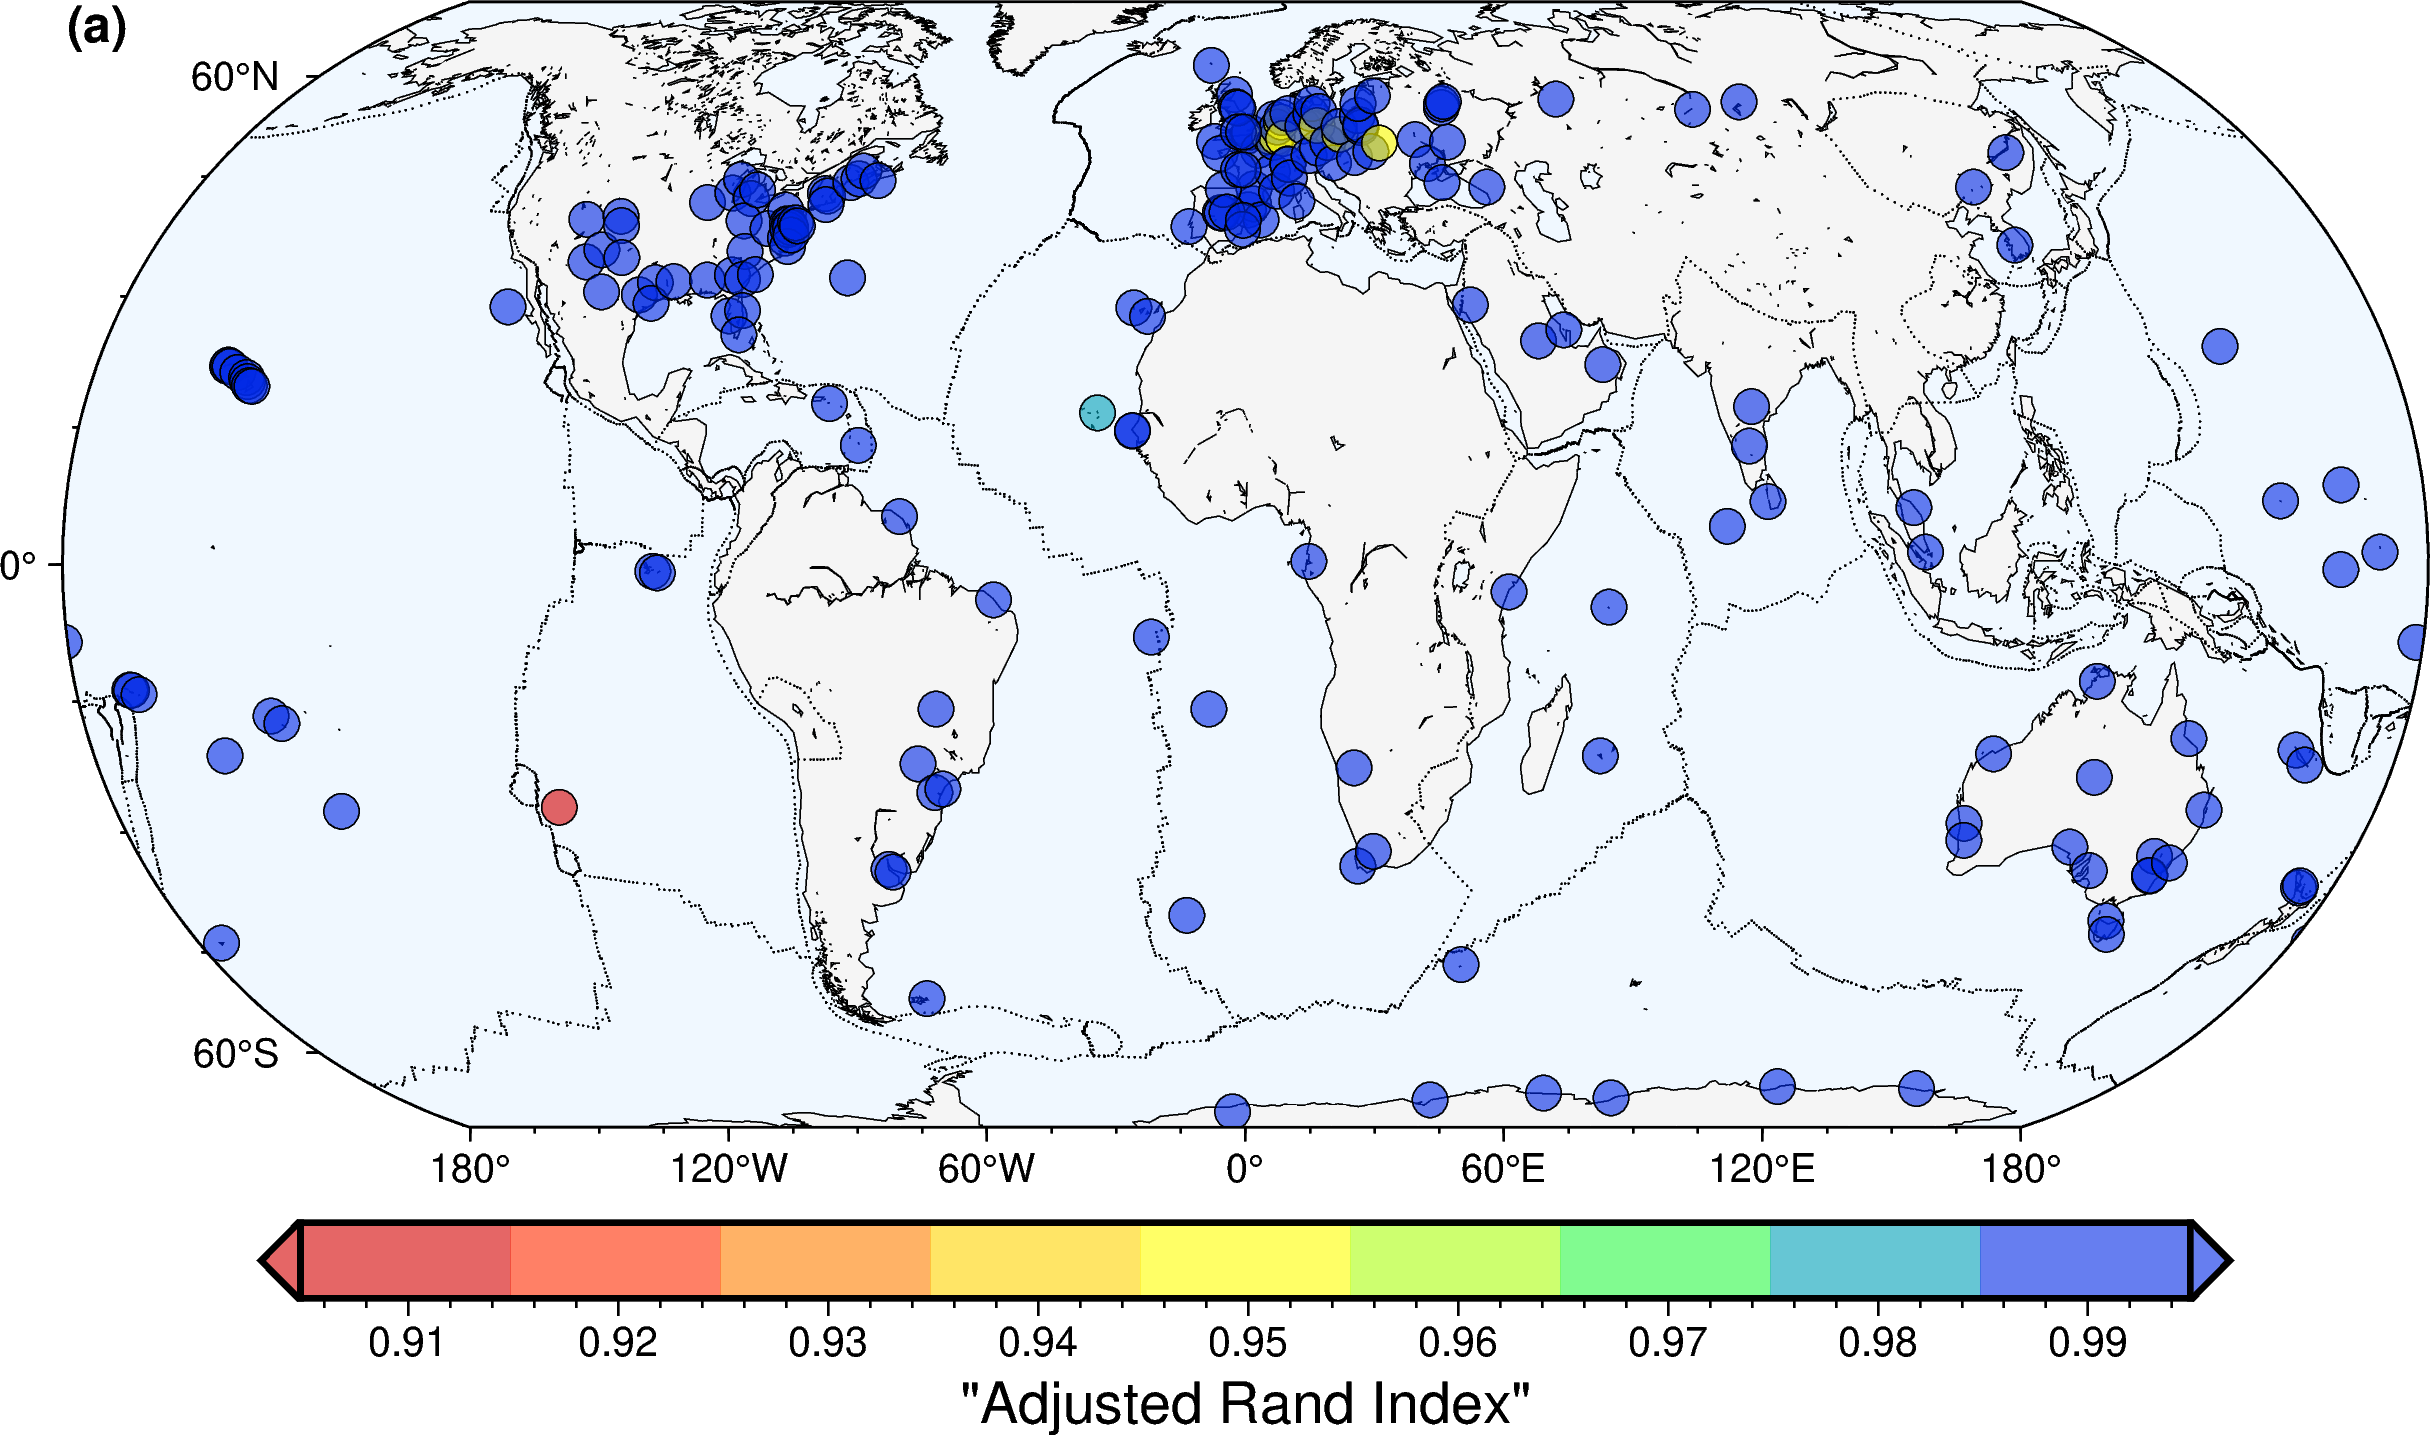

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(loo_adjusted_rand_score_ITRF2008), max(loo_adjusted_rand_score_ITRF2008), 0.01],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2008):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2008_vec["lon"][i],
        y=ITRF2008_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=loo_adjusted_rand_score_ITRF2008[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Adjusted Rand Index"'],
)


fig.text(text="(a)                                              ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

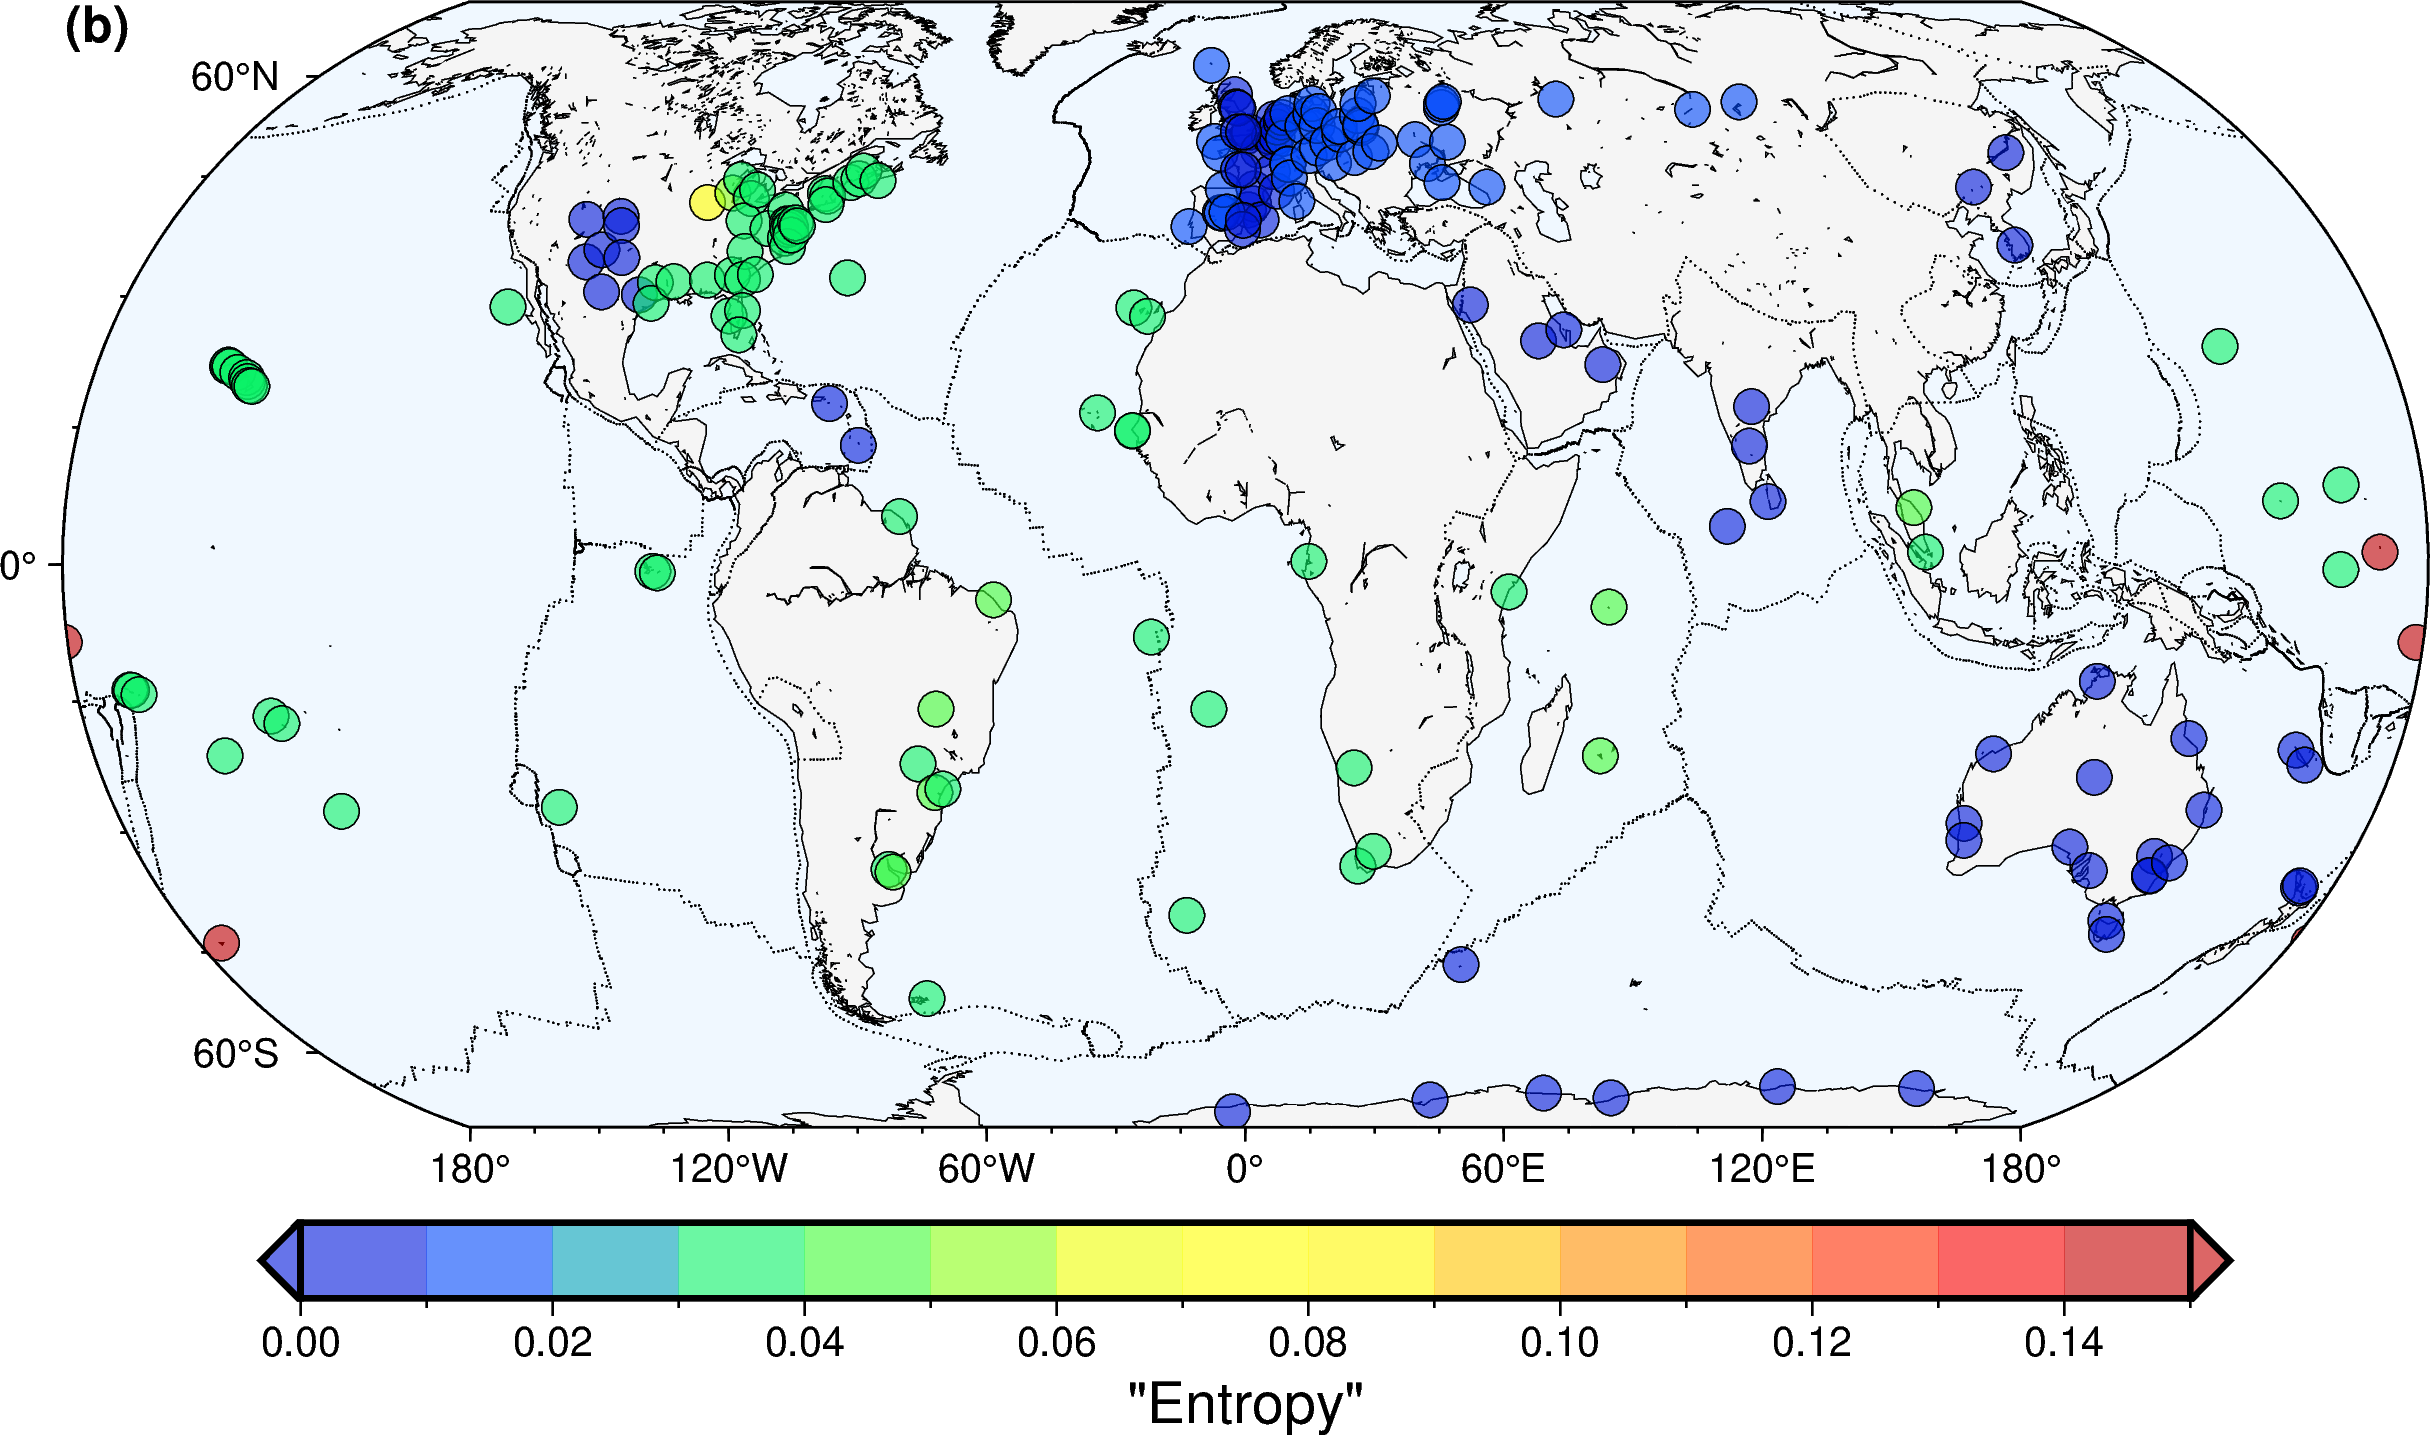

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis', reverse = True,
    series=[min(entropy_ITRF2008_stationwise), max(entropy_ITRF2008_stationwise), 0.01],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2008):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2008_vec["lon"][i],
        y=ITRF2008_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=entropy_ITRF2008_stationwise[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Entropy"'],
)


fig.text(text="(b)                                              ", x=-180, y=70, font="12p,Helvetica-Bold,black")
fig.show(width=1000)

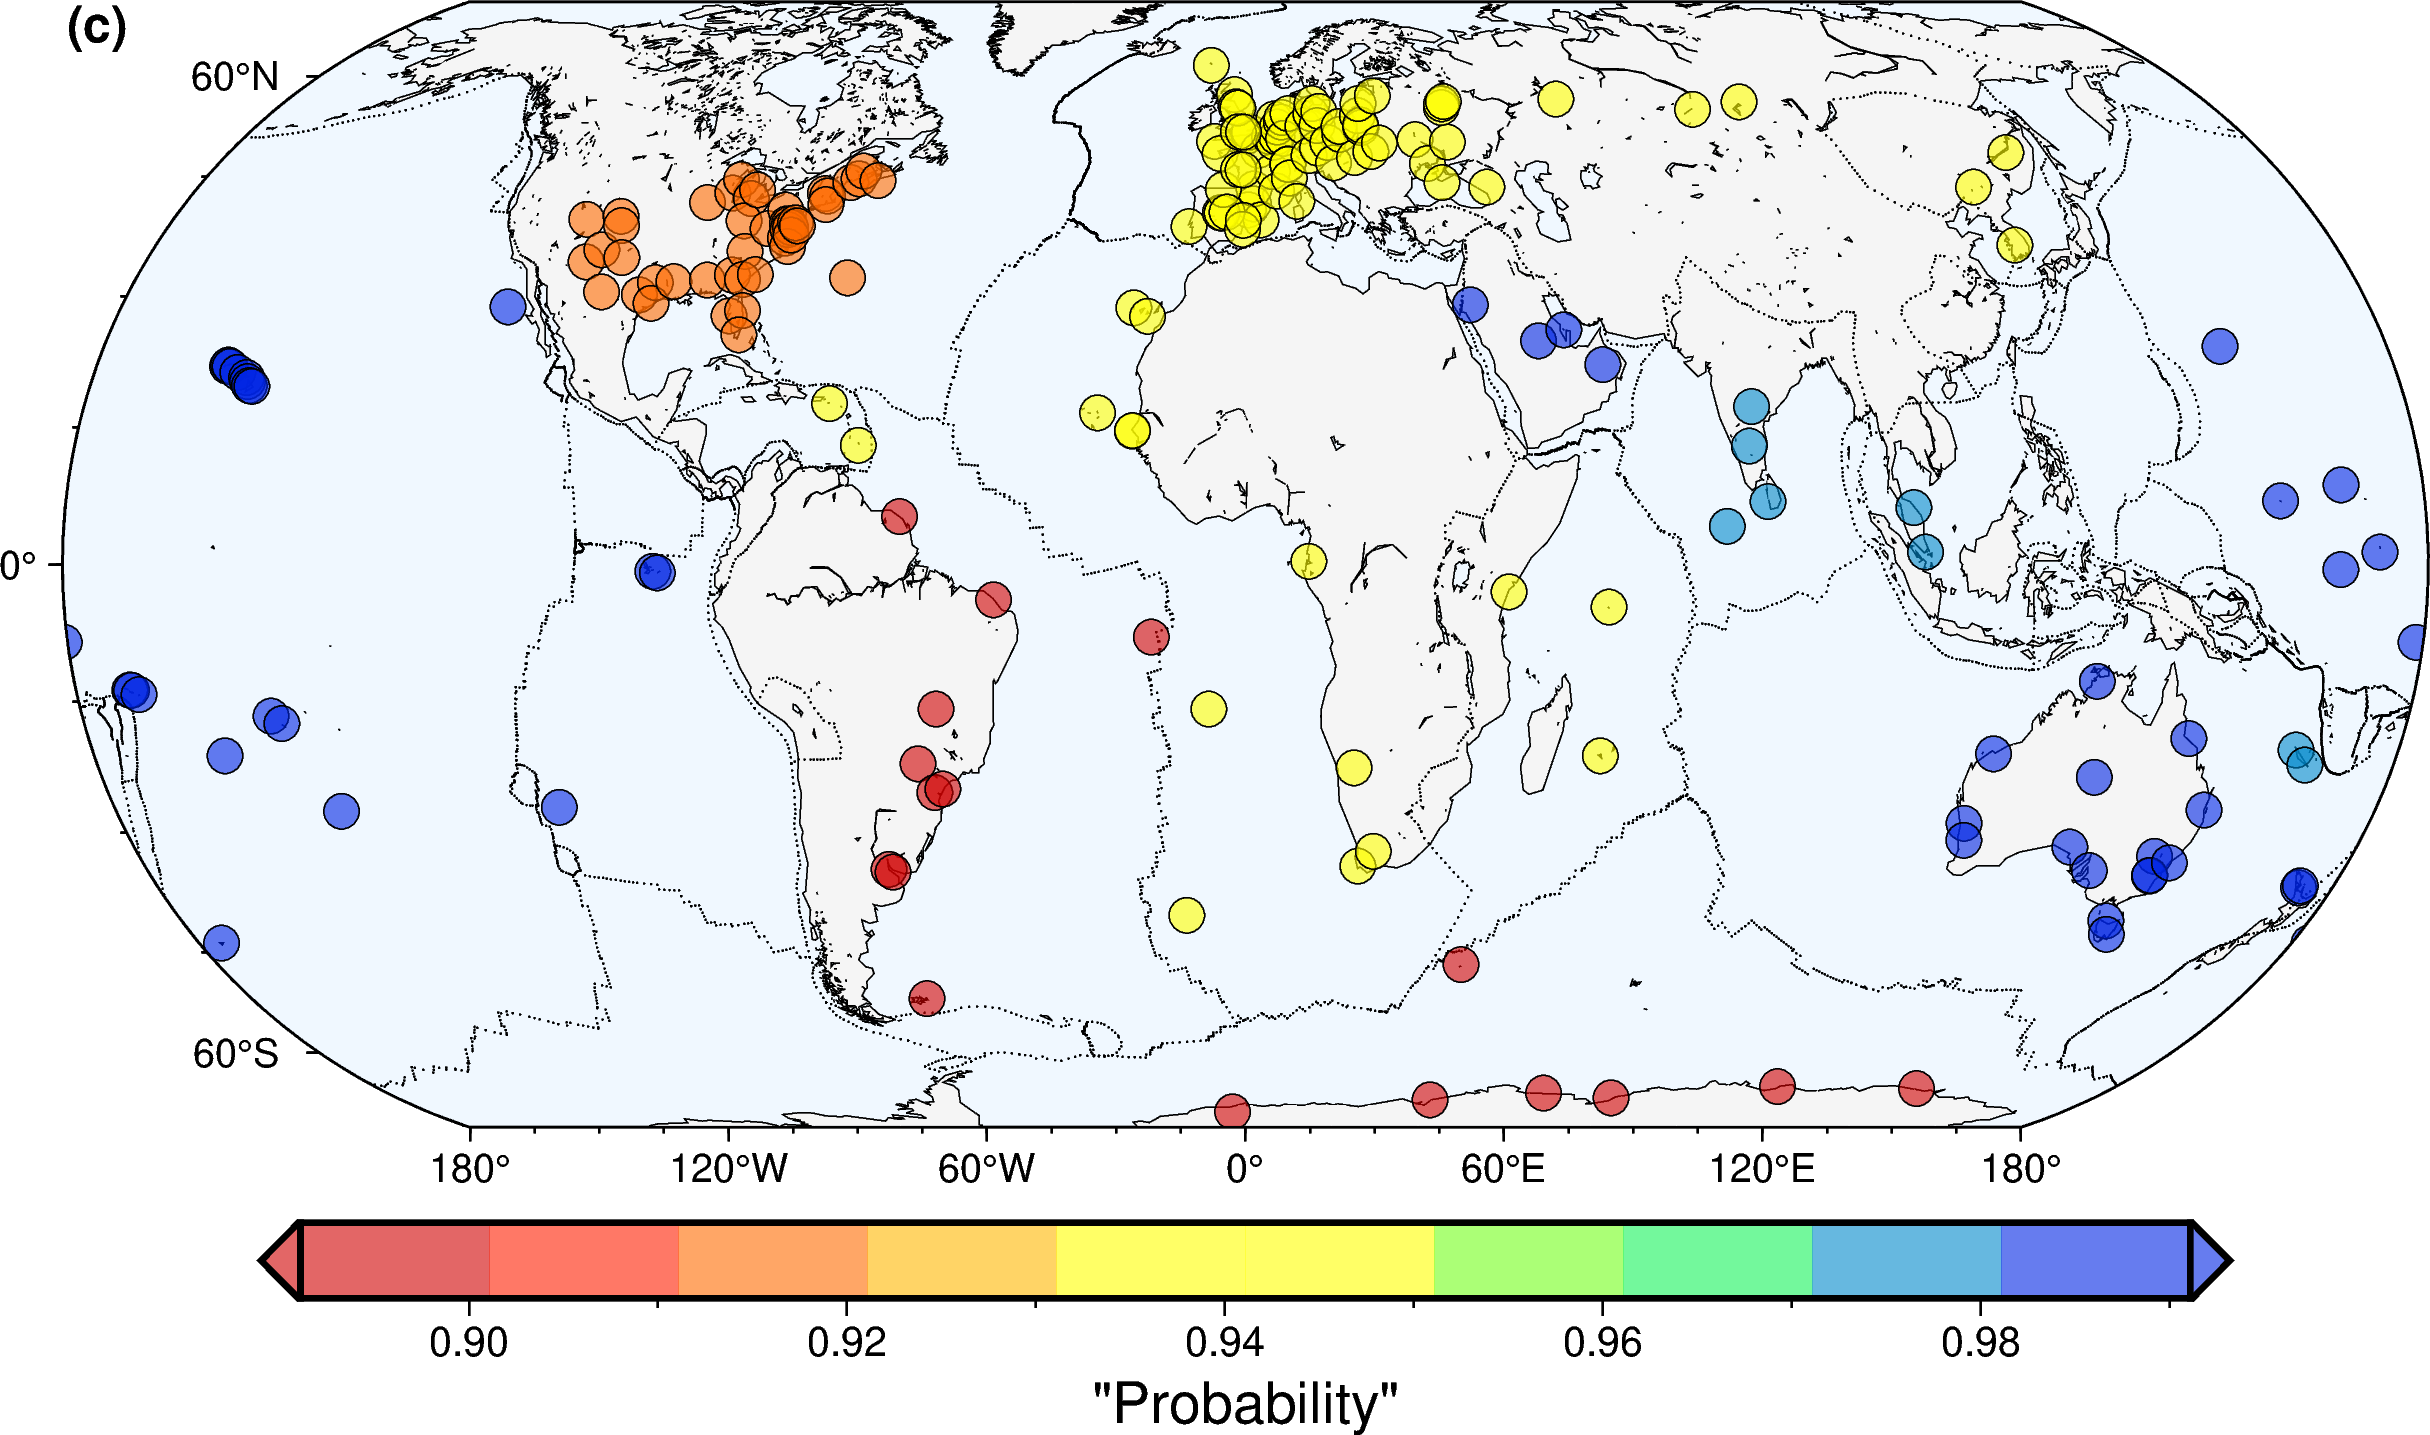

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(cluster_K_ITRF2008_loo_prob), max(cluster_K_ITRF2008_loo_prob), 0.01],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2008):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2008_vec["lon"][i],
        y=ITRF2008_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=cluster_K_ITRF2008_loo_prob[clusters_K_ITRF2008[i]-1],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Probability"'],
)


fig.text(text="(c)                                              ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

In [ ]:
#If you use UMAP, install UMAP fast and then conduct the following code
"""
Platename_ITRF2008 = ITRF2008_vec["PlateName"].unique()

state = 1
my_model = umap.UMAP(random_state=state,metric='precomputed')

my_model_fit_EVPT = my_model.fit_transform(EVPTfit_distmat_ITRF2008)
my_model_fit_EV = my_model.fit_transform(EVfit_distmat_ITRF2008)
my_model_fit_PT = my_model.fit_transform(PTEuc_distmat_ITRF2008)
fig = plt.figure(figsize=(15,15))
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax1=fig.add_subplot(2,2,1,facecolor="lightgray")
ax2=fig.add_subplot(2,2,2,facecolor="lightgray")
ax3=fig.add_subplot(2,2,3,facecolor="lightgray")
symbollist = ["v", "^", "o", "s", "p", "*","h","H",  ">", "X", "D","d","<","P"]


for i in range(num_of_stations_ITRF2008):
  p=list(Platename_ITRF2008).index(ITRF2008_vec["PlateName"][i])
  if (i==list(ITRF2008_vec["PlateName"]).index(Platename_ITRF2008[p])):
    ax1.plot(my_model_fit_PT[i,0], my_model_fit_PT[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p],label=Platename_ITRF2008[p])
  else:
    ax1.plot(my_model_fit_PT[i,0], my_model_fit_PT[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p])
ax1.set_title("(a) PT",fontsize=20)
ax1.set_xlim(min(my_model_fit_PT[:,0])-1,max(my_model_fit_PT[:,0])+1)
ax1.set_ylim(min(my_model_fit_PT[:,1])-1,max(my_model_fit_PT[:,1])+1)
ax1.set_xticks([])
ax1.set_yticks([])

for i in range(num_of_stations_ITRF2008):
  p=list(Platename_ITRF2008).index(ITRF2008_vec["PlateName"][i])
  if (i==list(ITRF2008_vec["PlateName"]).index(Platename_ITRF2008[p])):
    ax2.plot(my_model_fit_EVPT[i,0], my_model_fit_EVPT[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p],label=Platename_ITRF2008[p])
  else:
    ax2.plot(my_model_fit_EVPT[i,0], my_model_fit_EVPT[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p])
ax2.set_title("(b) EVPT",fontsize=20)
ax2.set_xlim(min(my_model_fit_EVPT[:,0])-1,max(my_model_fit_EVPT[:,0])+1)
ax2.set_ylim(min(my_model_fit_EVPT[:,1])-1,max(my_model_fit_EVPT[:,1])+1)
ax2.set_xticks([])
ax2.set_yticks([])


ax3.plot(my_model_fit_EV[0,0],my_model_fit_EV[0,1],color="gray",label="Plate name",linewidth=0.)
for i in range(num_of_stations_ITRF2008):
  p=list(Platename_ITRF2008).index(ITRF2008_vec["PlateName"][i])
  if (i==list(ITRF2008_vec["PlateName"]).index(Platename_ITRF2008[p])):
    ax3.plot(my_model_fit_EV[i,0], my_model_fit_EV[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p],label=Platename_ITRF2008[p])
  else:
    ax3.plot(my_model_fit_EV[i,0], my_model_fit_EV[i,1], symbollist[p],alpha=1.0,markersize=7,
             markeredgecolor="black",markeredgewidth=0.5,color=colorlist_ITRF2008[p])
ax3.set_title("(c) EV",fontsize=20)
ax3.set_xlim(min(my_model_fit_EV[:,0])-1,max(my_model_fit_EV[:,0])+1)
ax3.set_ylim(min(my_model_fit_EV[:,1])-1,max(my_model_fit_EV[:,1])+1)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.legend(fontsize=18,loc='center right', bbox_to_anchor=(+1.75, 0.5),facecolor='lightgray')
"""

'\nPlatename_ITRF2008 = ITRF2008_vec["PlateName"].unique()\n\nstate = 1\nmy_model = umap.UMAP(random_state=state,metric=\'precomputed\')\n\nmy_model_fit_EVPT = my_model.fit_transform(EVPTfit_distmat_ITRF2008)\nmy_model_fit_EV = my_model.fit_transform(EVfit_distmat_ITRF2008)\nmy_model_fit_PT = my_model.fit_transform(PTEuc_distmat_ITRF2008)\nfig = plt.figure(figsize=(15,15))\nplt.subplots_adjust(wspace=0.05, hspace=0.1)\nax1=fig.add_subplot(2,2,1,facecolor="lightgray")\nax2=fig.add_subplot(2,2,2,facecolor="lightgray")\nax3=fig.add_subplot(2,2,3,facecolor="lightgray")\nsymbollist = ["v", "^", "o", "s", "p", "*","h","H",  ">", "X", "D","d","<","P"]\n\n\nfor i in range(num_of_stations_ITRF2008):\n  p=list(Platename_ITRF2008).index(ITRF2008_vec["PlateName"][i])\n  if (i==list(ITRF2008_vec["PlateName"]).index(Platename_ITRF2008[p])):\n    ax1.plot(my_model_fit_PT[i,0], my_model_fit_PT[i,1], symbollist[p],alpha=1.0,markersize=7,\n             markeredgecolor="black",markeredgewidth=0.5,color=c

# ITRF2020

In [ ]:
# Import csv
# Change FILEPATH
ITRF2020_vec=pd.read_csv(FILEPATH+'ITRF2020.csv')

Platename_ITRF2020=ITRF2020_vec["PlateName"].unique()
num_of_stations_ITRF2020 = len(ITRF2020_vec["lat"])

#Identifying Type
ITRF2020_vec["PlateName"]=ITRF2020_vec["PlateName"].astype('str')
ITRF2020_vec["lon"]=ITRF2020_vec["lon"].astype('float64')
ITRF2020_vec["lat"]=ITRF2020_vec["lat"].astype('float64')
ITRF2020_vec["Eastward[mm/a]"]=ITRF2020_vec["Eastward[mm/a]"].astype('float64')
ITRF2020_vec["Northward[mm/a]"]=ITRF2020_vec["Northward[mm/a]"].astype('float64')
ITRF2020_vec["Error_east"]=ITRF2020_vec["Error_east"].astype('float64')
ITRF2020_vec["Error_north"]=ITRF2020_vec["Error_north"].astype('float64')
ITRF2020_vec["Error_east2"]=ITRF2020_vec["Error_east2"].astype('float64')
ITRF2020_vec["Error_north1"]=ITRF2020_vec["Error_north1"].astype('float64')

#Pre-registration
ITRF2020_vec["x"]=0.
ITRF2020_vec["y"]=0.
ITRF2020_vec["z"]=0.
ITRF2020_vec["v_x"]=0.
ITRF2020_vec["v_y"]=0.
ITRF2020_vec["v_z"]=0.
ITRF2020_vec["PlateCap"]="A"
ITRF2020_vec["v_lat_sd_x"]=0.
ITRF2020_vec["v_lat_sd_y"]=0.
ITRF2020_vec["v_lat_sd_z"]=0.
ITRF2020_vec["v_lon_sd_x"]=0.
ITRF2020_vec["v_lon_sd_y"]=0.
ITRF2020_vec["v_lon_sd_z"]=0.

data_scaling=0.01


for i in range(num_of_stations_ITRF2020):
  lat = ITRF2020_vec["lat"][i]*(np.pi/180)
  lon = ITRF2020_vec["lon"][i]*(np.pi/180)
  tangentrep = tangential_representation(lat,lon)
  x,y,z=tangentrep[0]
  e_vlat=tangentrep[1]
  e_vlon=tangentrep[2]
  vlat = data_scaling*(ITRF2020_vec["Northward[mm/a]"][i])* e_vlat
  vlon = data_scaling*(ITRF2020_vec["Eastward[mm/a]"][i]) * e_vlon
  vlat_sd = data_scaling*(ITRF2020_vec["Error_north"][i])* e_vlat
  vlon_sd = data_scaling*(ITRF2020_vec["Error_east"][i]) * e_vlon
  v       = vlat+vlon

  ITRF2020_vec.at[i,"x"]=x
  ITRF2020_vec.at[i,"y"]=y
  ITRF2020_vec.at[i,"z"]=z
  ITRF2020_vec.at[i,"v_x"]=v[0]
  ITRF2020_vec.at[i,"v_y"]=v[1]
  ITRF2020_vec.at[i,"v_z"]=v[2]
  ITRF2020_vec.at[i,"v_z"]=v[2]
  ITRF2020_vec.at[i,"PlateCap"]=ITRF2020_vec.at[i,"PlateName"][0:3]


#Registaration of 3D data
bundle_array_ITRF2020 = np.array([
    (ITRF2020_vec.loc[i,["x","y","z"]].astype(float).values,ITRF2020_vec.loc[i,["v_x","v_y","v_z"]].astype(float).values)
                                for i in range(num_of_stations_ITRF2020)])


#Registration of 2D data
vel_array_ITRF2020 = np.array([
    np.hstack((ITRF2020_vec.loc[i,["x","y","z"]].astype(float).values,
                             ITRF2020_vec.loc[i,["Eastward[mm/a]","Northward[mm/a]"]].astype(float).values))
                          for i in range(num_of_stations_ITRF2020)])

**Similarity metric computation**

In [ ]:
alphaparams=np.array([1.,1.])
EVPTfit_distmat_ITRF2020 = np.zeros(num_of_stations_ITRF2020*num_of_stations_ITRF2020).reshape((num_of_stations_ITRF2020,num_of_stations_ITRF2020))
EVfit_distmat_ITRF2020 = np.zeros(num_of_stations_ITRF2020*num_of_stations_ITRF2020).reshape((num_of_stations_ITRF2020,num_of_stations_ITRF2020))
PTEuc_distmat_ITRF2020 = np.zeros(num_of_stations_ITRF2020*num_of_stations_ITRF2020).reshape((num_of_stations_ITRF2020,num_of_stations_ITRF2020))
EVPTfit_list = np.zeros(num_of_stations_ITRF2020*num_of_stations_ITRF2020*9).reshape((num_of_stations_ITRF2020,num_of_stations_ITRF2020,9))

for i in range(num_of_stations_ITRF2020):
  for j in range(i+1,num_of_stations_ITRF2020):
    EVPTfit_distmat_ITRF2020[i,j]=combinedEVPTfit_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j],alpha=alphaparams)
    EVPTfit_distmat_ITRF2020[j,i]=combinedEVPTfit_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j],alpha=alphaparams)

    EVfit_distmat_ITRF2020[i,j]=EVfit_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j])
    EVfit_distmat_ITRF2020[j,i]=EVfit_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j])

    PTEuc_distmat_ITRF2020[i,j]=PTEuc_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j])
    PTEuc_distmat_ITRF2020[j,i]=PTEuc_distance(bundle_start=bundle_array_ITRF2020[i],bundle_end=bundle_array_ITRF2020[j])

Vel_distmat_ITRF2020 = np.zeros(num_of_stations_ITRF2020*num_of_stations_ITRF2020).reshape((num_of_stations_ITRF2020,num_of_stations_ITRF2020))
for i in range(num_of_stations_ITRF2020):
  for j in range(i+1,num_of_stations_ITRF2020):
    Vel_distmat_ITRF2020[i,j]=np.sqrt(np.sum((vel_array_ITRF2020[i][[3,4]]-vel_array_ITRF2020[j][[3,4]])**2))
    Vel_distmat_ITRF2020[j,i]=np.sqrt(np.sum((vel_array_ITRF2020[i][[3,4]]-vel_array_ITRF2020[j][[3,4]])**2))

**Hierarchical agglomerative clustering**

In [ ]:
#Select linkage method among average, single, complete
method="average"
#Select similarity among PT, EV, EVPT
distchange="EVPT"

if distchange=="EVPT":
  pdistform_ITRF2020 = squareform(EVPTfit_distmat_ITRF2020)
elif distchange=="PT":
  pdistform_ITRF2020 = squareform(PTEuc_distmat_ITRF2020)
elif distchange=="EV":
  pdistform_ITRF2020 = squareform(EVfit_distmat_ITRF2020)

HAC_ITRF2020 = shc.linkage(pdistform_ITRF2020,method=method)


**Dendrogram of the result**

Text(0, 0.5, 'EVPT metric value')

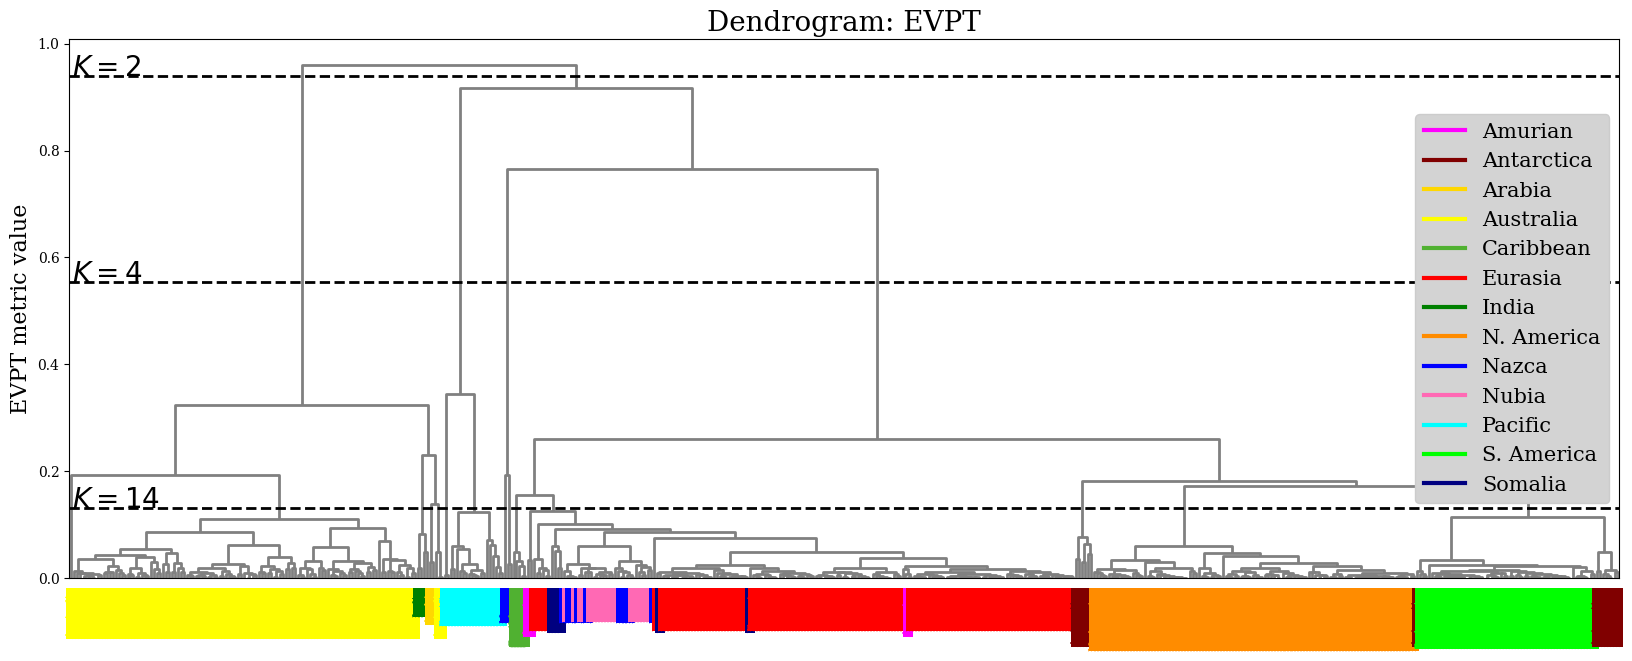

In [ ]:
#Colorlist for plot
colorlist_ITRF2020=['#ff00ff','#800000','#ffd700','#ffff00','#50b131','#ff0000','#008000','#ff8c00','#0000ff','#ff69b4','#00ffff','#00ff00','#000080','#000000']

#Plot dendrogram
fig, ax = plt.subplots(figsize=(20, 7))
dn = shc.dendrogram(HAC_ITRF2020,orientation='top',labels=list(ITRF2020_vec["PlateName"]),leaf_font_size=8,color_threshold=100,link_color_func=color_func)
for t in ax.get_xticklabels():
    txt = t.get_text()
    t.set_color(colorlist_ITRF2020[np.where(Platename_ITRF2020==txt)[0][0]])
    t.set_bbox(dict(facecolor=colorlist_ITRF2020[np.where(Platename_ITRF2020==txt)[0][0]],boxstyle='square,pad=0.0', edgecolor='none', alpha=1.0))
for p in Platename_ITRF2020:
  plt.plot(0,0,marker='o',markersize=0,color=colorlist_ITRF2020[np.where(Platename_ITRF2020==p)[0][0]],label=p)
legend = plt.legend(fontsize=15,facecolor='lightgray',framealpha=1.0)
for handle in legend.legend_handles:
    handle.set_linewidth(3.0)
plt.title("Dendrogram: "+distchange,fontsize=20)
#get height for K=4
K=2
height_2=(HAC_ITRF2020[:,2][-K]+HAC_ITRF2020[:,2][-(K-1)])/2
#get height for K=4
K=4
height_4=(HAC_ITRF2020[:,2][-K]+HAC_ITRF2020[:,2][-(K-1)])/2
#get height for K=14
K=14
height_14=(HAC_ITRF2020[:,2][-K]+HAC_ITRF2020[:,2][-(K-1)])/2
ax.axhline(y=height_2, color='k', linestyle='--')
ax.text(x=10,y=height_2,s=r"$K=2$",fontsize=20)
ax.axhline(y=height_4, color='k', linestyle='--')
ax.text(x=10,y=height_4,s=r"$K=4$",fontsize=20)
ax.axhline(y=height_14, color='k', linestyle='--')
ax.text(x=10,y=height_14,s=r"$K=14$",fontsize=20)
ax.set_ylabel(distchange+' metric value',fontsize=16)

**Map view of the clustering result**

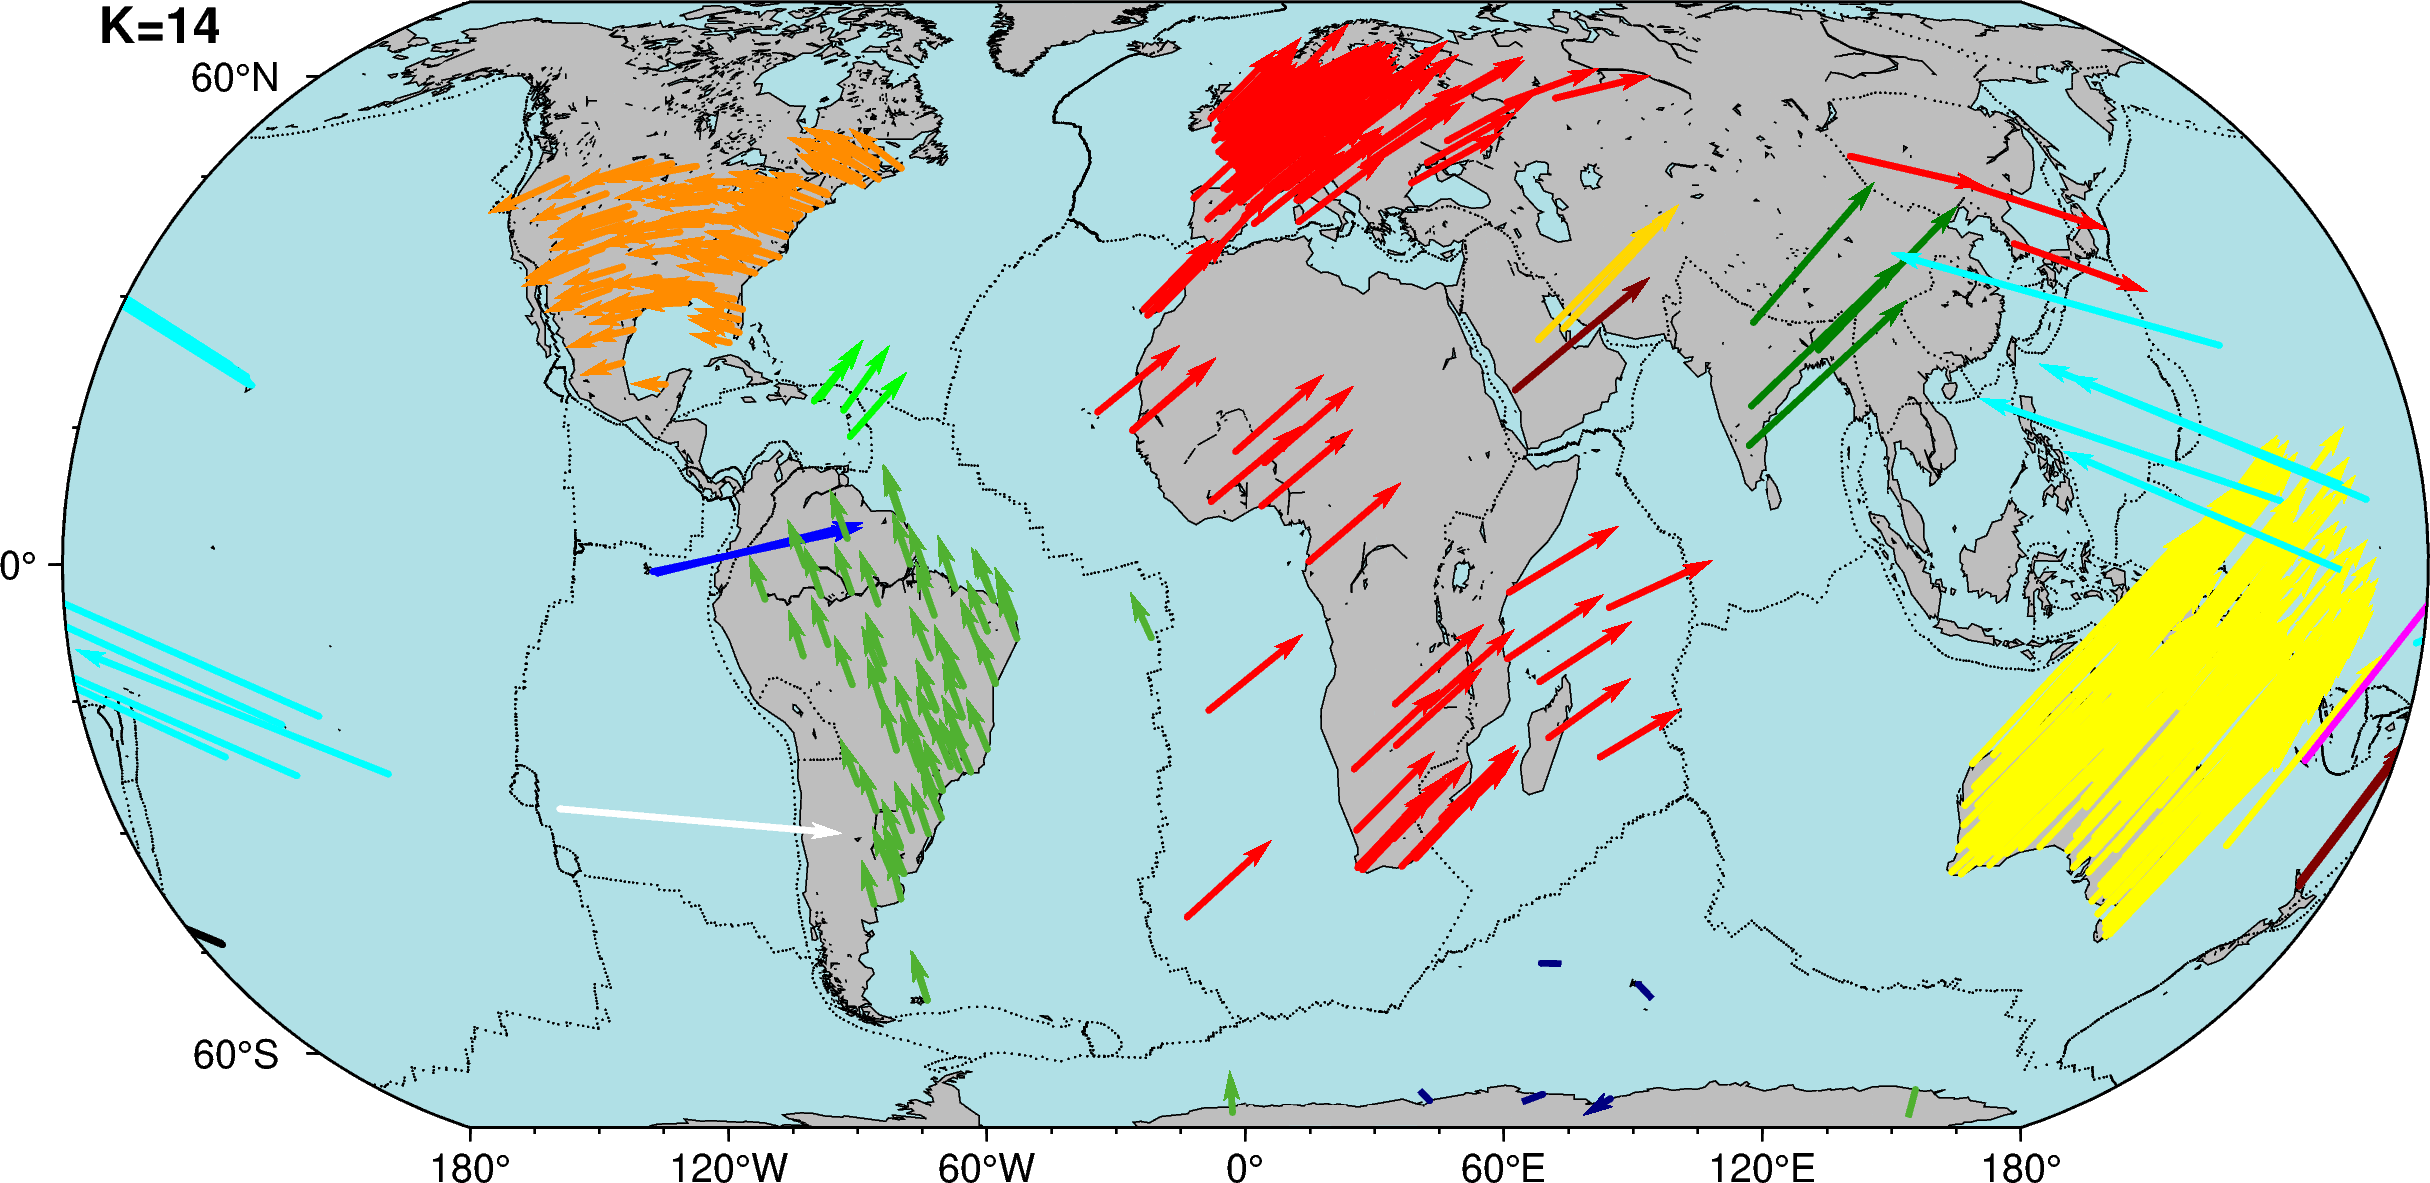

In [ ]:
#================================================================================
#Clustering result
K=14
clusters_ITRF2020 = fcluster(HAC_ITRF2020, K, criterion='maxclust')
color_pal_ITRF2020 = ['#ffff00','#ff00ff','#008000','#ffd700','#800000','#000000',
                          '#00ffff','#0000ff','#ffffff','#00ff00','#ff0000','#000080','#ff8c00','#50b131']

scale_p = 1.75
#================================================================================
#Information for plotting
df_K = pd.DataFrame(
    data={
        "x": ITRF2020_vec["lon"],
        "y": ITRF2020_vec["lat"],
        "east_velocity": scale_p*ITRF2020_vec["Eastward[mm/a]"],
        "north_velocity": scale_p*ITRF2020_vec["Northward[mm/a]"],
        "east_sigma": 0,
        "north_sigma": 0,
        "correlation_EN": 0,
        "SITE": clusters_ITRF2020
    }
)
#================================================================================


#================================================================================
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", frame=True,zsize=20)

fig.coast(land="grey", water="powderblue",
  shorelines=True)


fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)

for i in range(num_of_stations_ITRF2020):
  fig.plot(x=ITRF2020_vec["lon"][i], y=ITRF2020_vec["lat"][i], style="c0.05c",fill=color_pal_ITRF2020[(clusters_ITRF2020[i]-1)])

for k in range(1,K+1):
  fig.velo(data=df_K[df_K["SITE"]==k],pen="1.5p,"+color_pal_ITRF2020[k-1],vector="0.25c+p1p,"+color_pal_ITRF2020[k-1]+"+e+g"+color_pal_ITRF2020[k-1],spec="e0.02/0.05/0.1")
fig.text(text="K="+str(K)+"                                     ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

**Matrix representation of the similarity metric**

Text(0.5, 1.0, 'EVPT similarity matrix')

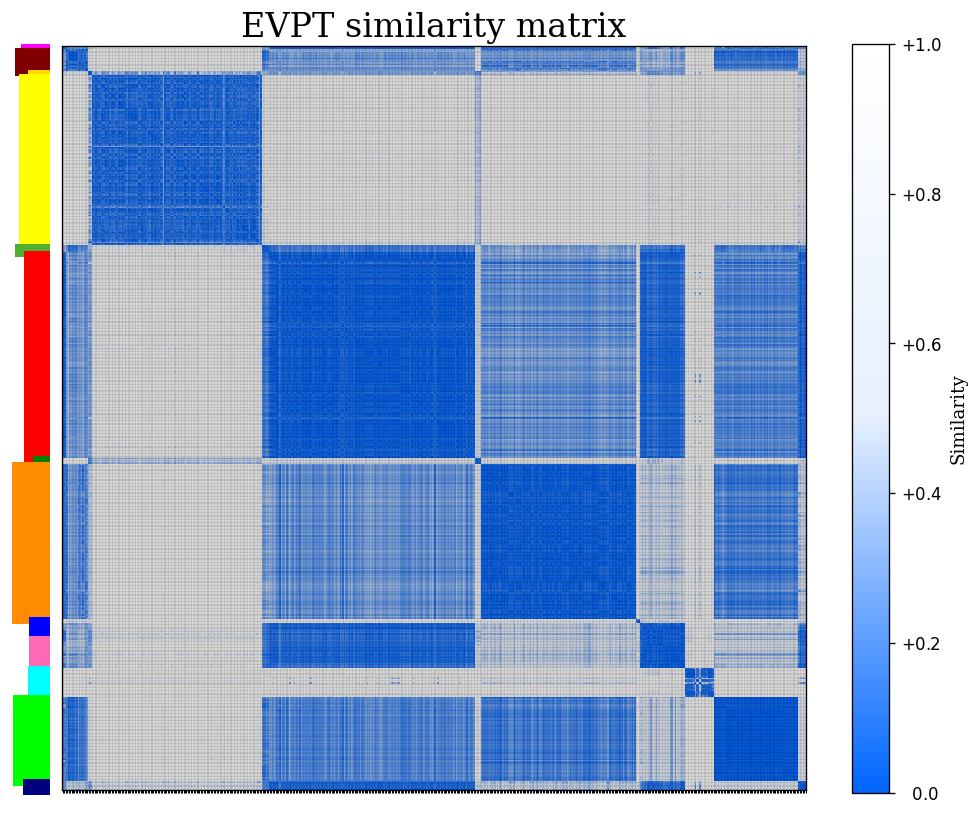

In [ ]:
#===================================================
distchange="EVPT"
Platename = ITRF2020_vec["PlateName"].unique()

if distchange=="EVPT":
  scaling = np.exp(EVPTfit_distmat_ITRF2020)-1
elif distchange=="PT":
  scaling = np.exp(PTEuc_distmat_ITRF2020)-1
elif distchange=="EV":
  scaling = np.exp(EVfit_distmat_ITRF2020)-1
elif distchange=="Vel":
  scaling = np.exp(0.01*Vel_distmat_ITRF2020)-1
#===================================================

fig, ax = plt.subplots(figsize=(10,10),dpi=120)


#==================================================================================
#Color map
cl = list()
cl.append( ( 0.00, matplotlib.colors.hsv_to_rgb((0.6, 1.  ,1))) )
cl.append( ( 0.50, matplotlib.colors.hsv_to_rgb((0.6, 0.1 ,1))) )
cl.append( ( 1.00, matplotlib.colors.hsv_to_rgb((0.0, 0.  ,1))) )
ccm = matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', cl)
#==================================================================================


plt.imshow(scaling ,interpolation='nearest',vmin=0,vmax=1,cmap=ccm)


#==================================================================================
#Setting label
plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticks(range(num_of_stations_ITRF2020))
plt.gca().set_yticklabels(ITRF2020_vec["PlateName"],fontsize=4)
plt.tick_params(axis='both', which='both', top=False, left=False )
fmt = lambda p, pos=None : f'${p:+.1f}$' if p!=0 else '  $0.0$'
cb = plt.colorbar(format=ticker.FuncFormatter(fmt),shrink=0.81)
cb.set_label("Similarity", fontsize=11)
for t in ax.get_yticklabels():
    txt = t.get_text()
    t.set_color(colorlist_ITRF2020[np.where(Platename==txt)[0][0]])
    t.set_bbox(dict(facecolor=colorlist_ITRF2020[np.where(Platename==txt)[0][0]],
                    boxstyle='square,pad=0.0', edgecolor='none', alpha=1.0))
#==================================================================================



#==================================================================================
#Grid lines
plt.grid(True, which='both', color='black', linewidth=0.0, linestyle='-')
plt.gca().set_xticks(np.arange(scaling.shape[1])+0.5 , minor=True)
plt.gca().set_yticks(np.arange(scaling.shape[0])+0.5 , minor=True)
plt.gca().grid(True, which='minor', color='black', linewidth=0.1, linestyle='-')
#==================================================================================

plt.title(distchange+" similarity matrix",fontsize=20)

**Stability check**

In [ ]:

#===========================================
distchange="EVPT"
K=14
clusters_K_ITRF2020=fcluster(HAC_ITRF2020, K, criterion='maxclust')
#===========================================
leaveout_result_ITRF2020 = []

for leaveout_index in range(num_of_stations_ITRF2020):
  safe_indices = [j for j in range(num_of_stations_ITRF2020) if j != leaveout_index ]
  pdistform_ITRF2020_loo = squareform(EVPTfit_distmat_ITRF2020[safe_indices][:,safe_indices])
  clusters_ITRF2020_loo = shc.linkage(pdistform_ITRF2020_loo,
            method=method)
  tmp=shc.fcluster(clusters_ITRF2020_loo, K, criterion='maxclust').tolist()
  tmp.insert(leaveout_index,K+10)
  leaveout_result_ITRF2020.append(np.array(tmp))


loo_adjusted_rand_score_ITRF2020 = []
for loo in range(num_of_stations_ITRF2020):
  exclude_indices = np.array([loo])
  mask = np.ones(len(leaveout_result_ITRF2020[loo]), dtype=bool)
  mask[exclude_indices] = False
  loo_adjusted_rand_score_ITRF2020.append(adjusted_rand_score(leaveout_result_ITRF2020[loo][mask],clusters_K_ITRF2020[mask]))

loo_probabilities_ITRF2020 = []
for loo in range(num_of_stations_ITRF2020):
  loo_probabilities_ITRF2020.append(np.array([ (1. == sum((leaveout_result_ITRF2020[loo][np.where(clusters_K_ITRF2020==k)[0]])/k)/len(np.where(clusters_K_ITRF2020==k)[0]))
                                    if (loo not in np.where(clusters_K_ITRF2020==k)[0]) else np.nan for k in range(1,K+1)]))
cluster_K_ITRF2020_loo_prob = np.nanmean(np.array(loo_probabilities_ITRF2020),axis=0)


sorted_indices_byoriginal = np.hstack((tuple([np.where(clusters_K_ITRF2020==k)[0] for k in range(1,K+1)])))
Stability_tensor_ITRF2020=np.array([(1.0*np.array([[leaveout_result_ITRF2020[k][sorted_indices_byoriginal][i]==leaveout_result_ITRF2020[k][sorted_indices_byoriginal][j]
                                                  for i in range(num_of_stations_ITRF2020)] for j in range(num_of_stations_ITRF2020)])) for k in range(num_of_stations_ITRF2020)])
Rij_ITRF2020=Stability_tensor_ITRF2020.mean(axis=0)


entropy_ITRF2020=np.array([[entropy(Rij_ITRF2020[i,j]) for i in range(num_of_stations_ITRF2020)] for j in range(num_of_stations_ITRF2020)])
entropy_ITRF2020_stationwise=entropy_ITRF2020.mean(axis=0)


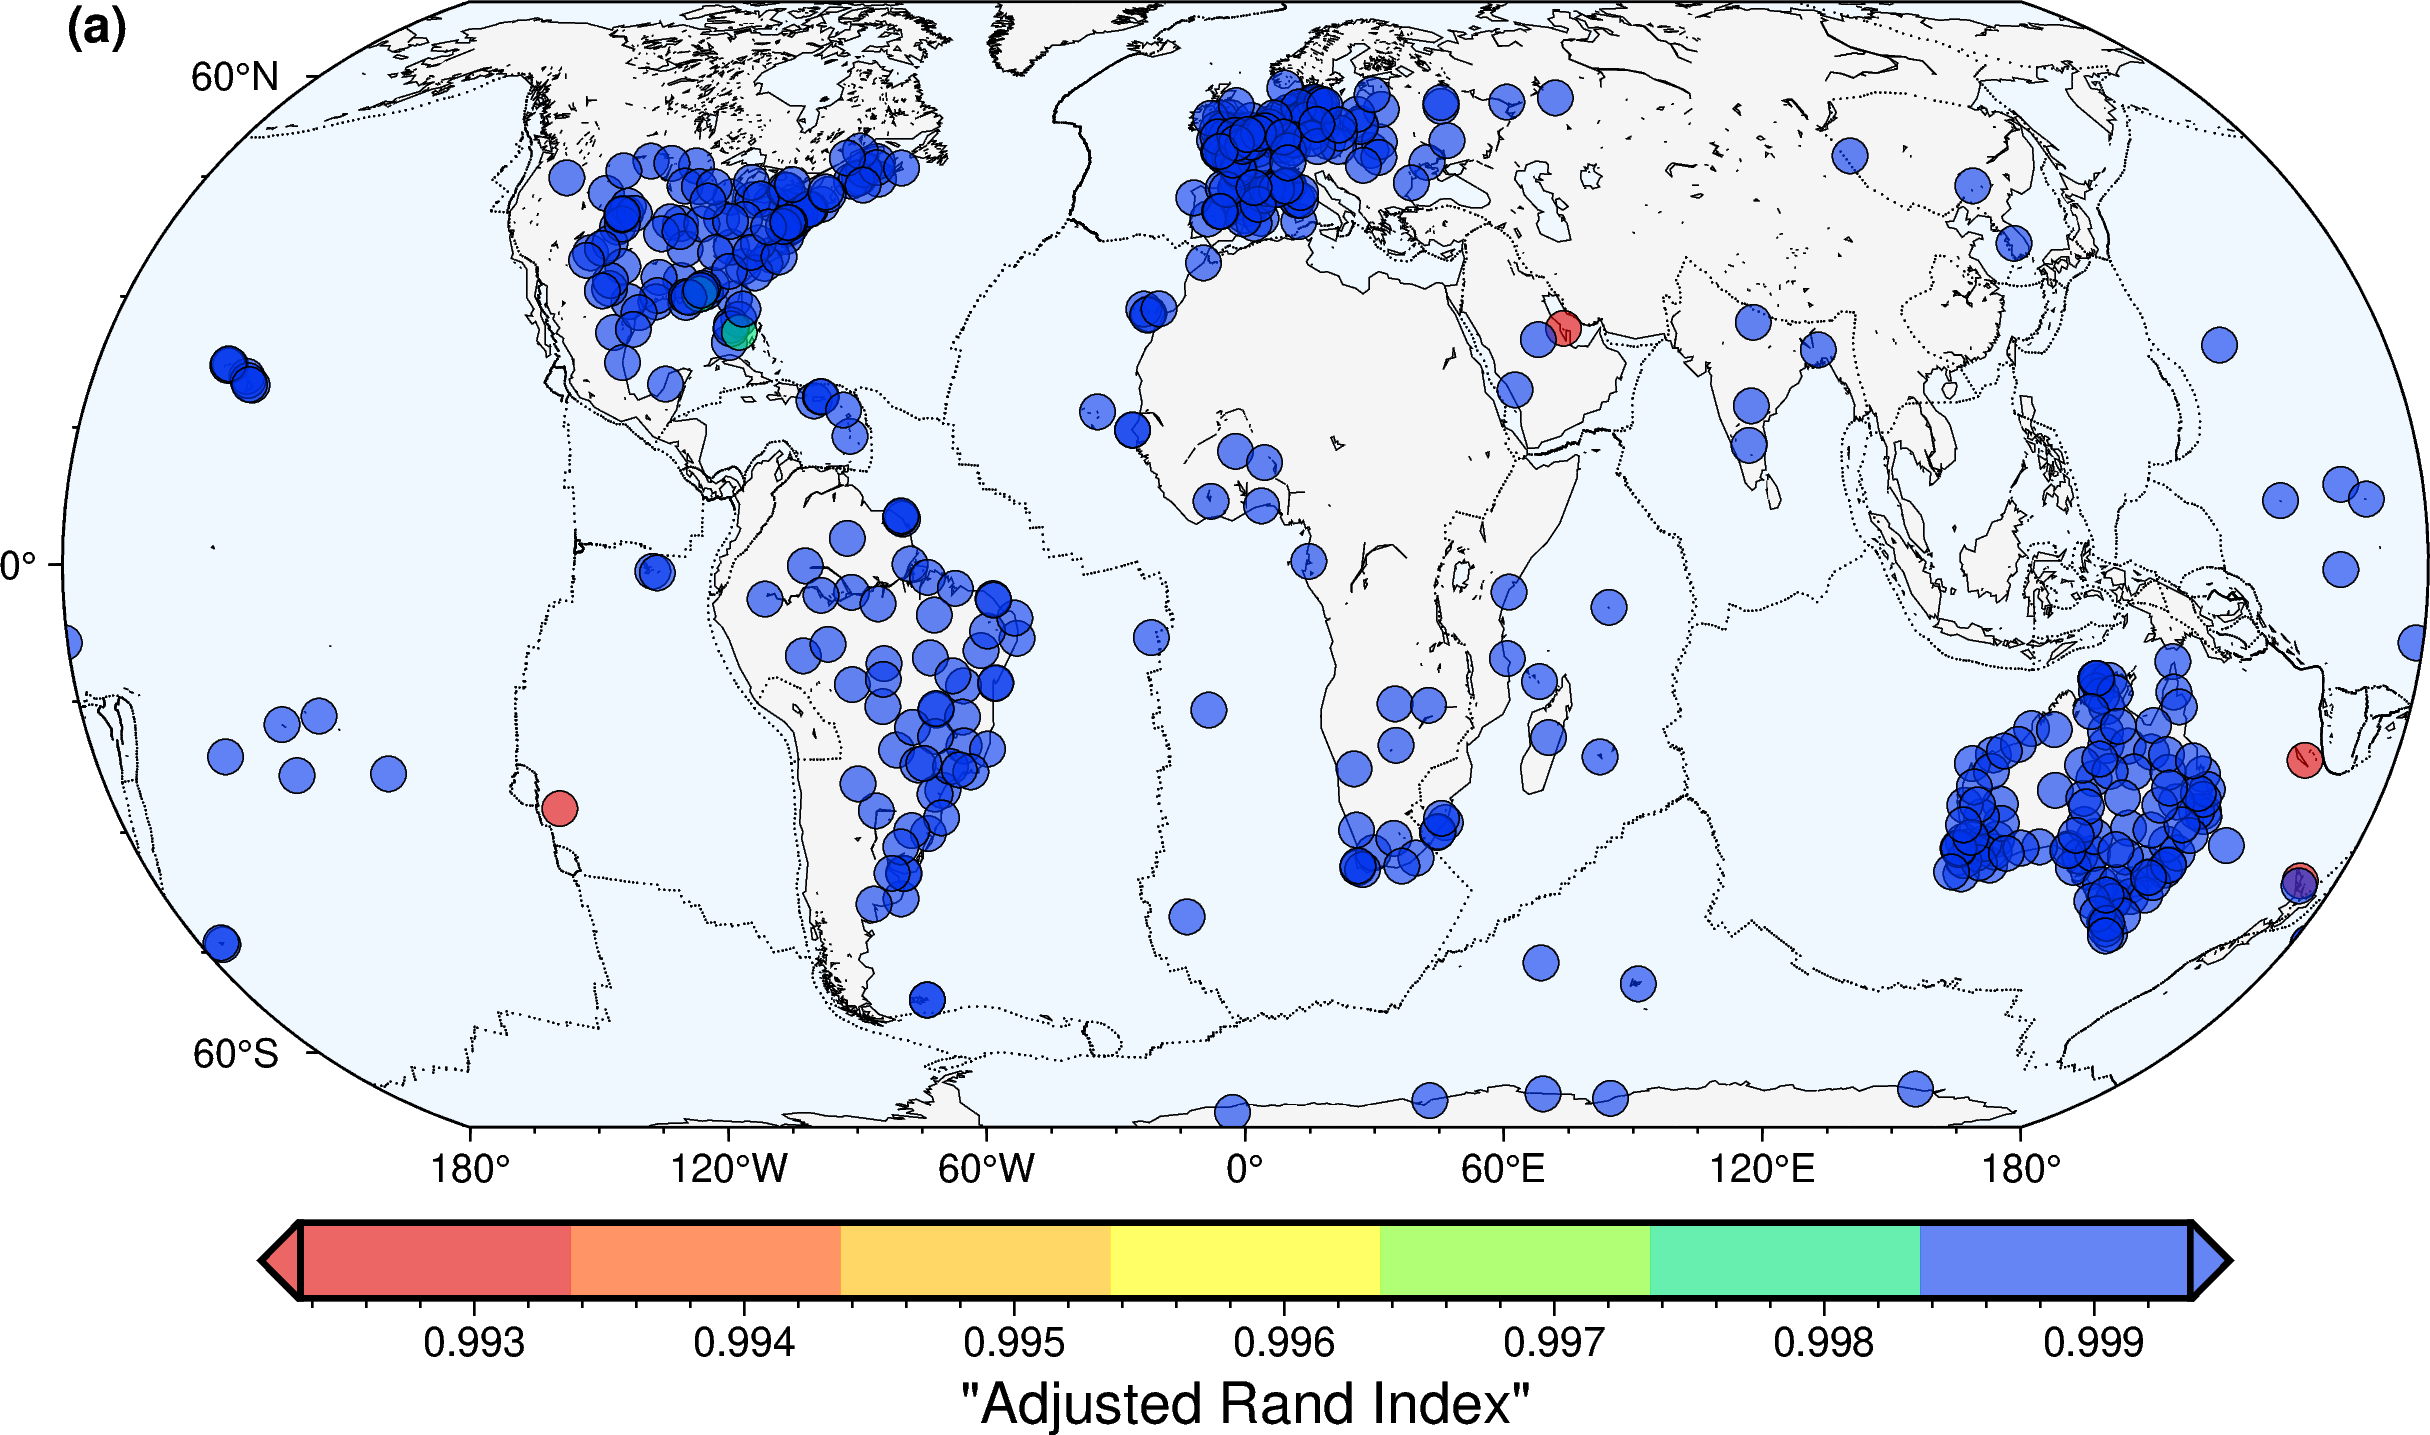

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(loo_adjusted_rand_score_ITRF2020), max(loo_adjusted_rand_score_ITRF2020), 0.001],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2020):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2020_vec["lon"][i],
        y=ITRF2020_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=loo_adjusted_rand_score_ITRF2020[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Adjusted Rand Index"'],
)


fig.text(text="(a)                                              ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

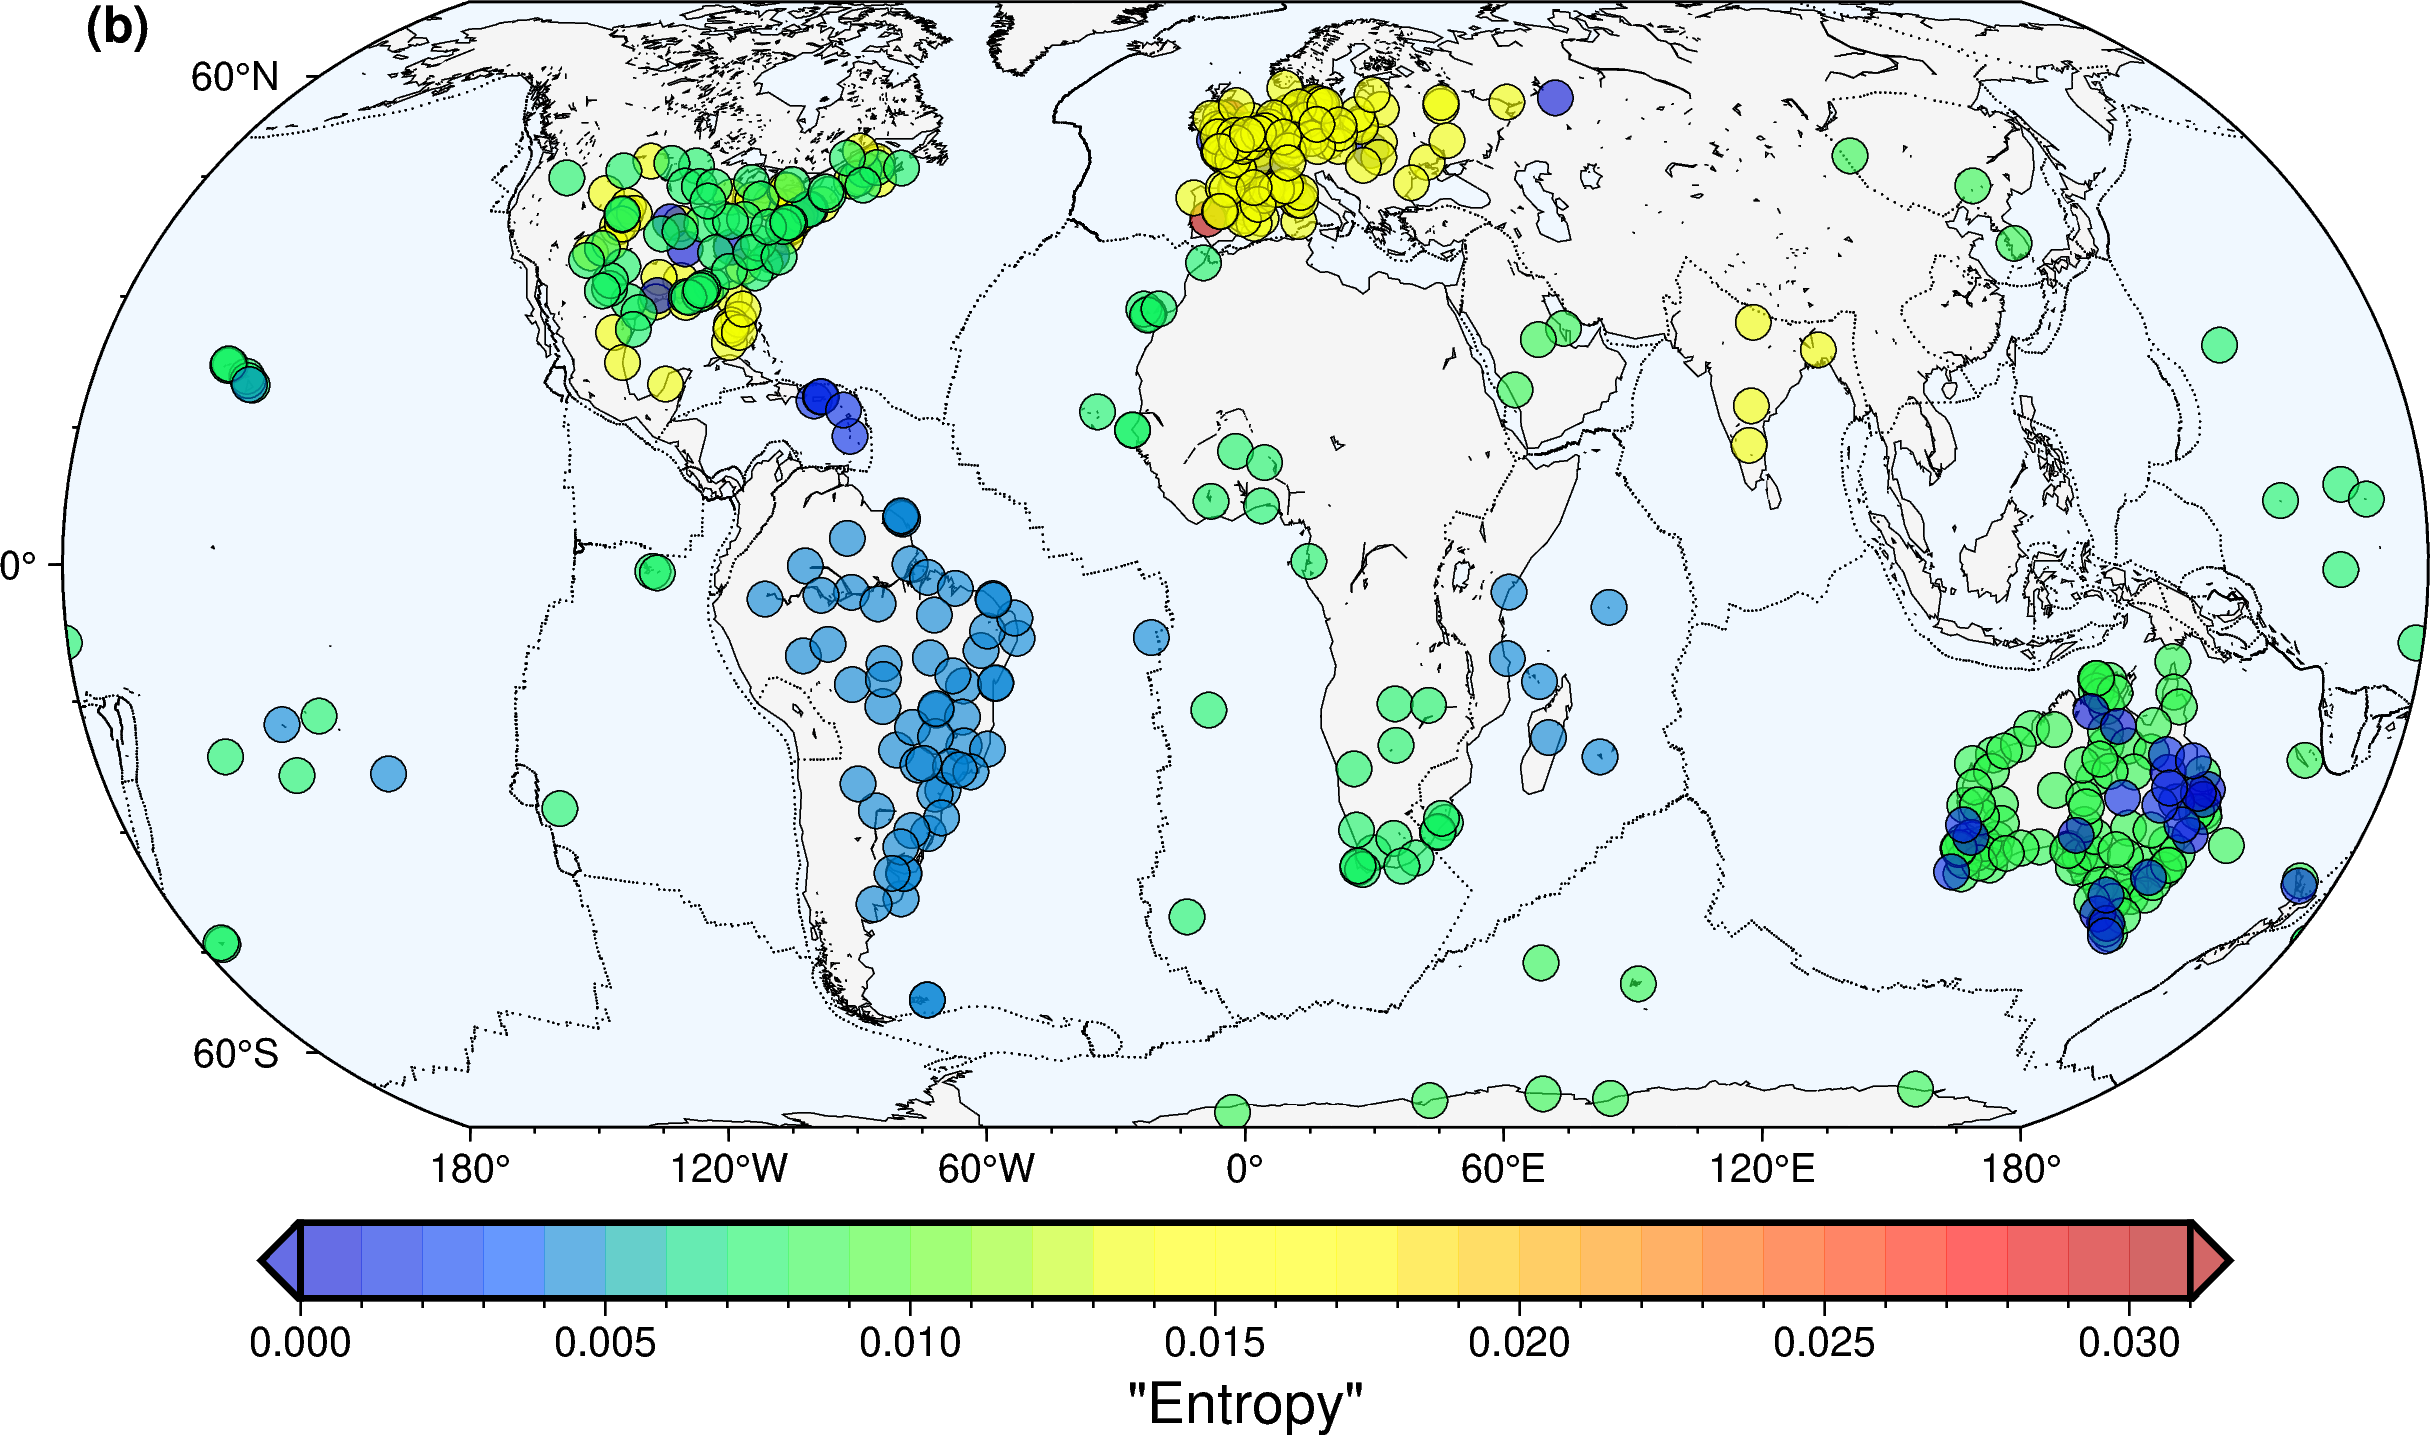

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis', reverse=True,
    series=[min(entropy_ITRF2020_stationwise), max(entropy_ITRF2020_stationwise), 0.001],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2020):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2020_vec["lon"][i],
        y=ITRF2020_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=entropy_ITRF2020_stationwise[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Entropy"'],
)


fig.text(text=" (b)                                            ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

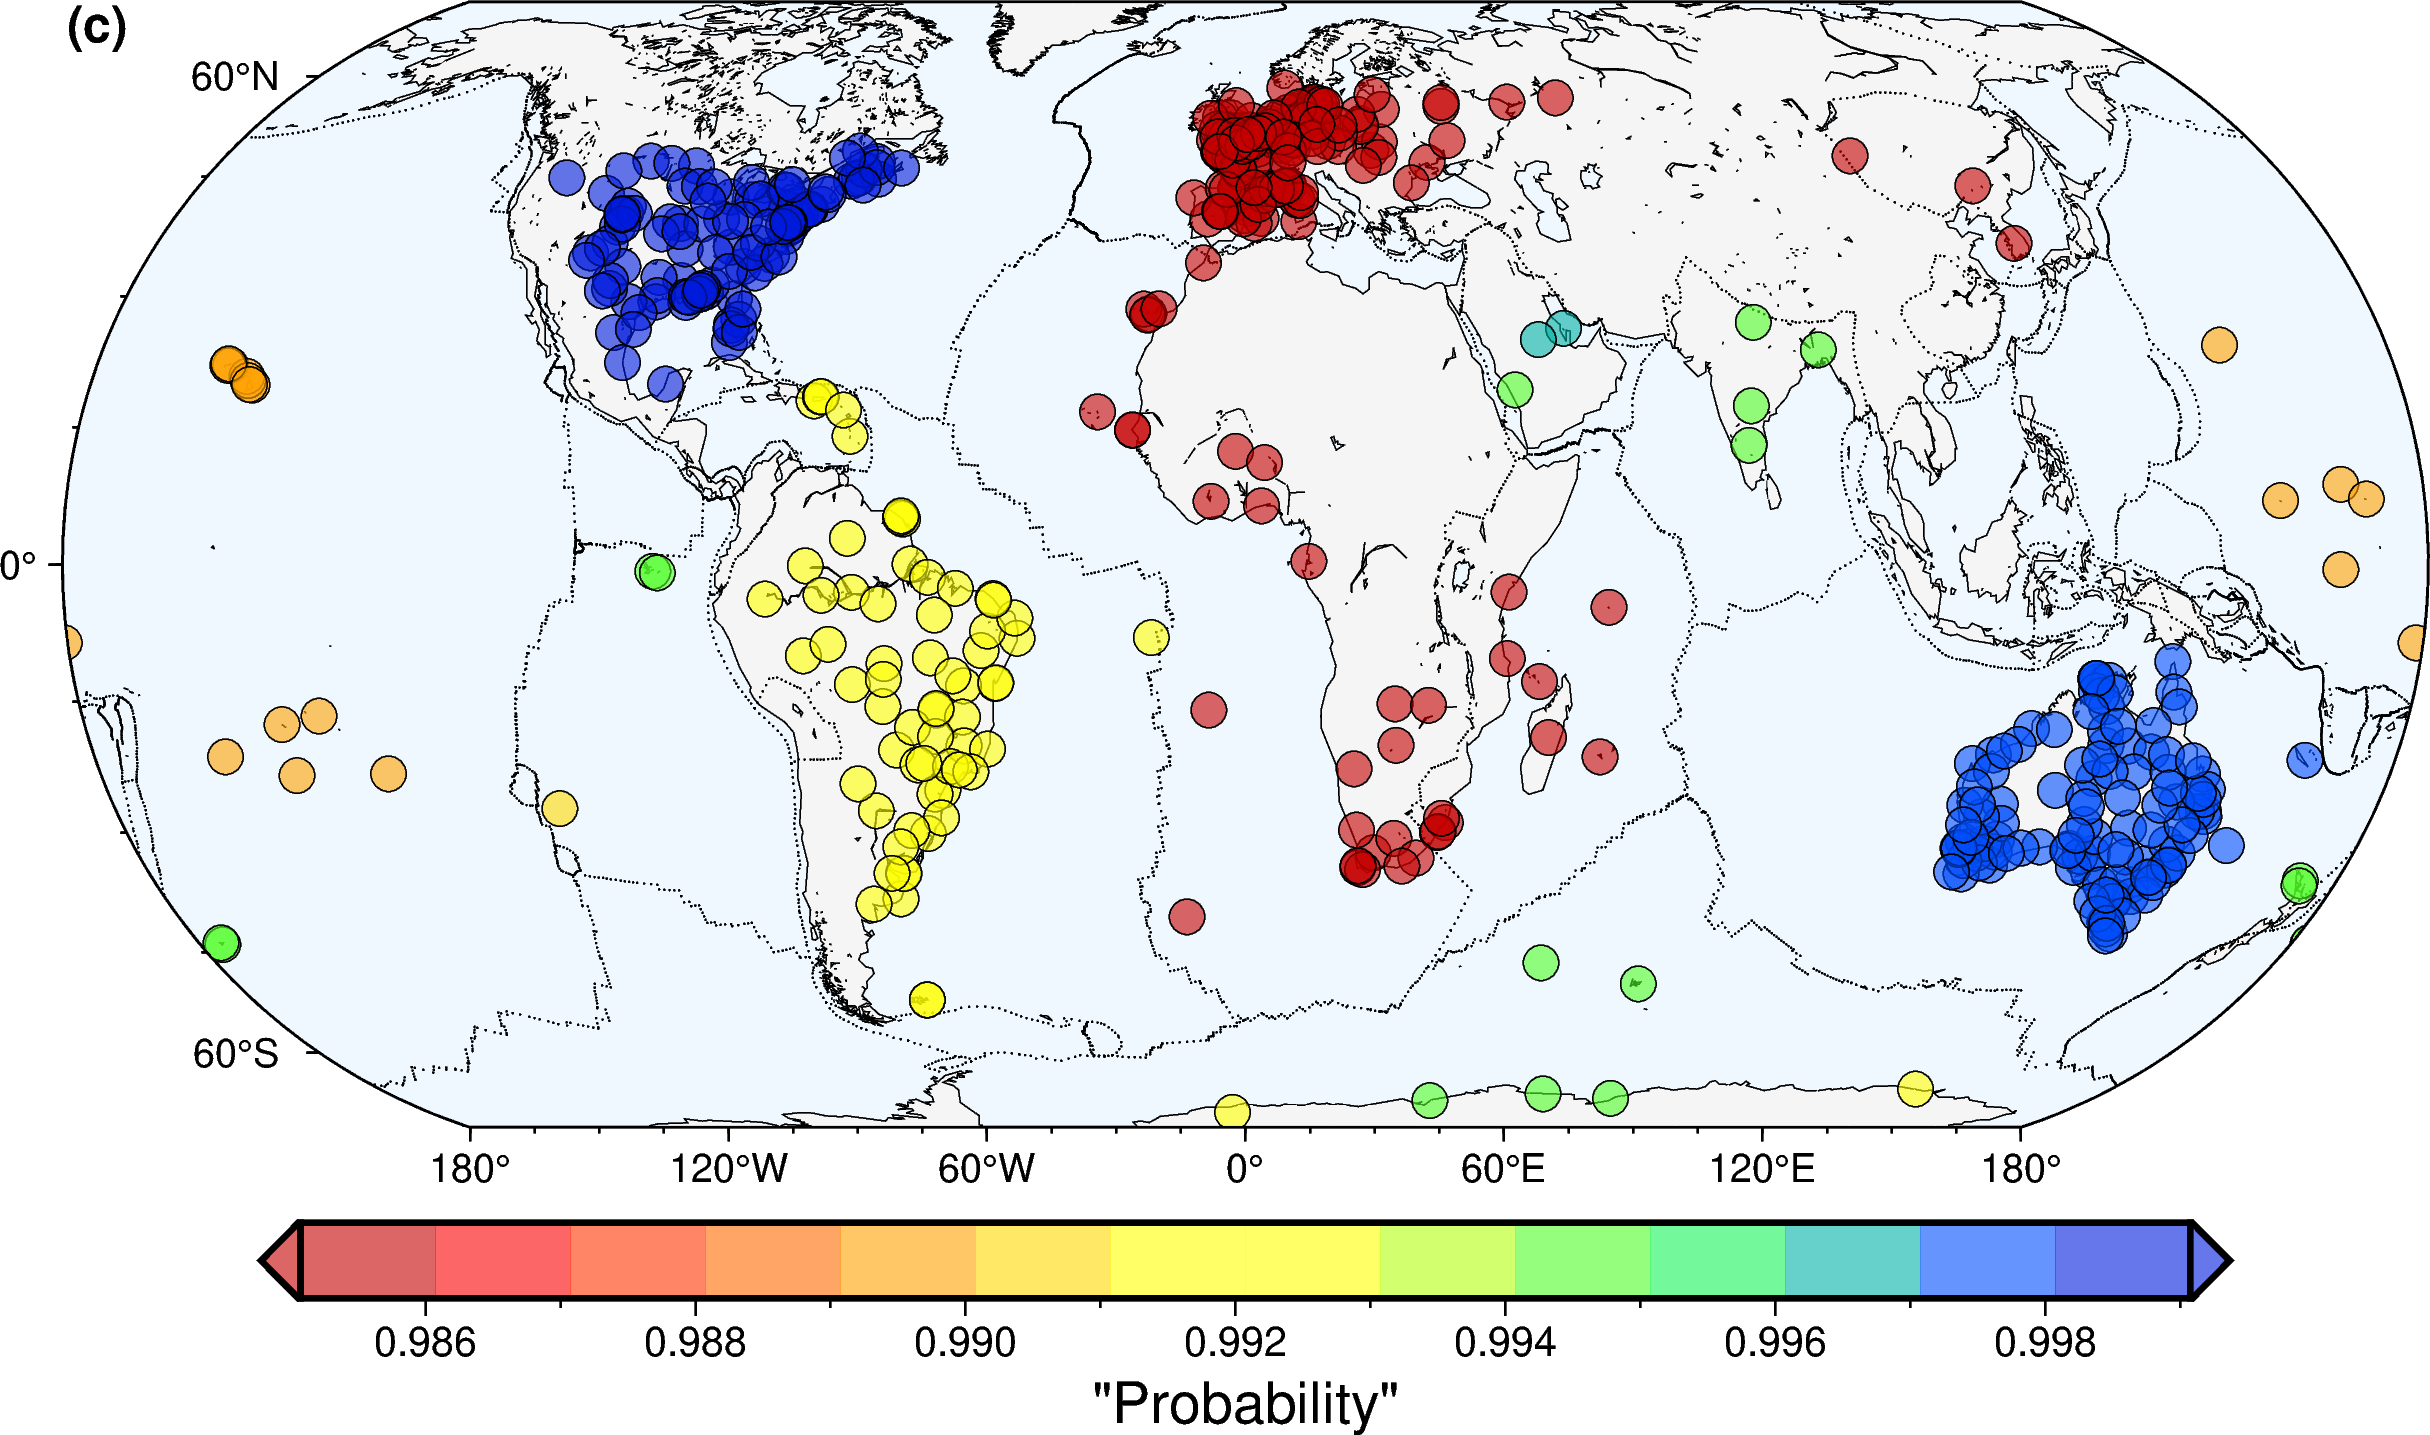

In [ ]:
fig = pygmt.Figure()
pygmt.config(MAP_FRAME_TYPE="plain")
fig.basemap(region=[-180,180,-75,75],
  projection="Kf20c", zsize=20,frame=True
)

fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(cluster_K_ITRF2020_loo_prob), max(cluster_K_ITRF2020_loo_prob), 0.001],
    background=True,
    continuous=False,
    transparency=40
)



fig.plot(
    x=knownborders_array[:,0],
    y=knownborders_array[:,1],
    style="c0.01c", fill="black", pen="black"
)


#print(clusters_K)
for i in range(num_of_stations_ITRF2020):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=ITRF2020_vec["lon"][i],
        y=ITRF2020_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=cluster_K_ITRF2020_loo_prob[clusters_K_ITRF2020[i]-1],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Probability"'],
)


fig.text(text="(c)                                              ", x=-180, y=70, font="12p,Helvetica-Bold,black")

fig.show(width=1000)

# Case study for Taiwan data

Our second experiment evaluates the effectiveness of the proposed method on a local scale.
The method is applied to GNSS data for Taiwan to examine the clustering results of a previous study (Takahashi et al., 2019).  We used the same secular motion data spanning from 2007 to 2013 from 281 continuously monitored GNSS sites, as published by Tsai et al. (2015). These sites were operated by the Central Weather Bureau, the Institute of Earth Science of Academia Sinica, and the Central Geological Survey. Prior to conducting the time series analysis, outliers were removed using a standard deviation (SD) threshold (set at 3.5 times the normal SD) and a moving average approach with a 30-day window, shifting every 10~days. Subsequently, the secular velocity of each GNSS site was determined from the positional time series data by applying the model proposed by Nikolaidis (2002), which distinguishes between seasonal and secular components.

- Nikolaidis, R. (2002). Observation of geodetic and seismic deformation with the Global Positioning System. University of California, San Diego.
- Takahashi, A., Hashimoto, M., Hu, J.-C., Takeuchi, K., Tsai, M.-C., & Fukahata, Y. (2019). Hierarchical cluster analysis of dense GPS data and examination of the nature of the clusters associated with regional tectonics in Taiwan. Journal of Geophysical Research: Solid Earth, 124 (5), 5174–5191.
- Tsai, M.-C., Yu, S.-B., Shin, T.-C., Kuo, K.-W., Leu, P.-L., Chang, C.-H., & Ho, M.-Y. (2015). Velocity field derived from Taiwan continuous GPS array (2007–2013). Terrestrial, Atmospheric & Oceanic Sciences, 26 (5).

In [ ]:
def read_fault_data(filepath):
    # Read the file content
    with open(filepath, 'r') as file:
        data = file.read()

    # Split data by '>' to separate different location segments
    segments = data.split('>')

    # Prepare an array to hold all locations
    faultlines = []

    # Process each segment
    for segment in segments:
        faultline = []
        # Skip empty segments
        if not segment.strip():
            continue

        # Split segment into lines
        lines = segment.strip().split('\n')

        # Extract coordinates from each line and add to the locations array
        for line in lines:
            if line.strip():  # check for any empty lines
                x, y = line.split()
                faultline.append((float(x), float(y)))
        #print(len(faultline))
        faultlines.append(faultline)

    return faultlines

filepath = FILEPATH+'Taiwan_AFs/new_Category_1.txt'
locdata = read_fault_data(filepath)
c1_afaults_srftrcs=locdata
filepath = FILEPATH+'Taiwan_AFs/new_Category_1_concealed.txt'
locdata = read_fault_data(filepath)
c1_afaults_srftrcs=c1_afaults_srftrcs+locdata
filepath = FILEPATH+'Taiwan_AFs/new_Category_2.txt'
locdata = read_fault_data(filepath)
c2_afaults_srftrcs=locdata
filepath = FILEPATH+'Taiwan_AFs/new_Category_2_concealed.txt'
locdata = read_fault_data(filepath)
c2_afaults_srftrcs=c2_afaults_srftrcs+locdata

In [ ]:
Taiwan_vec=pd.read_csv(FILEPATH+'TYK_Taiwan_data.csv')

In [ ]:
num_of_stations_Taiwan = len(Taiwan_vec["Lat"])

Taiwan_vec["lon"]=Taiwan_vec["Lon"].astype(float)
Taiwan_vec["lat"]=Taiwan_vec["Lat"].astype(float)

Taiwan_vec["northward"]=Taiwan_vec["Vn_wrt_S01R"].astype(float)
Taiwan_vec["eastward"]=Taiwan_vec["Ve_wrt_S01R"].astype(float)

Taiwan_vec["x"]=0.
Taiwan_vec["y"]=0.
Taiwan_vec["z"]=0.
Taiwan_vec["v_x"]=0.
Taiwan_vec["v_y"]=0.
Taiwan_vec["v_z"]=0.
Taiwan_vec["KnownCluster"]="A"
for i in range(num_of_stations_Taiwan):
  lat = Taiwan_vec["lat"][i]*(np.pi/180)
  lon = Taiwan_vec["lon"][i]*(np.pi/180)
  tangentrep = tangential_representation(lat,lon)
  x,y,z=tangentrep[0]
  e_vlat=tangentrep[1]
  e_vlon=tangentrep[2]
  vlat = 1.0*Taiwan_vec["northward"][i] * e_vlat
  vlon = 1.0*Taiwan_vec["eastward"][i] * e_vlon
  v = vlat+vlon

  Taiwan_vec.at[i,"x"]=x
  Taiwan_vec.at[i,"y"]=y
  Taiwan_vec.at[i,"z"]=z
  Taiwan_vec.at[i,"v_x"]=v[0]
  Taiwan_vec.at[i,"v_y"]=v[1]
  Taiwan_vec.at[i,"v_z"]=v[2]
  Taiwan_vec.at[i,"KnownCluster"]=Taiwan_vec.at[i,"ClusterLabelK11_Takahashietal2019"]


bundle_array_Taiwan = np.array([(Taiwan_vec.loc[i,["x","y","z"]].astype(float),Taiwan_vec.loc[i,["v_x","v_y","v_z"]].astype(float)) for i in range(num_of_stations_Taiwan)])


vel_array_Taiwan = np.array([
    np.hstack((Taiwan_vec.loc[i,["x","y","z"]].astype(float).values,
                             Taiwan_vec.loc[i,["Ve_wrt_S01R","Vn_wrt_S01R"]].astype(float).values))
                          for i in range(num_of_stations_Taiwan)])

**Similarity metric computation**

In [ ]:
EVfit_distmat_Taiwan = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
PTEuc_distmat_Taiwan = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
for i in range(num_of_stations_Taiwan):
  for j in range(i+1,num_of_stations_Taiwan):
    EVfit_distmat_Taiwan[i,j]=EVfit_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j])
    EVfit_distmat_Taiwan[j,i]=EVfit_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j])
    PTEuc_distmat_Taiwan[i,j]=PTEuc_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j])
    PTEuc_distmat_Taiwan[j,i]=PTEuc_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j])

EVPTfit_distmat_Taiwan = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
for i in range(num_of_stations_Taiwan):
  for j in range(i+1,num_of_stations_Taiwan):
    EVPTfit_distmat_Taiwan[i,j]=combinedEVPTfit_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j],alpha=np.array([1,1]))
    EVPTfit_distmat_Taiwan[j,i]=combinedEVPTfit_distance(bundle_start=bundle_array_Taiwan[i],bundle_end=bundle_array_Taiwan[j],alpha=np.array([1,1]))

Vel_distmat_Taiwan = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
for i in range(num_of_stations_Taiwan):
  for j in range(i+1,num_of_stations_Taiwan):
    Vel_distmat_Taiwan[i,j]=np.sqrt(np.sum((vel_array_Taiwan[i][[3,4]]-vel_array_Taiwan[j][[3,4]])**2))
    Vel_distmat_Taiwan[j,i]=np.sqrt(np.sum((vel_array_Taiwan[i][[3,4]]-vel_array_Taiwan[j][[3,4]])**2))

**Hierarchical Agglomerative Clustering**

In [ ]:
method="average"

pdistform_Taiwan_EVPT = squareform(EVPTfit_distmat_Taiwan)
pdistform_Taiwan_PT = squareform(PTEuc_distmat_Taiwan)
pdistform_Taiwan_EV = squareform(EVfit_distmat_Taiwan)
pdistform_Taiwan_Vel = squareform(Vel_distmat_Taiwan)

clusters_Taiwan_EVPT = shc.linkage(pdistform_Taiwan_EVPT,method=method)
clusters_Taiwan_PT = shc.linkage(pdistform_Taiwan_PT,method=method)
clusters_Taiwan_EV = shc.linkage(pdistform_Taiwan_EV,method=method)
clusters_Taiwan_Vel = shc.linkage(pdistform_Taiwan_Vel,method=method)

**Dendrogram of the clustering result**

Text(0, 0.5, 'EVPT metric value')

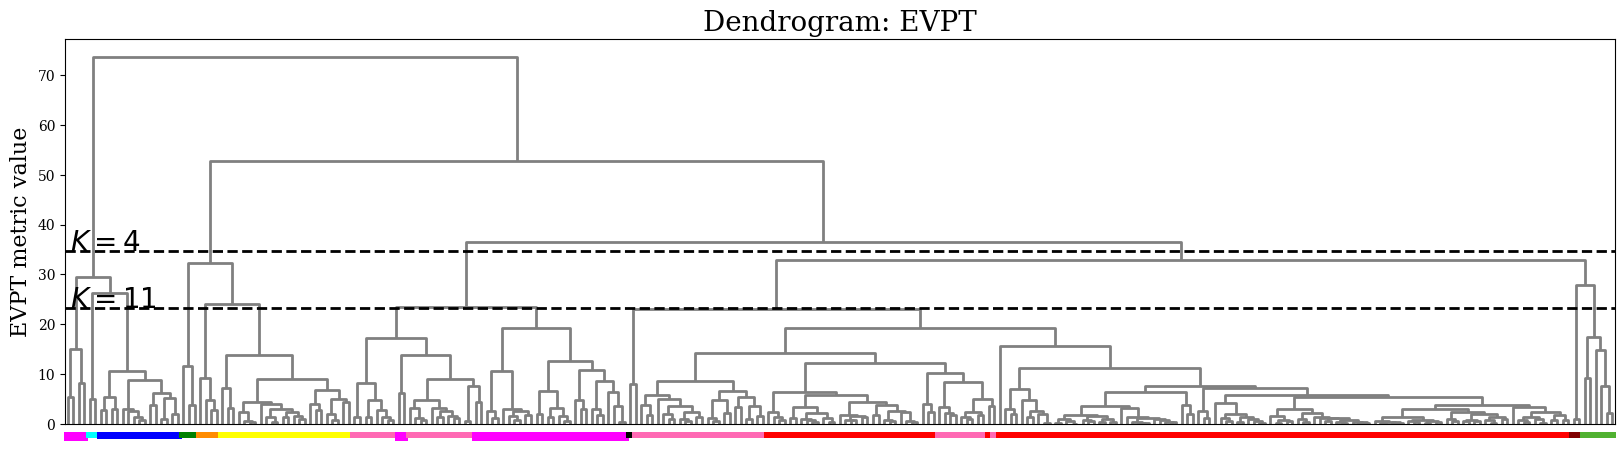

In [ ]:
distchange="EVPT"

if distchange=="EVPT":
  HAC_Taiwan = shc.linkage(pdistform_Taiwan_EVPT,method=method)
elif distchange=="PT":
  HAC_Taiwan = shc.linkage(pdistform_Taiwan_PT,method=method)
elif distchange=="EV":
  HAC_Taiwan = shc.linkage(pdistform_Taiwan_EV,method=method)
elif distchange=="Vel":
  HAC_Taiwan = shc.linkage(pdistform_Taiwan_Vel,method=method)


fig, ax = plt.subplots(figsize=(20, 5))
dn = shc.dendrogram(HAC_Taiwan,orientation='top',labels=list(Taiwan_vec["KnownCluster"]),
                    leaf_font_size=3,color_threshold=100,link_color_func=color_func)

colorlist_tw = ['#000000','#800000','#00ffff','#ff8c00','#0000ff','#008000','#ffff00','#ff0000','#ff69b4','#50b131','#ff00ff']
for t in ax.get_xticklabels():
    txt = t.get_text()
    t.set_color(colorlist_tw[int(txt)])
    t.set_bbox(dict(facecolor=colorlist_tw[int(txt)],boxstyle='square,pad=0.5', edgecolor='none', alpha=1.0))


plt.title("Dendrogram: "+distchange,fontsize=20)
#get height for K=4
K=4
height_4=(HAC_Taiwan[:,2][-K]+HAC_Taiwan[:,2][-(K-1)])/2
#get height for K=11
K=11
height_11=(HAC_Taiwan[:,2][-K]+HAC_Taiwan[:,2][-(K-1)])/2
ax.axhline(y=height_4, color='k', linestyle='--')
ax.text(x=10,y=height_4,s=r"$K=4$",fontsize=20)
ax.axhline(y=height_11, color='k', linestyle='--')
ax.text(x=10,y=height_11,s=r"$K=11$",fontsize=20)
ax.set_ylabel(distchange+" metric value",fontsize=16)

**Map view of clustering results**

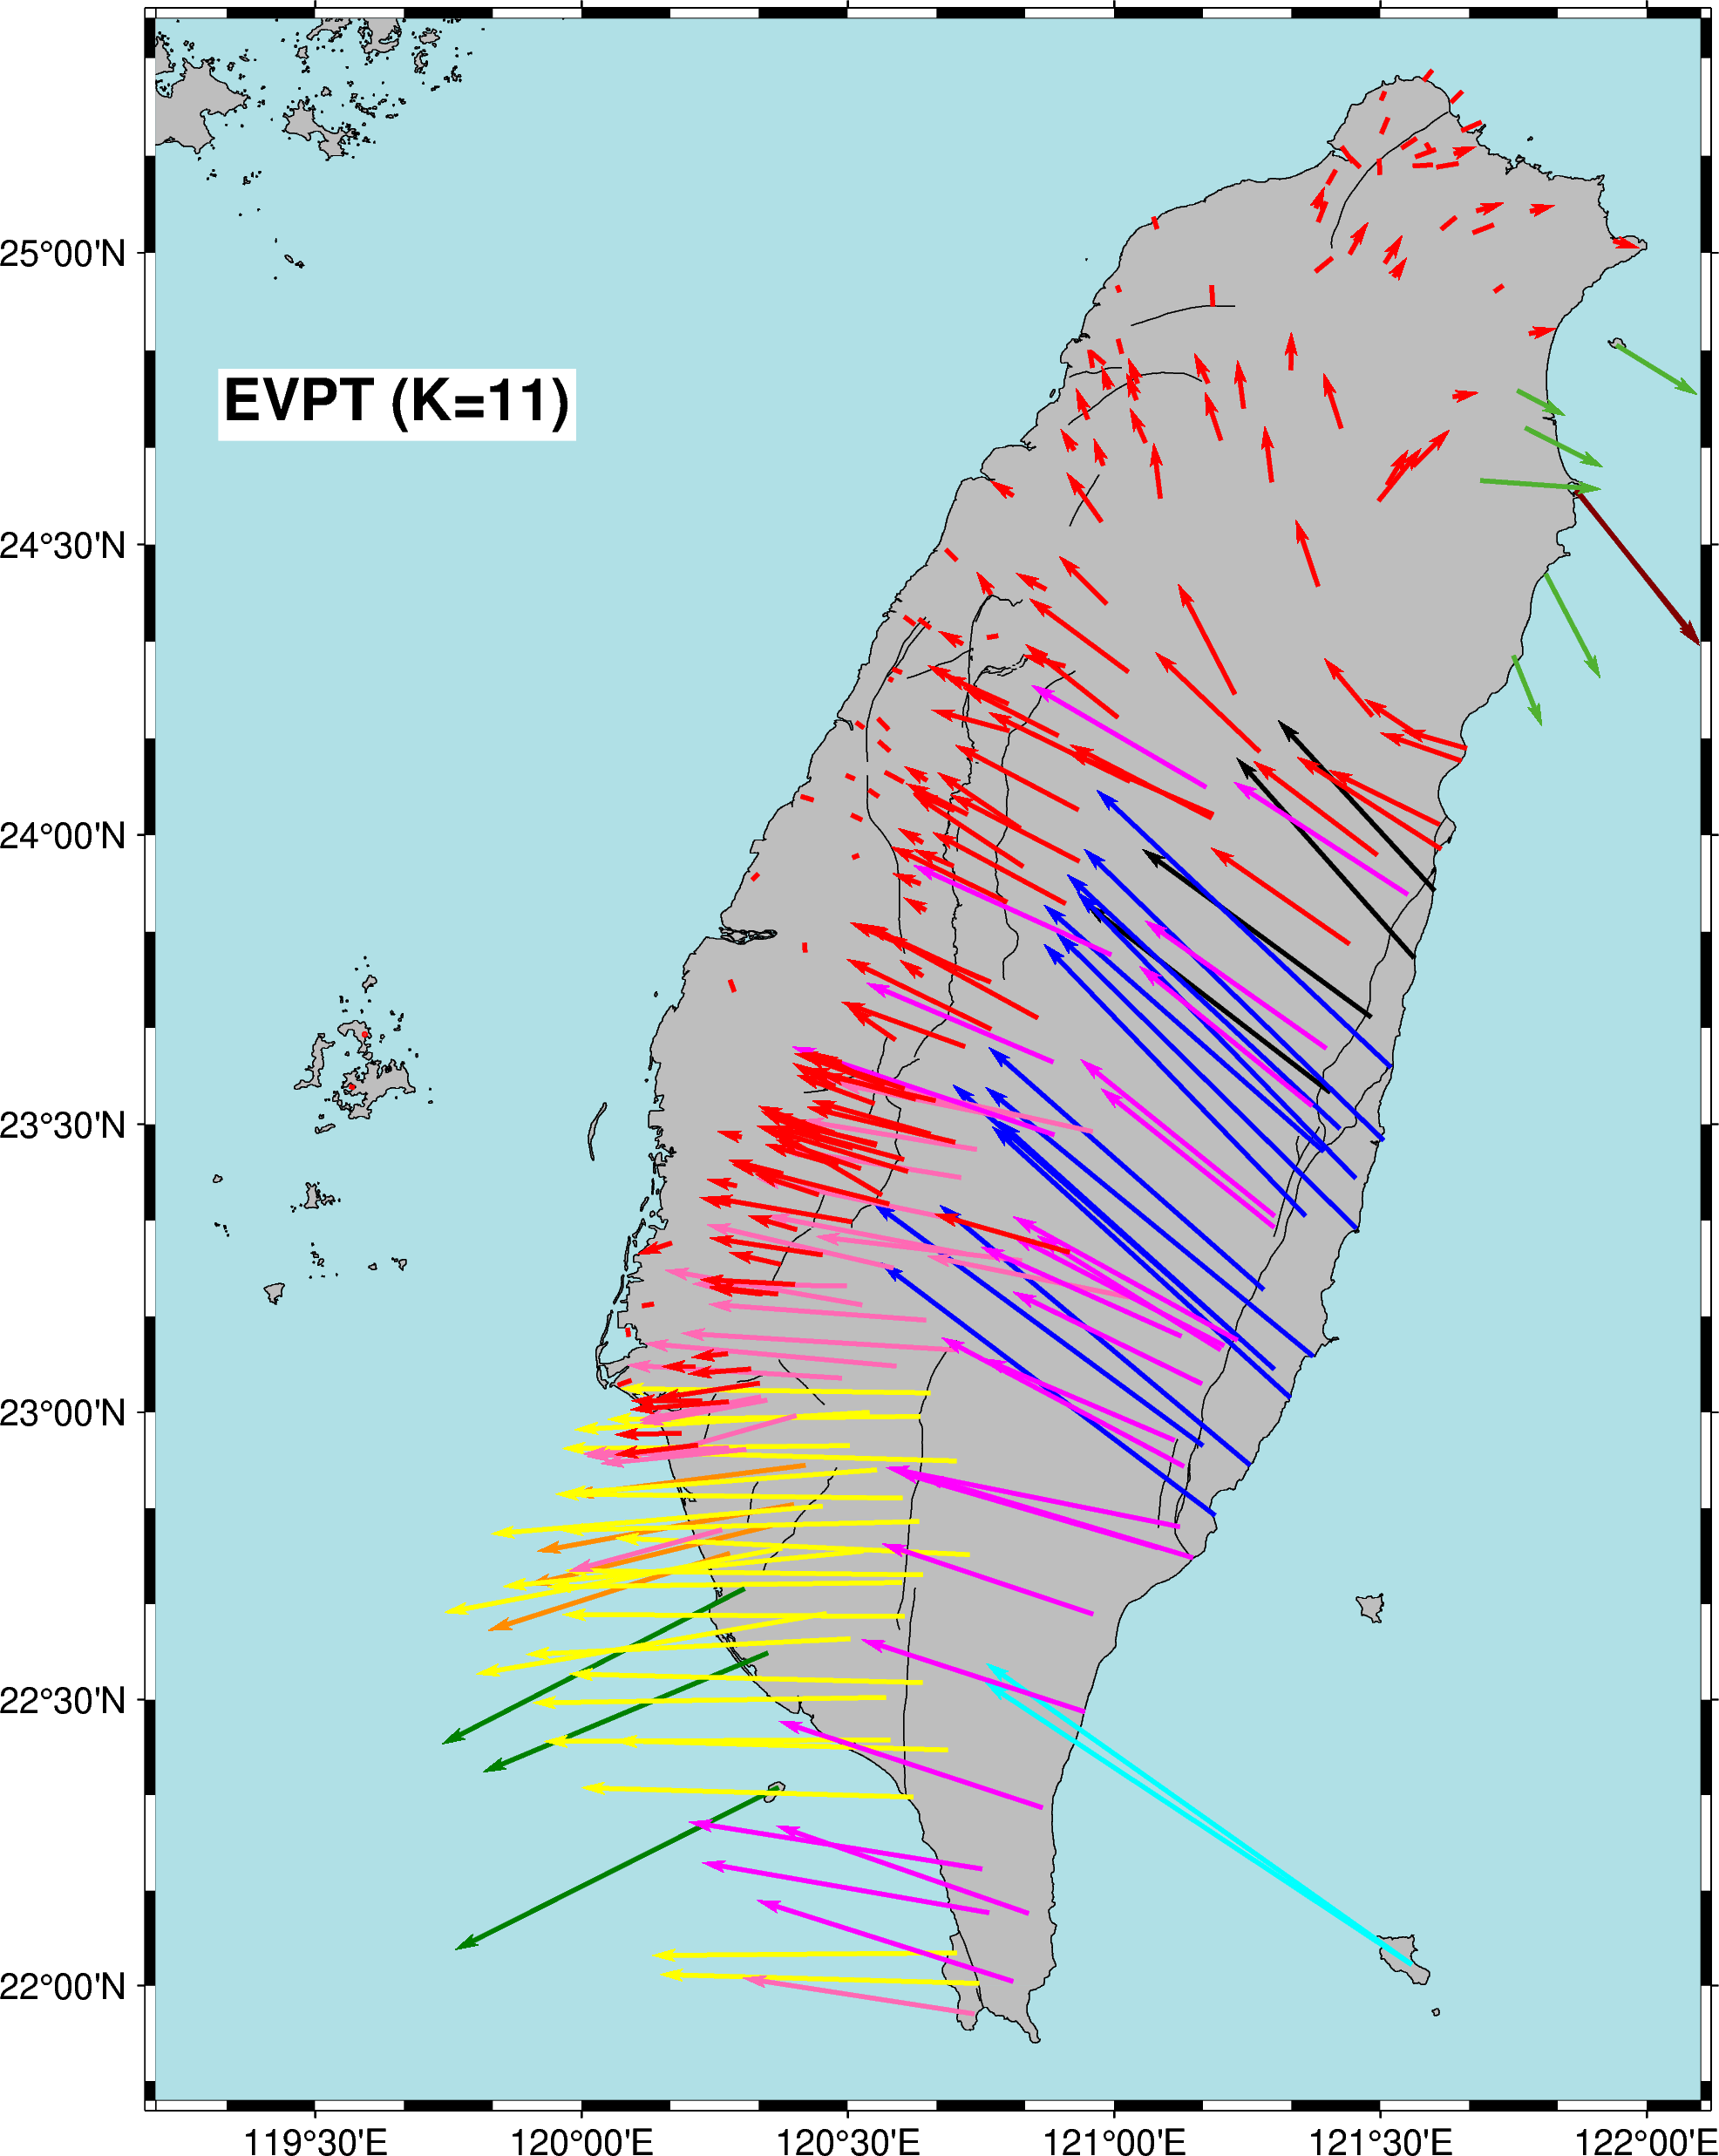

In [ ]:
#EVPT result
distchange="EVPT"

K=11
if distchange=="EVPT":
  clusters_K11_Taiwan = fcluster(clusters_Taiwan_EVPT, t=K, criterion='maxclust')
elif distchange=="PT":
  clusters_K11_Taiwan = fcluster(clusters_Taiwan_PT, t=K, criterion='maxclust')
elif distchange=="EV":
  clusters_K11_Taiwan = fcluster(clusters_Taiwan_EV, t=K, criterion='maxclust')
elif distchange=="Vel":
  clusters_K11_Taiwan = fcluster(clusters_Taiwan_Vel, t=K, criterion='maxclust')
colorlist_tw_11 = ['#000000','#00ffff','#0000ff','#008000','#ff8c00','#ffff00','#ff69b4','#ff00ff','#ff0000','#800000','#50b131']

scale_p_tw = 3.0

df_K = pd.DataFrame(
    data={
        "x": Taiwan_vec["lon"],
        "y": Taiwan_vec["lat"],
        "east_velocity": scale_p_tw*Taiwan_vec["Ve_wrt_S01R"],
        "north_velocity": scale_p_tw*Taiwan_vec["Vn_wrt_S01R"],
        "east_sigma": 0,
        "north_sigma": 0,
        "correlation_EN": 0,
        "SITE": clusters_K11_Taiwan
    }
)

fig = pygmt.Figure()
fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="grey", water="powderblue",
  shorelines=True)
for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )


for k in range(1,12):
  fig.velo(data=df_K[df_K["SITE"]==k],
           vector="0.22c+p1p,"+colorlist_tw_11[k-1]+"+e+g"+colorlist_tw_11[k-1],
           pen="1.2p,"+colorlist_tw_11[k-1],spec="e0.02/0.05/0.1")
fig.text(text="          "+distchange+" (K=11)", x=119.5, y=24.75, font="16p,Helvetica-Bold,black",fill="white")
fig.show()

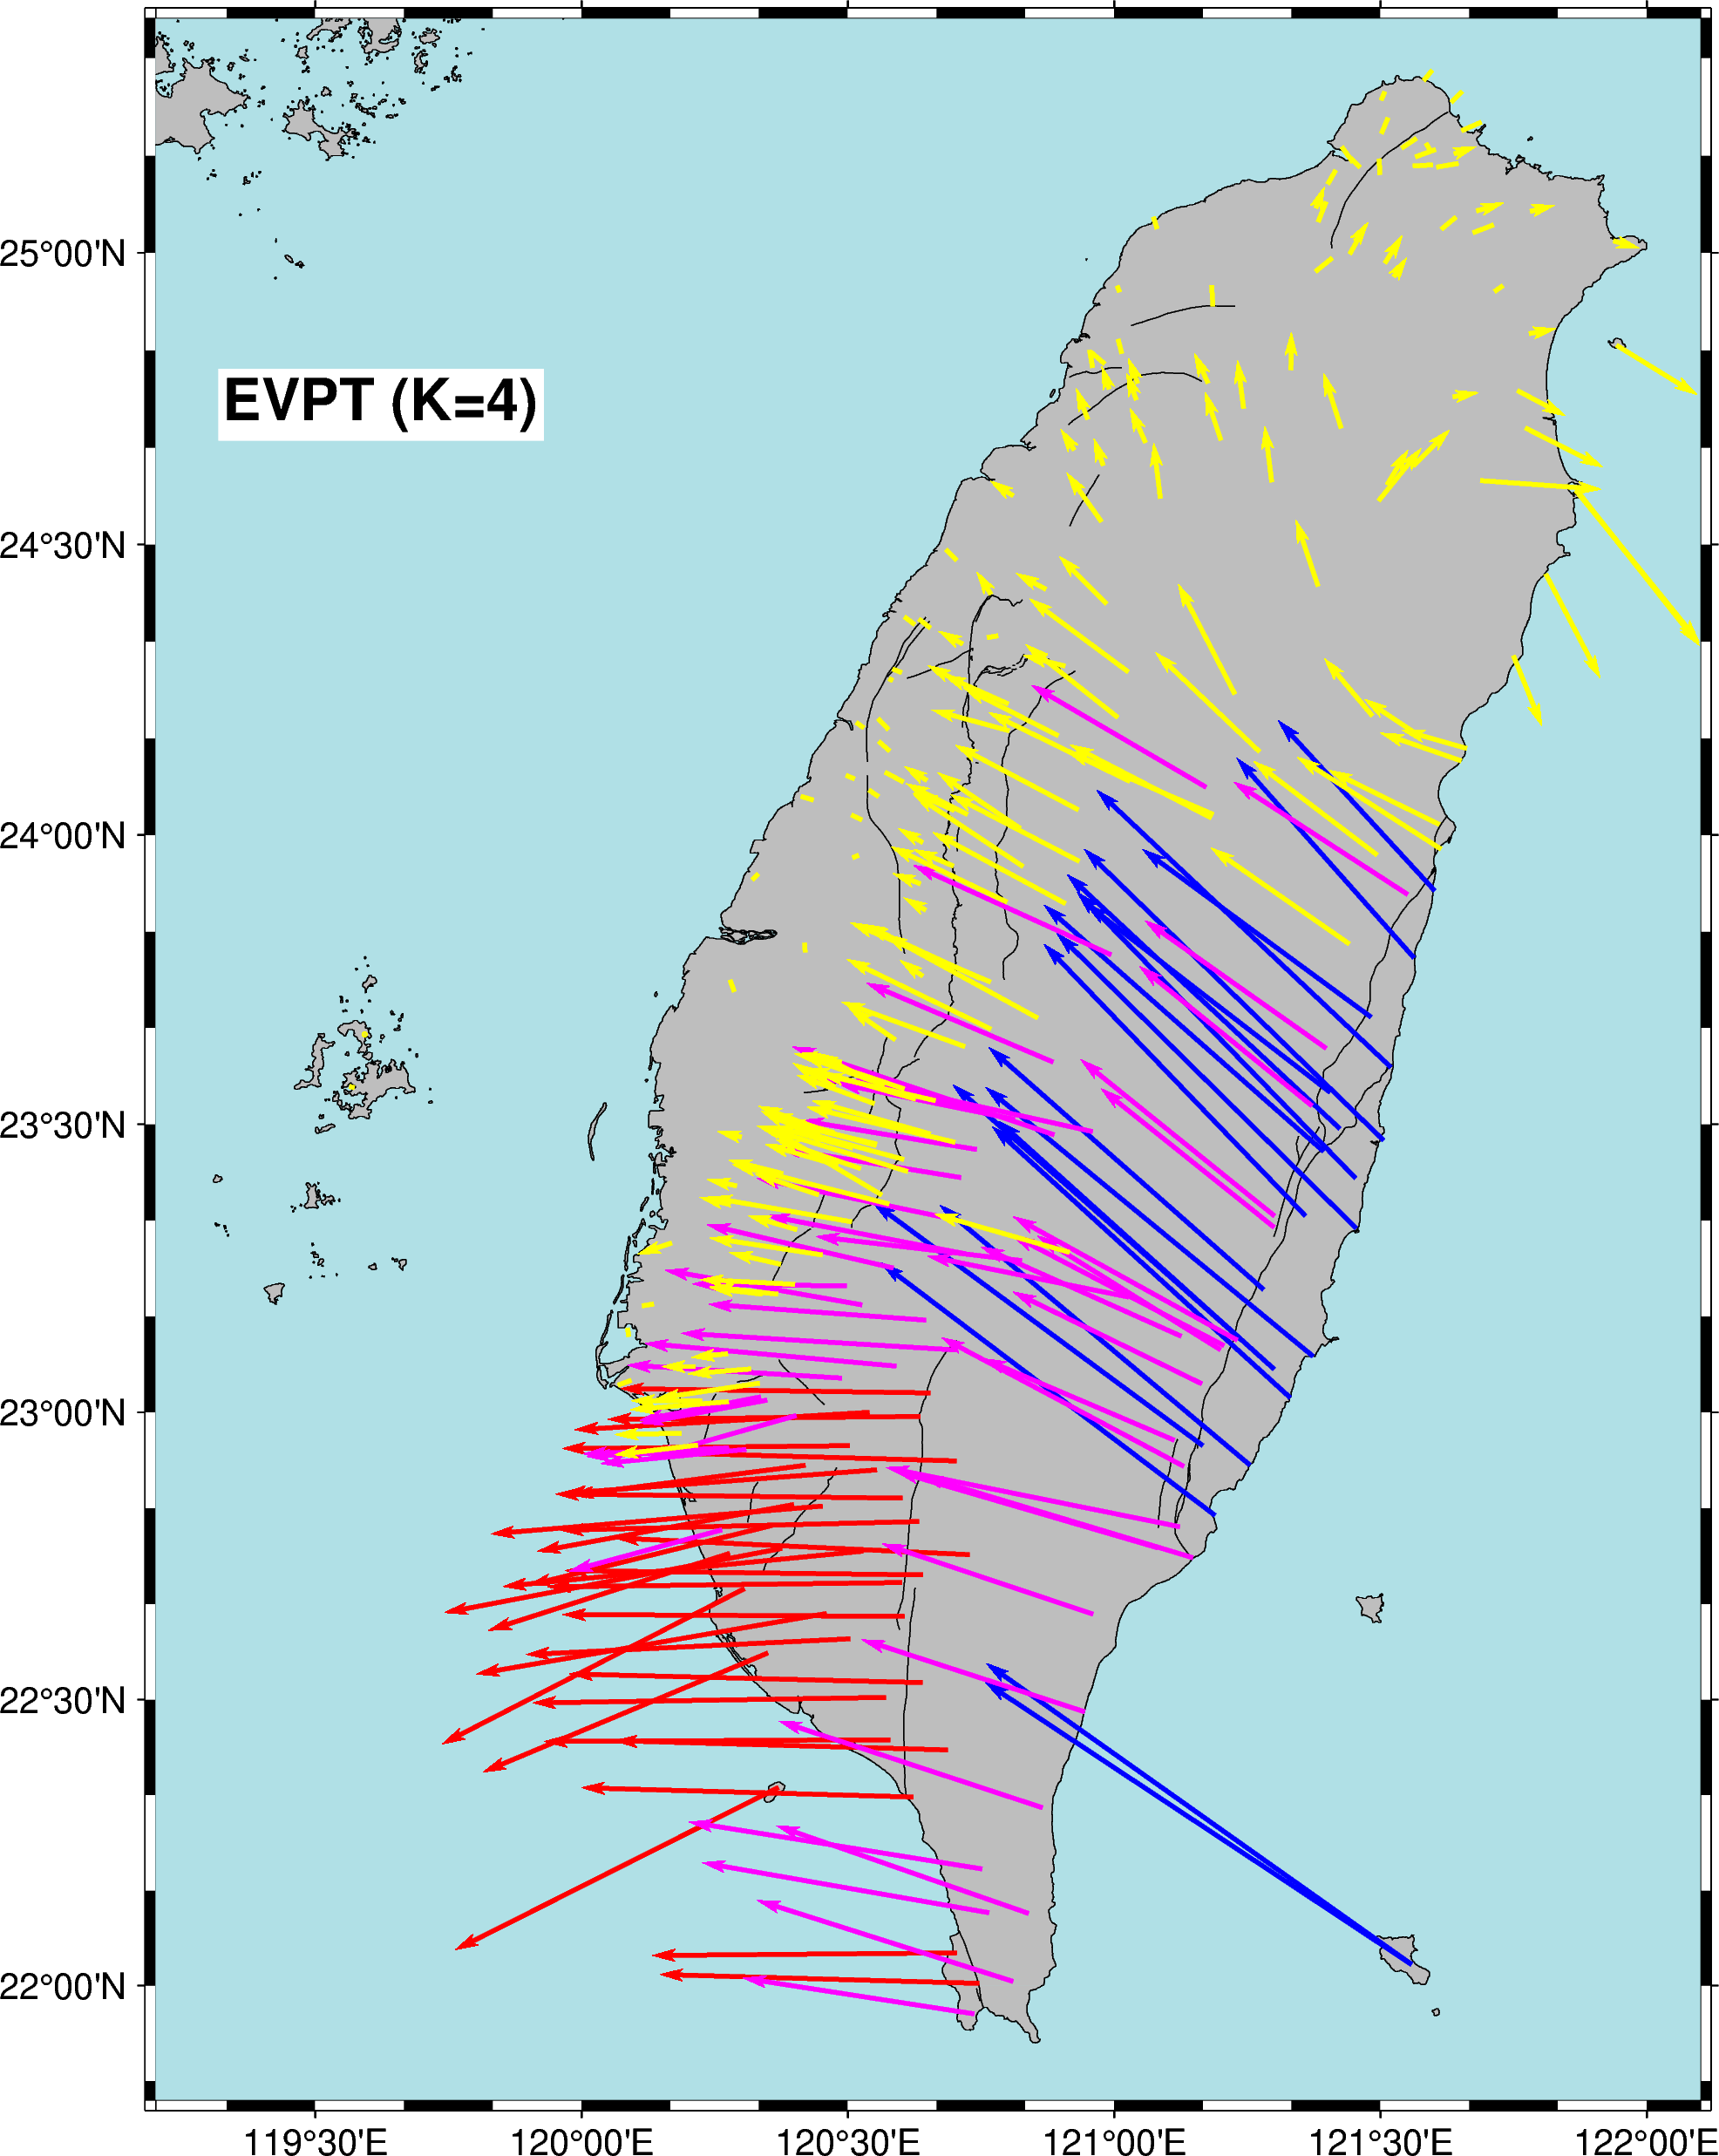

In [ ]:
#EVPT result with K=4

K=4
distchange=="EVPT"

if distchange=="EVPT":
  clusters_K4 = fcluster(clusters_Taiwan_EVPT, t=K, criterion='maxclust')
elif distchange=="PT":
  clusters_K4 = fcluster(clusters_Taiwan_PT, t=K, criterion='maxclust')
elif distchange=="EV":
  clusters_K4 = fcluster(clusters_Taiwan_EV, t=K, criterion='maxclust')
elif distchange=="Vel":
  clusters_K4 = fcluster(clusters_Taiwan_Vel, t=K, criterion='maxclust')
colorlist_tw_K4 = ['#0000ff','#ff0000','#ff00ff','#ffff00']


scale_p_tw = 3.0

df_K = pd.DataFrame(
    data={
        "x": Taiwan_vec["lon"],
        "y": Taiwan_vec["lat"],
        "east_velocity": scale_p_tw*Taiwan_vec["Ve_wrt_S01R"],
        "north_velocity": scale_p_tw*Taiwan_vec["Vn_wrt_S01R"],
        "east_sigma": 0,
        "north_sigma": 0,
        "correlation_EN": 0,
        "SITE": clusters_K4
    }
)


fig = pygmt.Figure()
fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="grey", water="powderblue",
  shorelines=True)
for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )


for k in range(1,5):
  fig.velo(data=df_K[df_K["SITE"]==k],
           vector="0.22c+p1p,"+colorlist_tw_K4[k-1]+"+e+g"+colorlist_tw_K4[k-1],
           pen="1.2p,"+colorlist_tw_K4[k-1],spec="e0.02/0.05/0.1")
fig.text(text="        "+ distchange +" (K=4)", x=119.5, y=24.75, font="16p,Helvetica-Bold,black",fill="white")
fig.show()

**Stability test with leave-one-out**

In [ ]:
K=11
method="average"
distchange="EVPT"


leaveout_result = []


for leaveout_index in range(num_of_stations_Taiwan):
  safe_indices = [j for j in range(num_of_stations_Taiwan) if j != leaveout_index ]
  pdistform_Taiwan_tmp = squareform(EVPTfit_distmat_Taiwan[safe_indices][:,safe_indices])
  clusters_Taiwan_tmp = shc.linkage(pdistform_Taiwan_tmp,
            method=method)
  tmp=shc.fcluster(clusters_Taiwan_tmp, K, criterion='maxclust').tolist()
  tmp.insert(leaveout_index,K+10)
  leaveout_result.append(np.array(tmp))

if distchange=="EVPT":
  clusters_K_original_TW = fcluster(clusters_Taiwan_EVPT, t=K, criterion='maxclust')
elif distchange=="EV":
  clusters_K_original_TW = fcluster(clusters_Taiwan_EV, t=K, criterion='maxclust')
elif distchange=="PT":
  clusters_K_original_TW = fcluster(clusters_Taiwan_PT, t=K, criterion='maxclust')



loo_adjusted_rand_score = []
for loo in range(num_of_stations_Taiwan):
  exclude_indices = np.array([loo])
  mask = np.ones(len(leaveout_result[loo]), dtype=bool)
  mask[exclude_indices] = False
  loo_adjusted_rand_score.append(adjusted_rand_score(leaveout_result[loo][mask],clusters_K_original_TW[mask]))

loo_probabilities = []
for loo in range(num_of_stations_Taiwan):
  loo_probabilities.append(np.array([ (1. == sum((leaveout_result[loo][np.where(clusters_K_original_TW==k)[0]])/k)/len(np.where(clusters_K_original_TW==k)[0]))
                                    if (loo not in np.where(clusters_K_original_TW==k)[0]) else np.nan for k in range(1,K+1)]))

cluster_K_Taiwan_loo_prob = np.nanmean(np.array(loo_probabilities),axis=0)



sorted_indices_byoriginalTW = sorted_indices(clusters_K_original_TW)
Stability_tensor_Taiwan=np.array([(1.0*np.array([[leaveout_result[k][sorted_indices_byoriginalTW][i]==leaveout_result[k][sorted_indices_byoriginalTW][j]
                                                  for i in range(num_of_stations_Taiwan)] for j in range(num_of_stations_Taiwan)])) for k in range(num_of_stations_Taiwan)])
Rij_Taiwan=Stability_tensor_Taiwan.mean(axis=0)


entropy_TW=np.array([[entropy(Rij_Taiwan[i,j]) for i in range(num_of_stations_Taiwan)] for j in range(num_of_stations_Taiwan)])
entropy_TW_stationwise=entropy_TW.mean(axis=0)

Rk_Taiwan=np.array([np.mean(Stability_tensor_Taiwan[k,:,:].flatten()) for k in range(num_of_stations_Taiwan)])
entropy_TW_leaveone = np.array([entropy(Rk_Taiwan[k]) for k in range(num_of_stations_Taiwan)])

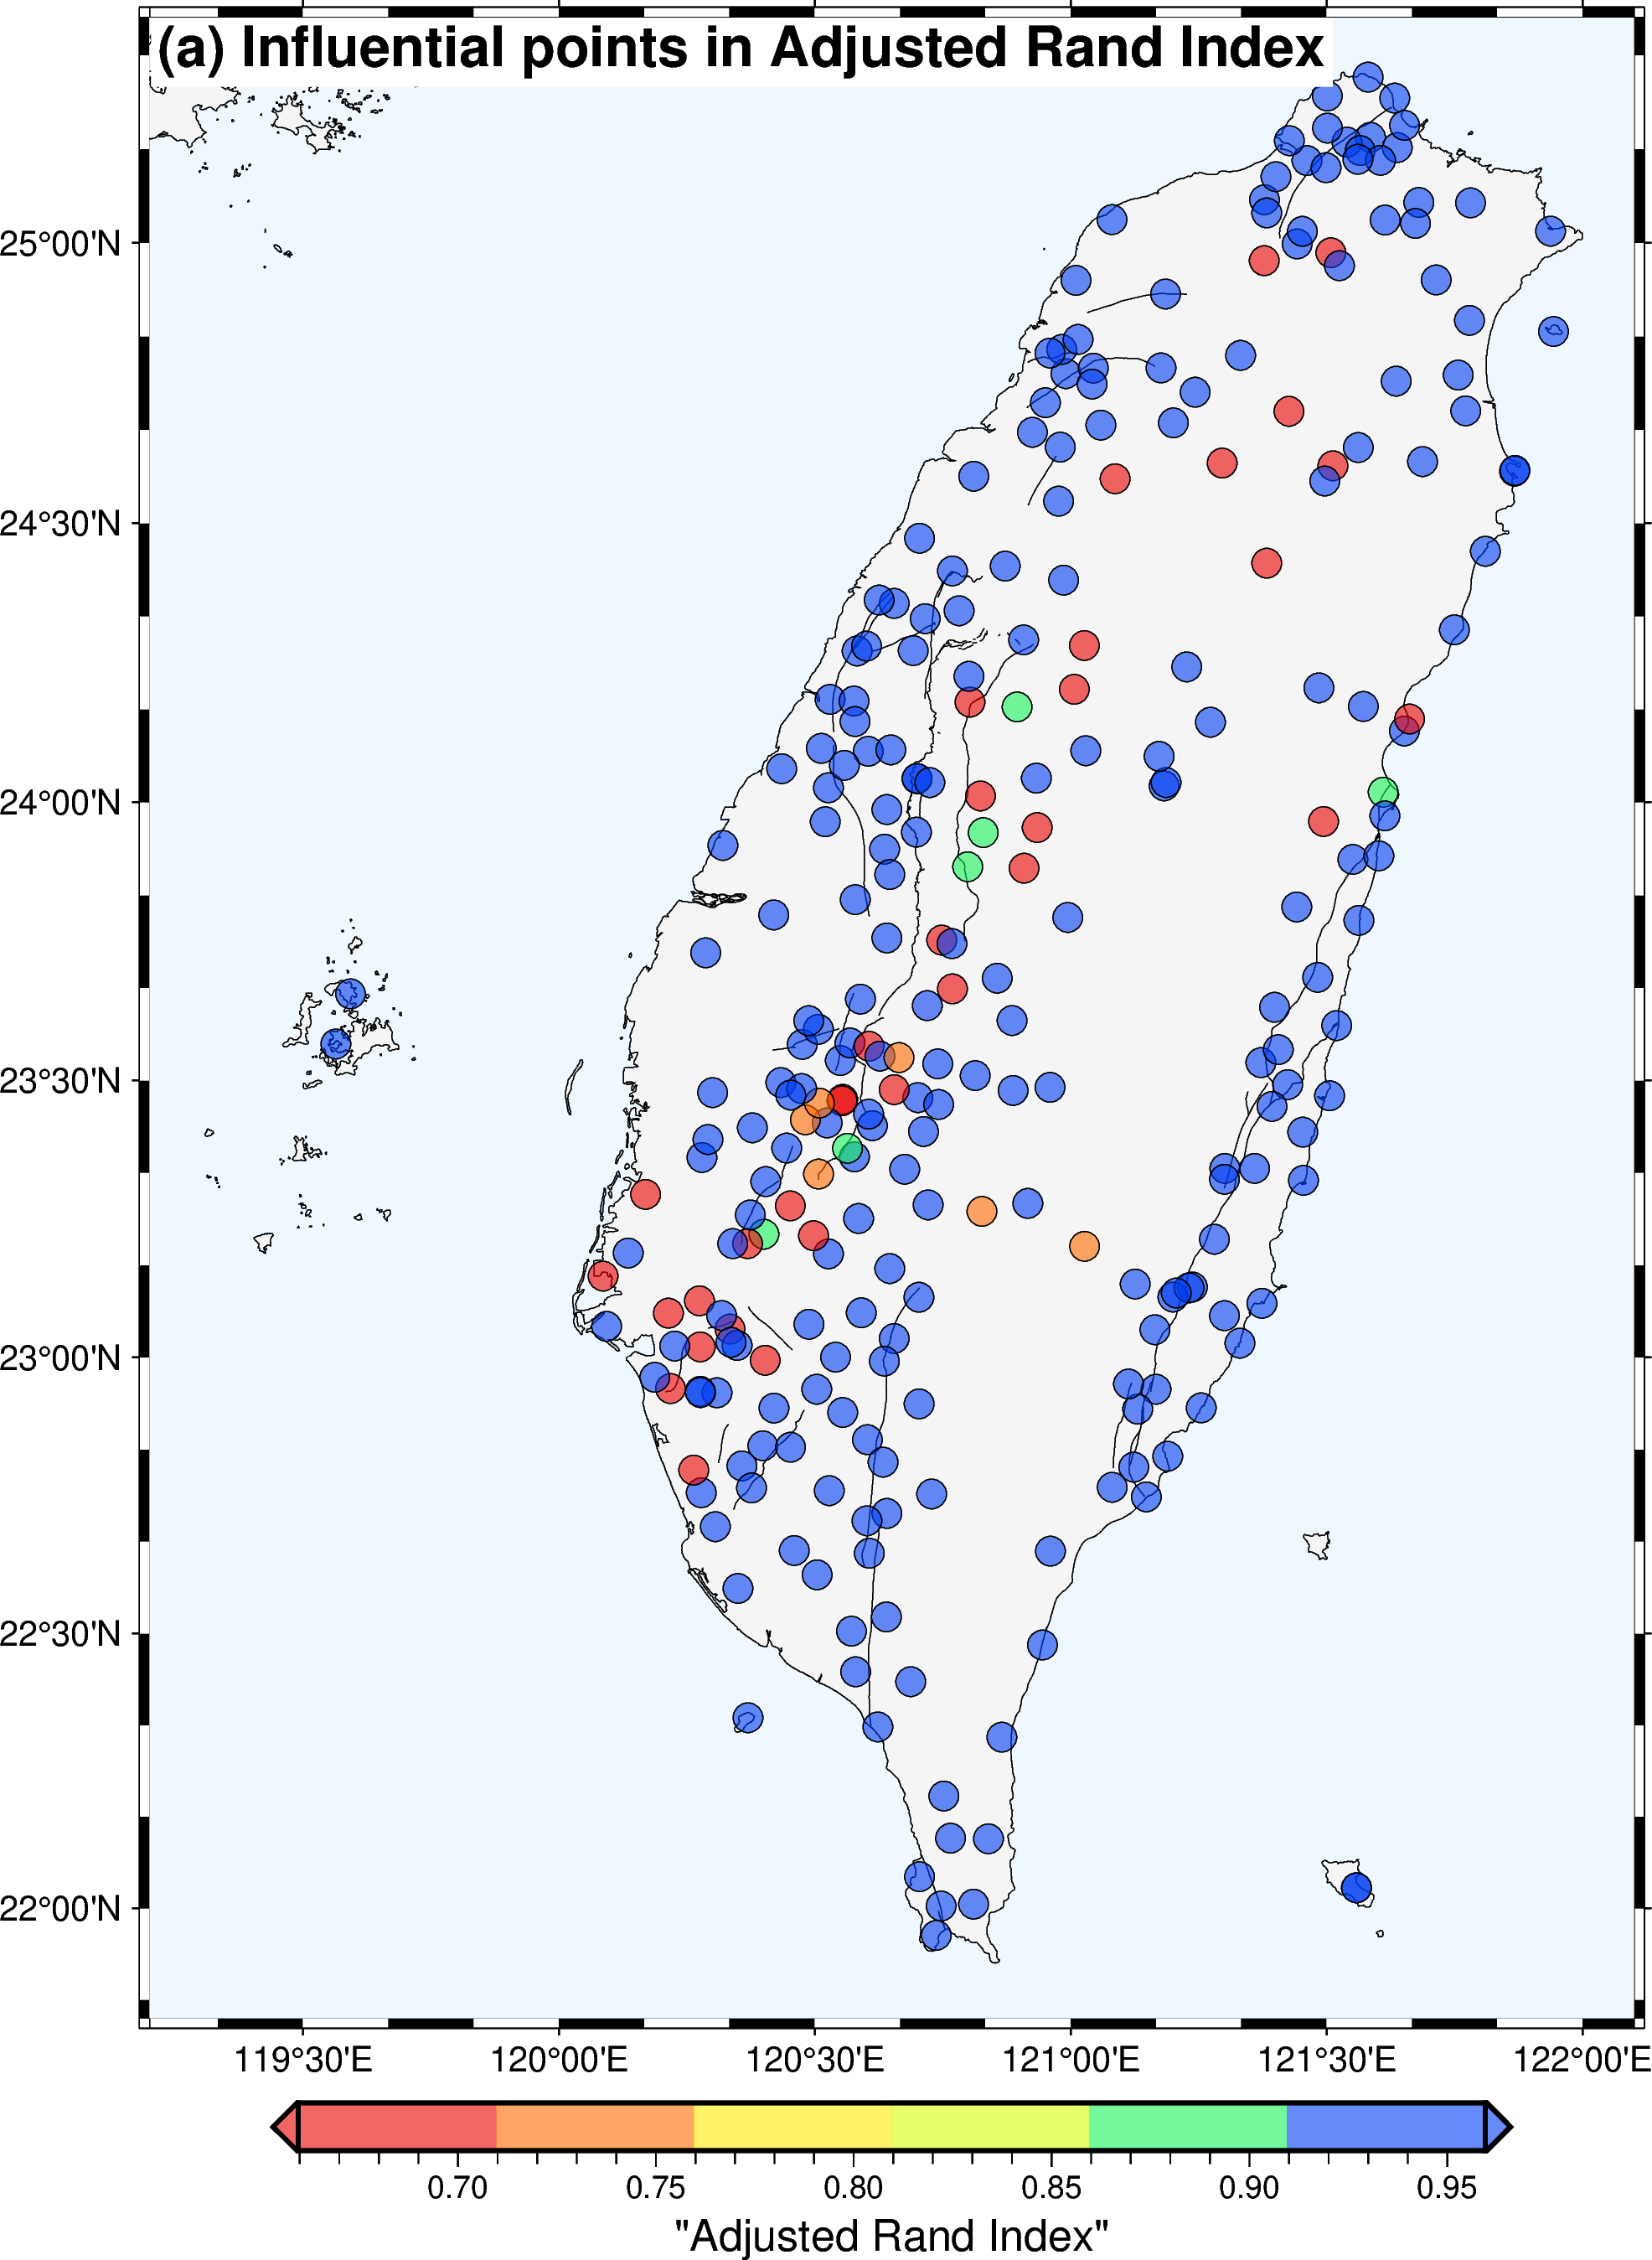

In [ ]:
fig = pygmt.Figure()

fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(loo_adjusted_rand_score), max(loo_adjusted_rand_score), 0.05],
    background=True,
    continuous=False,
    transparency=40
)

for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for i in range(num_of_stations_Taiwan):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=Taiwan_vec["lon"][i],
        y=Taiwan_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=loo_adjusted_rand_score[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Adjusted Rand Index"'],
)


fig.text(text="       (a) Influential points in Adjusted Rand Index", x=120.25, y=25.35, font="16p,Helvetica-Bold,black",fill="white")

fig.show()

#fig.savefig(FILEPATH+"ARI_new.pdf")

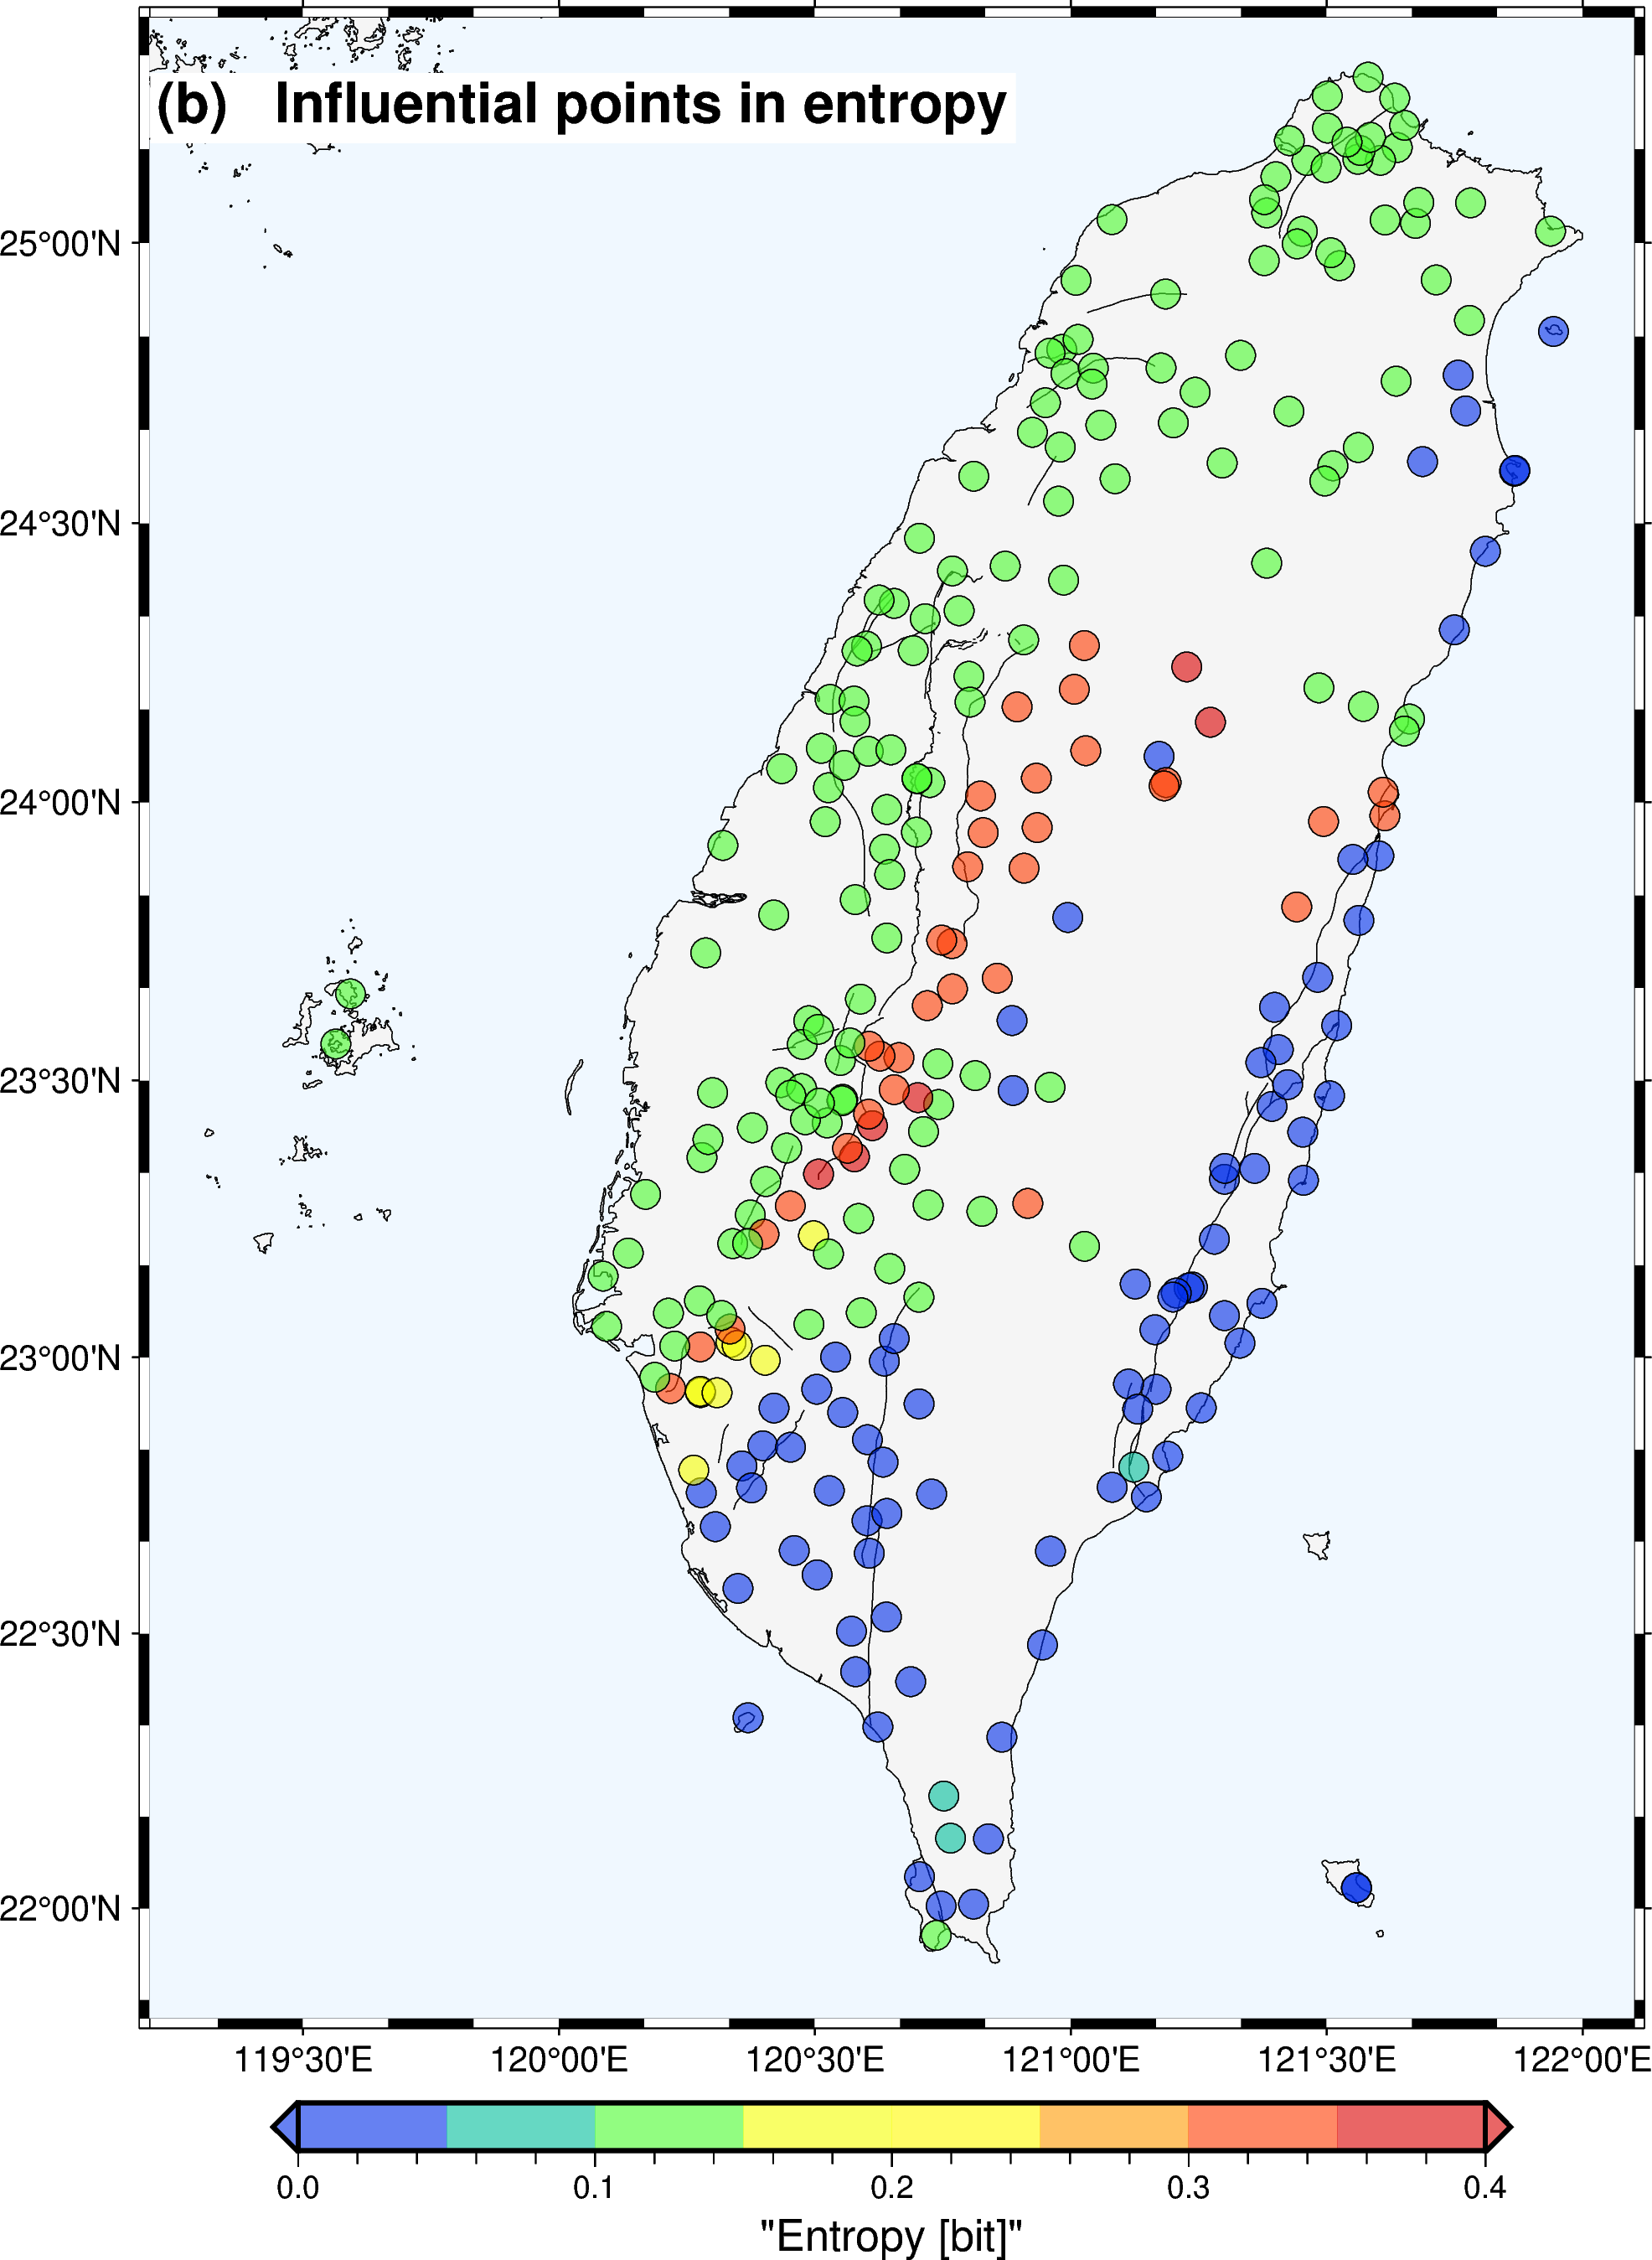

In [ ]:
fig = pygmt.Figure()
fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)
pygmt.makecpt(
    cmap='seis', reverse=True,
    series=[0, max(entropy_TW_stationwise), 0.05],
    background=True,
    continuous=False,
    transparency=40
)

for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )

for i in range(num_of_stations_Taiwan):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=Taiwan_vec["lon"][sorted_indices_byoriginalTW[i]],
        y=Taiwan_vec["lat"][sorted_indices_byoriginalTW[i]],
        style=size,
        pen="black",
        fill="+z",
        zvalue=entropy_TW_stationwise[i],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Entropy [bit]"'],
)

fig.text(text="   (b)   Influential points in entropy", x=120.0, y=25.25, font="16p,Helvetica-Bold,black",fill="white")

fig.show()

#fig.savefig(FILEPATH+"Entropy_new.pdf")

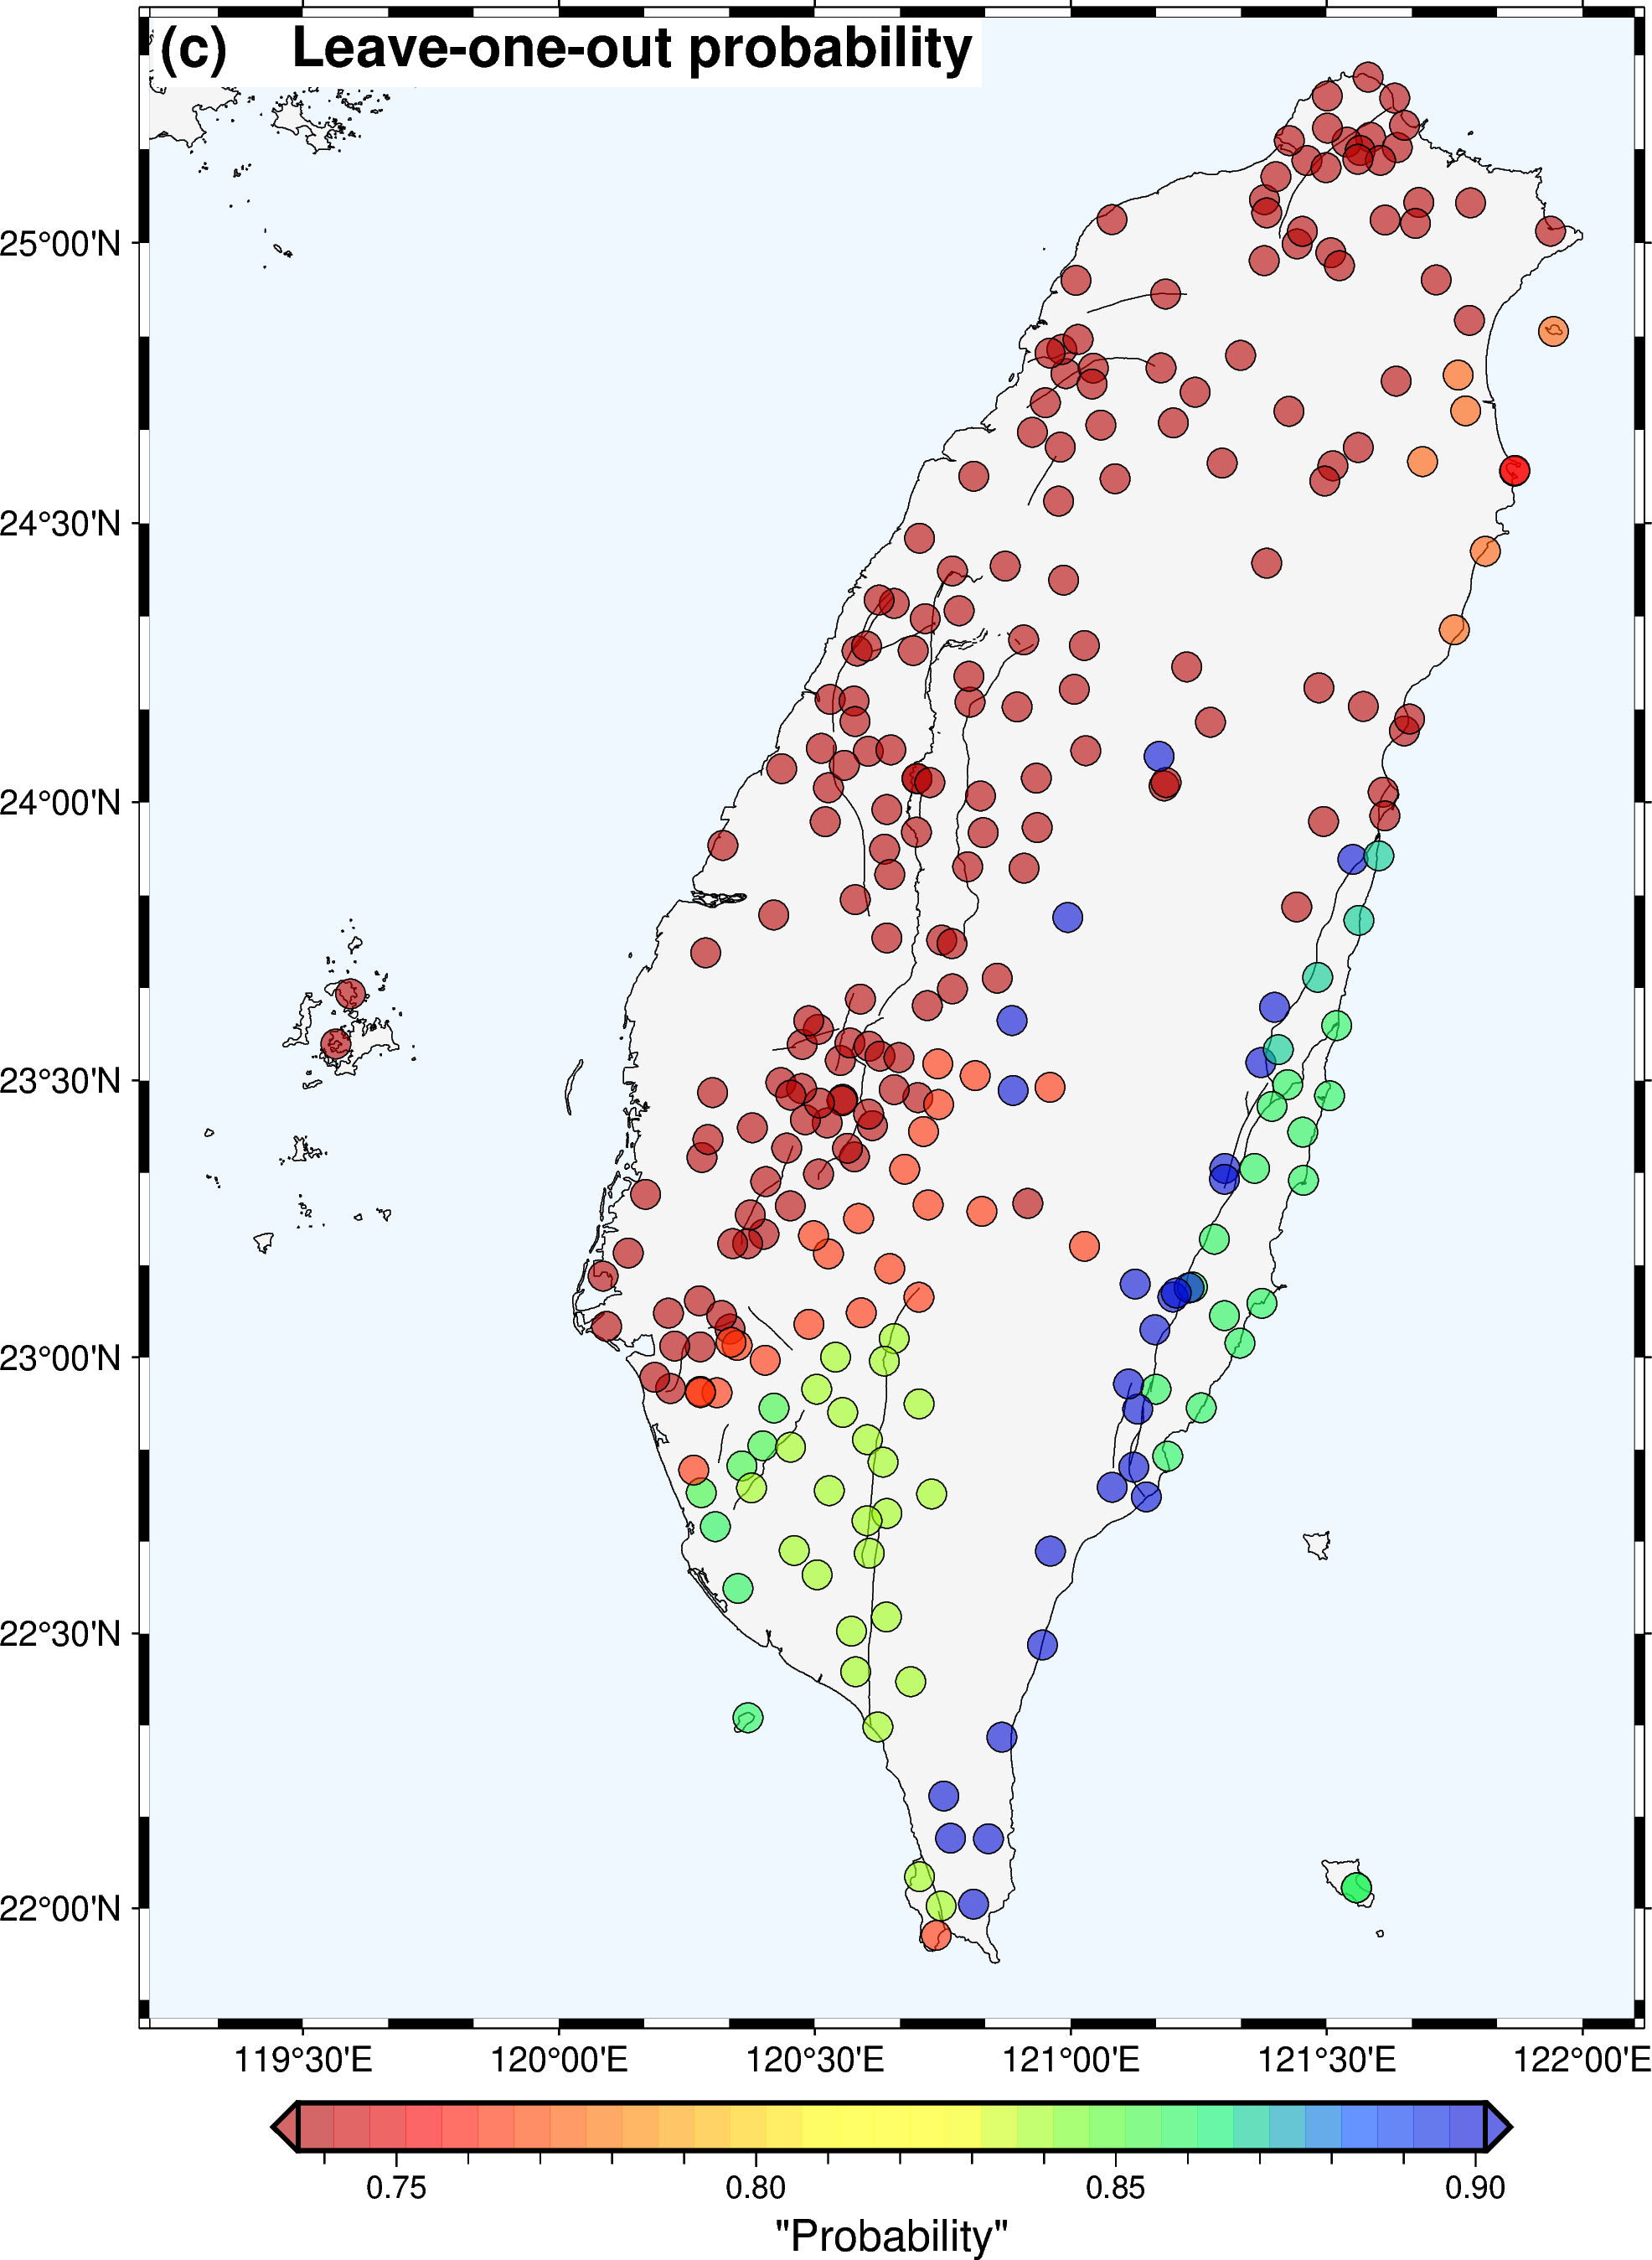

In [ ]:
fig = pygmt.Figure()

fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(cluster_K_Taiwan_loo_prob),max(cluster_K_Taiwan_loo_prob), 0.005],
    background=True,
    continuous=False,
    transparency=40
)

for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )

for i in range(num_of_stations_Taiwan):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=Taiwan_vec["lon"][i],
        y=Taiwan_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=cluster_K_Taiwan_loo_prob[clusters_K_original_TW[i]-1],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Probability"'],
)


fig.text(text=" (c)    Leave-one-out probability", x=120.0, y=25.35, font="16p,Helvetica-Bold,black",fill="white")

fig.show()


#fig.savefig(FILEPATH+"LOOP_new.pdf")

**Stability check with synthetic random perturbation**

In [ ]:
import multiprocessing

def pool2matrix(results, xsize,ysize):
  elements=np.array(results)
  upper_indices = np.triu_indices(xsize)

  matrix = np.zeros((xsize,ysize))
  matrix[upper_indices] = elements
  matrix.T[upper_indices] = elements
  return matrix

def compute_EVPT(args):
    vi, vj,alphaparams = args
    return combinedEVPTfit_distance(bundle_start=vi,bundle_end=vj,alpha=alphaparams)

def compute_PT(args):
    vi, vj = args
    return PTEuc_distance(bundle_start=vi,bundle_end=vj)

def compute_EV(args):
    vi, vj = args
    return EVfit_distance(bundle_start=vi,bundle_end=vj)

In [ ]:
distchange = "EVPT"
NJ_numsam = 200
parallel_option = "True"

NJ_data_list = []
for NJ_index in range(NJ_numsam):
  Taiwan_NJ_vec = Taiwan_vec.copy()

  Taiwan_NJ_vec["lon"]=Taiwan_vec["Lon"].astype(float)
  Taiwan_NJ_vec["lat"]=Taiwan_vec["Lat"].astype(float)

  Taiwan_NJ_vec["northward"]=Taiwan_vec["Vn_wrt_S01R"].astype(float)
  Taiwan_NJ_vec["eastward"]=Taiwan_vec["Ve_wrt_S01R"].astype(float)

  Taiwan_NJ_vec["x"]=0.
  Taiwan_NJ_vec["y"]=0.
  Taiwan_NJ_vec["z"]=0.
  Taiwan_NJ_vec["v_x"]=0.
  Taiwan_NJ_vec["v_y"]=0.
  Taiwan_NJ_vec["v_z"]=0.
  Taiwan_NJ_vec["KnownCluster"]="A"
  for i in range(num_of_stations_Taiwan):
    lat = Taiwan_vec["lat"][i]*(np.pi/180)
    lon = Taiwan_vec["lon"][i]*(np.pi/180)
    tangentrep = tangential_representation(lat,lon)
    x,y,z=tangentrep[0]
    e_vlat=tangentrep[1]
    e_vlon=tangentrep[2]
    vlat = 1.0*(Taiwan_vec["northward"][i]+np.random.normal(loc=0,scale=Taiwan_vec["sVn"][i]))* e_vlat
    vlon = 1.0*(Taiwan_vec["eastward"][i]+np.random.normal(loc=0,scale=Taiwan_vec["sVe"][i])) * e_vlon
    v = vlat+vlon

    Taiwan_NJ_vec.at[i,"x"]=x
    Taiwan_NJ_vec.at[i,"y"]=y
    Taiwan_NJ_vec.at[i,"z"]=z
    Taiwan_NJ_vec.at[i,"v_x"]=v[0]
    Taiwan_NJ_vec.at[i,"v_y"]=v[1]
    Taiwan_NJ_vec.at[i,"v_z"]=v[2]
    Taiwan_NJ_vec.at[i,"KnownCluster"]=Taiwan_vec.at[i,"ClusterLabelK11_Takahashietal2019"]


  bundle_array_Taiwan_NJ = np.array([(Taiwan_NJ_vec.loc[i,["x","y","z"]].astype(float),
                                  Taiwan_NJ_vec.loc[i,["v_x","v_y","v_z"]].astype(float)) for i in range(num_of_stations_Taiwan)])


  if parallel_option=="True":
    v_is = bundle_array_Taiwan_NJ
    v_js = bundle_array_Taiwan_NJ
    alpha_array = np.array([1.,1.])
    num_sites = num_of_stations_Taiwan
    if distchange=="EVPT":
      task = [(v_is[i], v_js[j], alpha_array) for i in range(num_sites) for j in range(i, num_sites)]
    elif distchange=="EV":
      task = [(v_is[i], v_js[j]) for i in range(num_sites) for j in range(i, num_sites)]
    elif distchange=="PT":
      task = [(v_is[i], v_js[j]) for i in range(num_sites) for j in range(i, num_sites)]

    with multiprocessing.Pool(processes=10) as pool:
      if distchange=="EVPT":
        results = pool.map(compute_EVPT, task)
      elif distchange=="EV":
        results = pool.map(compute_EV, task)
      elif distchange=="PT":
        results = pool.map(compute_PT, task)
    NJ_data_list.append(pool2matrix(results,num_sites,num_sites))

  else:
    if distchange=="EVPT":
      EVPTfit_distmat_Taiwan_NJ = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
      for i in range(num_of_stations_Taiwan):
        for j in range(i+1,num_of_stations_Taiwan):
          EVPTfit_distmat_Taiwan_NJ[i,j]=combinedEVPTfit_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j],alpha=np.array([1,1]))
          EVPTfit_distmat_Taiwan_NJ[j,i]=combinedEVPTfit_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j],alpha=np.array([1,1]))
      NJ_data_list.append(EVPTfit_distmat_Taiwan_NJ)
    elif distchange=="EV":
      EVfit_distmat_Taiwan_NJ = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
      for i in range(num_of_stations_Taiwan):
        for j in range(i+1,num_of_stations_Taiwan):
          EVfit_distmat_Taiwan_NJ[i,j]=EVfit_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j])
          EVfit_distmat_Taiwan_NJ[j,i]=EVfit_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j])
      NJ_data_list.append(EVfit_distmat_Taiwan_NJ)
    elif distchange=="PT":
      PTEuc_distmat_Taiwan_NJ = np.zeros(num_of_stations_Taiwan*num_of_stations_Taiwan).reshape((num_of_stations_Taiwan,num_of_stations_Taiwan))
      for i in range(num_of_stations_Taiwan):
        for j in range(i+1,num_of_stations_Taiwan):
          PTEuc_distmat_Taiwan_NJ[i,j]=PTEuc_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j])
          PTEuc_distmat_Taiwan_NJ[j,i]=PTEuc_distance(bundle_start=bundle_array_Taiwan_NJ[i],bundle_end=bundle_array_Taiwan_NJ[j])
      NJ_data_list.append(PTEuc_distmat_Taiwan_NJ)

In [ ]:
from itertools import combinations

K = 11
method = "average"

if distchange == "EVPT":
    clusters_K_original_TW = fcluster(clusters_Taiwan_EVPT, t=K, criterion='maxclust')
elif distchange == "EV":
    clusters_K_original_TW = fcluster(clusters_Taiwan_EV, t=K, criterion='maxclust')
elif distchange == "PT":
    clusters_K_original_TW = fcluster(clusters_Taiwan_PT, t=K, criterion='maxclust')

NJ_result = []

for NJ_index in range(NJ_numsam):
    pdistform_Taiwan_tmp = squareform(NJ_data_list[NJ_index])
    clusters_Taiwan_tmp = shc.linkage(pdistform_Taiwan_tmp, method=method)
    tmp = shc.fcluster(clusters_Taiwan_tmp, K, criterion='maxclust').tolist()
    NJ_result.append(np.array(tmp))


NJ_complete_probabilities = []
for NJ_index in range(NJ_numsam):
  NJ_complete_probabilities.append(np.array([(1. == sum(NJ_result[NJ_index][np.where(clusters_K_original_TW==k)[0]]/NJ_result[NJ_index][np.where(clusters_K_original_TW==k)[0]][0])/len(np.where(clusters_K_original_TW==k)[0]))
                                     for k in range(1,K+1)]))

cluster_K_Taiwan_NJ_complete_prob = np.nanmean(np.array(NJ_complete_probabilities),axis=0)


for k in range(1, K + 1):
    print(f"Confidence of Cluster {k} : {cluster_K_Taiwan_NJ_complete_prob[k-1]}")

NJ_adjusted_rand_score = []
for NJ_index in range(NJ_numsam):
  NJ_adjusted_rand_score.append(adjusted_rand_score(NJ_result[NJ_index],clusters_K_original_TW))

Confidence of Cluster 1 : 0.98
Confidence of Cluster 2 : 1.0
Confidence of Cluster 3 : 1.0
Confidence of Cluster 4 : 0.995
Confidence of Cluster 5 : 0.995
Confidence of Cluster 6 : 0.995
Confidence of Cluster 7 : 0.13
Confidence of Cluster 8 : 0.2
Confidence of Cluster 9 : 0.01
Confidence of Cluster 10 : 1.0
Confidence of Cluster 11 : 0.79


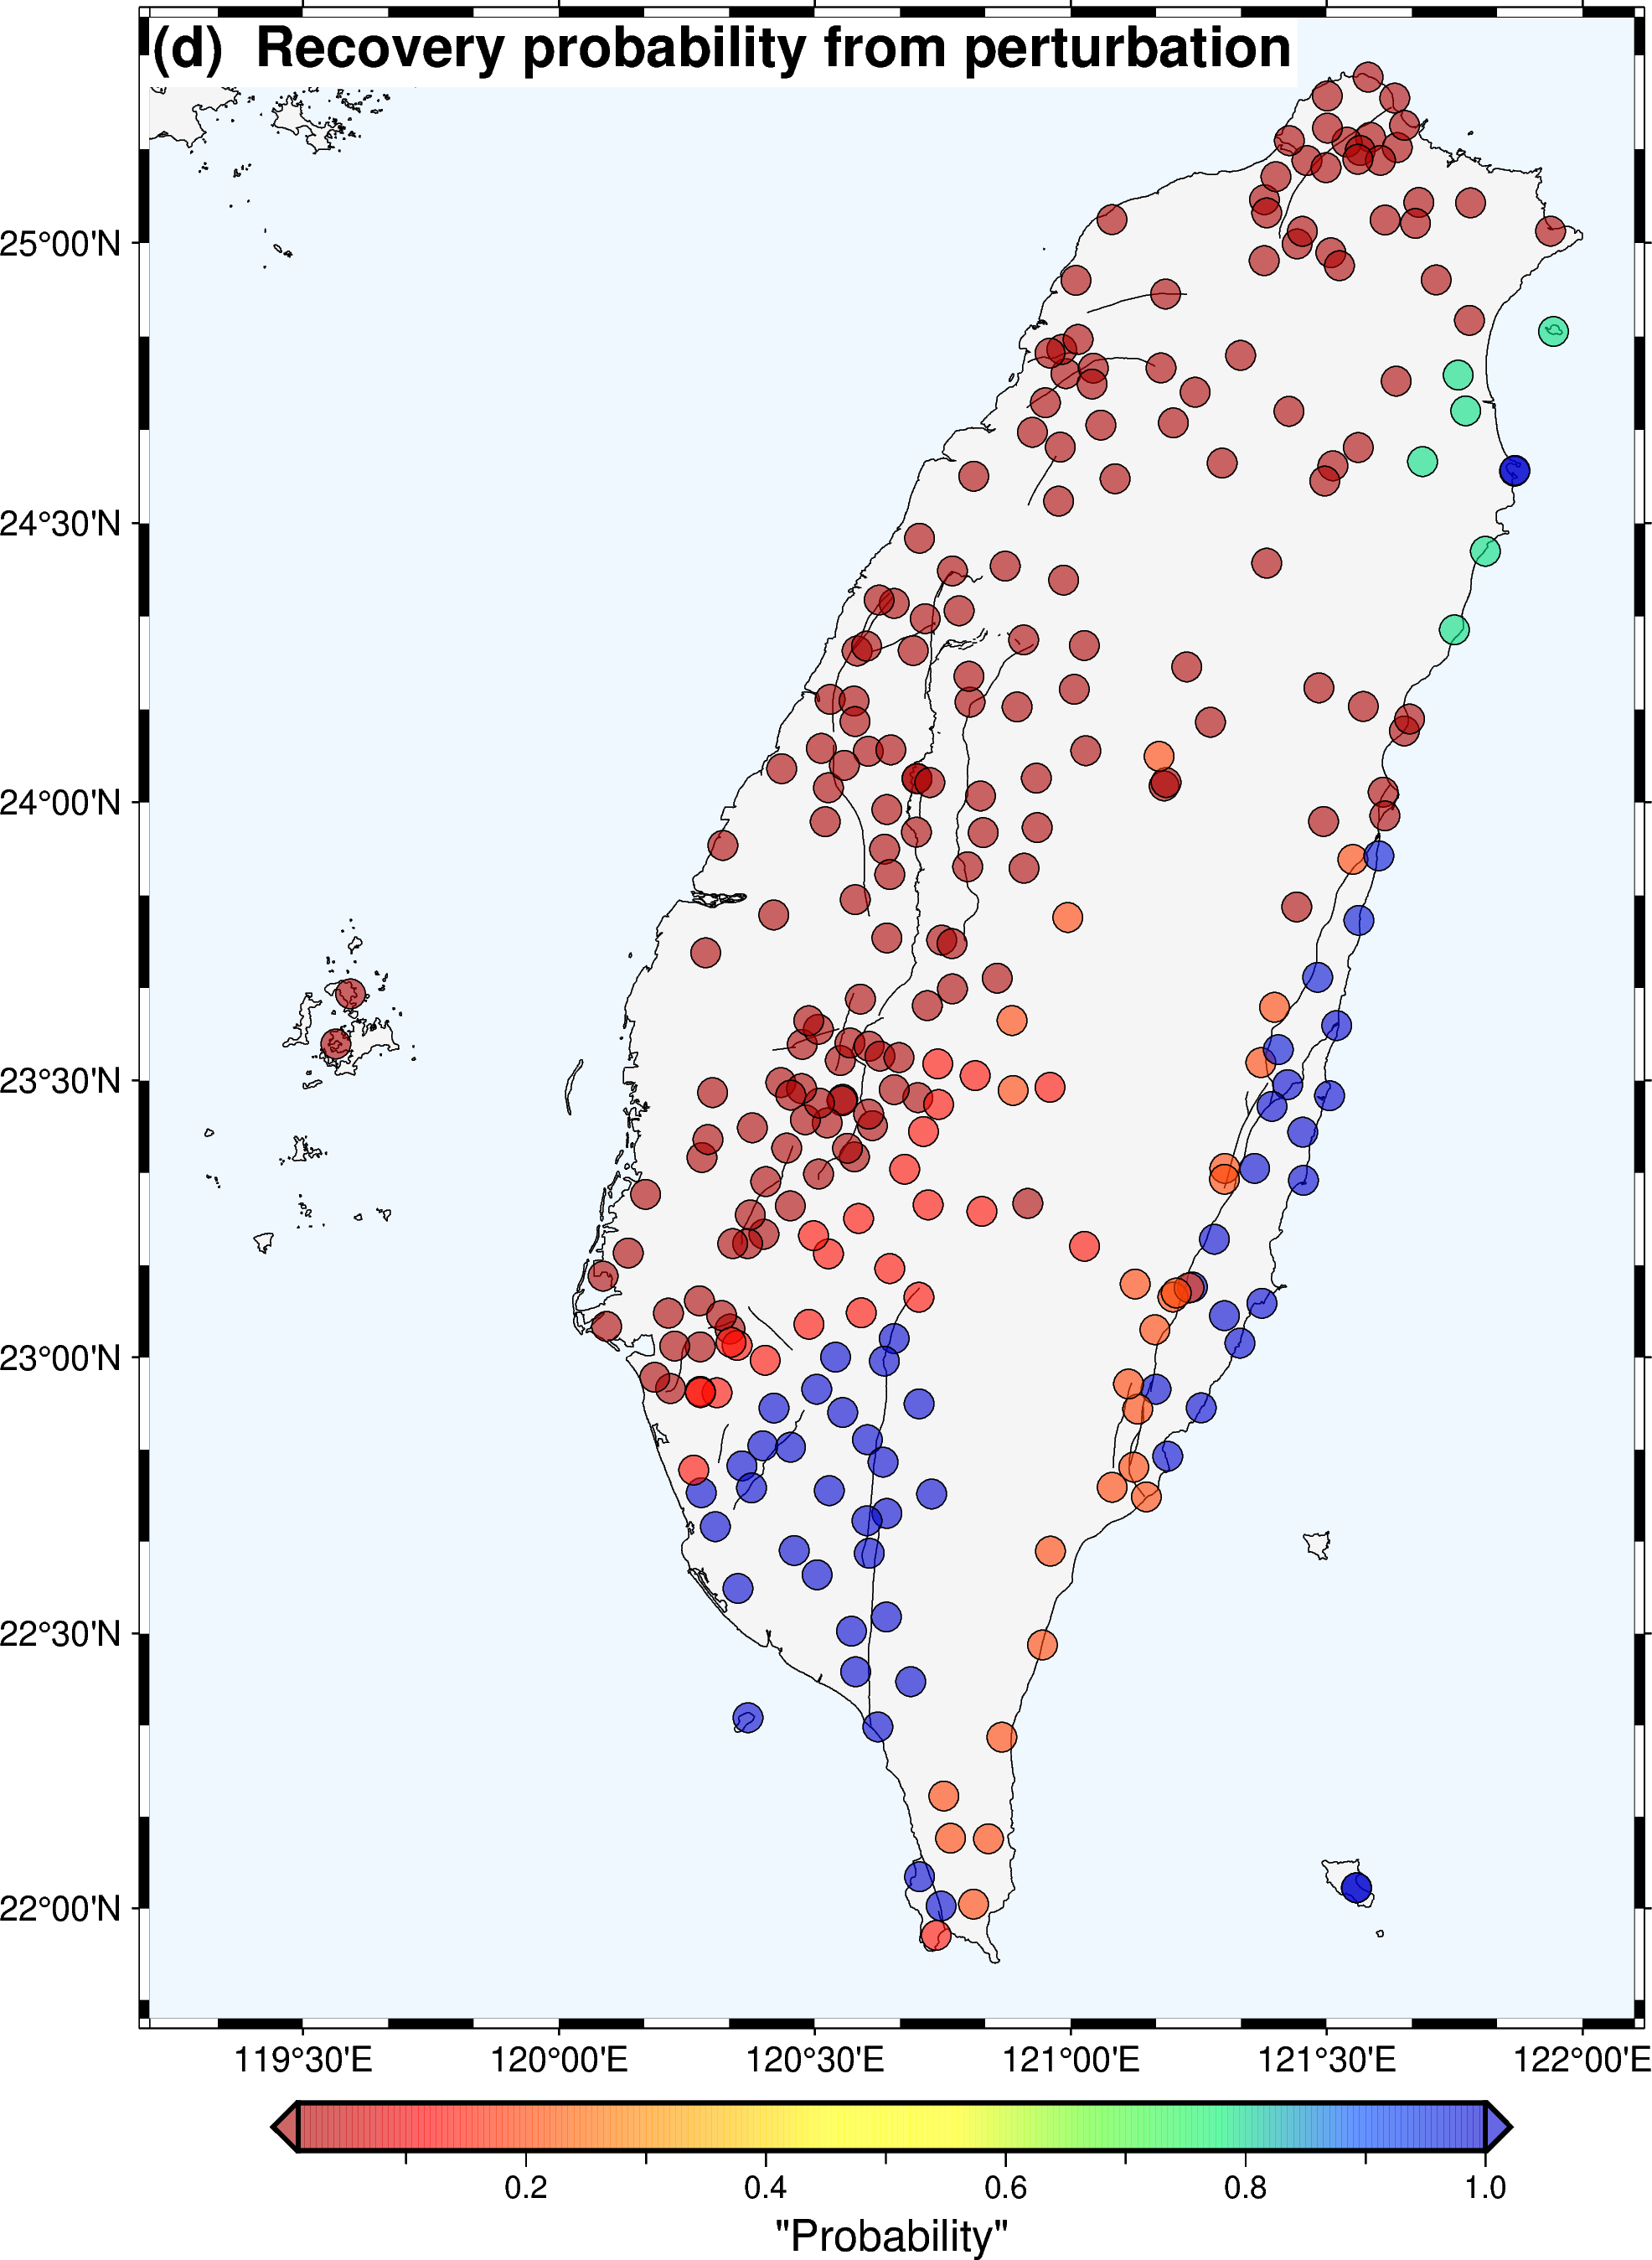

In [ ]:
fig = pygmt.Figure()

fig.basemap(
    region     = [119.2, 122.1, 21.8, 25.4],
    projection = 'M15c',
    frame=True,zsize=20
)
fig.coast(land="whitesmoke", water="aliceblue",
  shorelines=True)

pygmt.makecpt(
    cmap='seis',
    series=[min(cluster_K_Taiwan_NJ_complete_prob),max(cluster_K_Taiwan_NJ_complete_prob), 0.005],
    background=True,
    continuous=False,
    transparency=40
)

for item in c1_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )
for item in c2_afaults_srftrcs:
  item=np.array(item)
  fig.plot(
    x=item[:,0],
    y=item[:,1],
    pen="black"
  )

for i in range(num_of_stations_Taiwan):
    size = "c{:.2f}c".format(0.3)
    fig.plot(
        x=Taiwan_vec["lon"][i],
        y=Taiwan_vec["lat"][i],
        style=size,
        pen="black",
        fill="+z",
        zvalue=cluster_K_Taiwan_NJ_complete_prob[clusters_K_original_TW[i]-1],
        cmap=True
    )


fig.colorbar(
    position = '+e',
    frame    = ['x+l"Probability"'],
)


fig.text(text="                     (d)  Recovery probability from perturbation", x=120.0, y=25.35, font="16p,Helvetica-Bold,black",fill="white")

fig.show()
#fig.savefig(FILEPATH+"RP_P_new.pdf")


In [ ]:

def sorted_indices(arr):
    return np.argsort(arr)

sorted_indices_byoriginalTW = sorted_indices(clusters_K_original_TW)
Stability_tensor_Taiwan=np.array([(1.0*np.array([[NJ_result[k][sorted_indices_byoriginalTW][i]==NJ_result[k][sorted_indices_byoriginalTW][j]
                                                  for i in range(num_of_stations_Taiwan)] for j in range(num_of_stations_Taiwan)]))
                                    for k in range(NJ_numsam)])
Rij_NJ_Taiwan=Stability_tensor_Taiwan.mean(axis=0)

Text(0.5, 1.0, 'Relation matrix for Taiwan data')

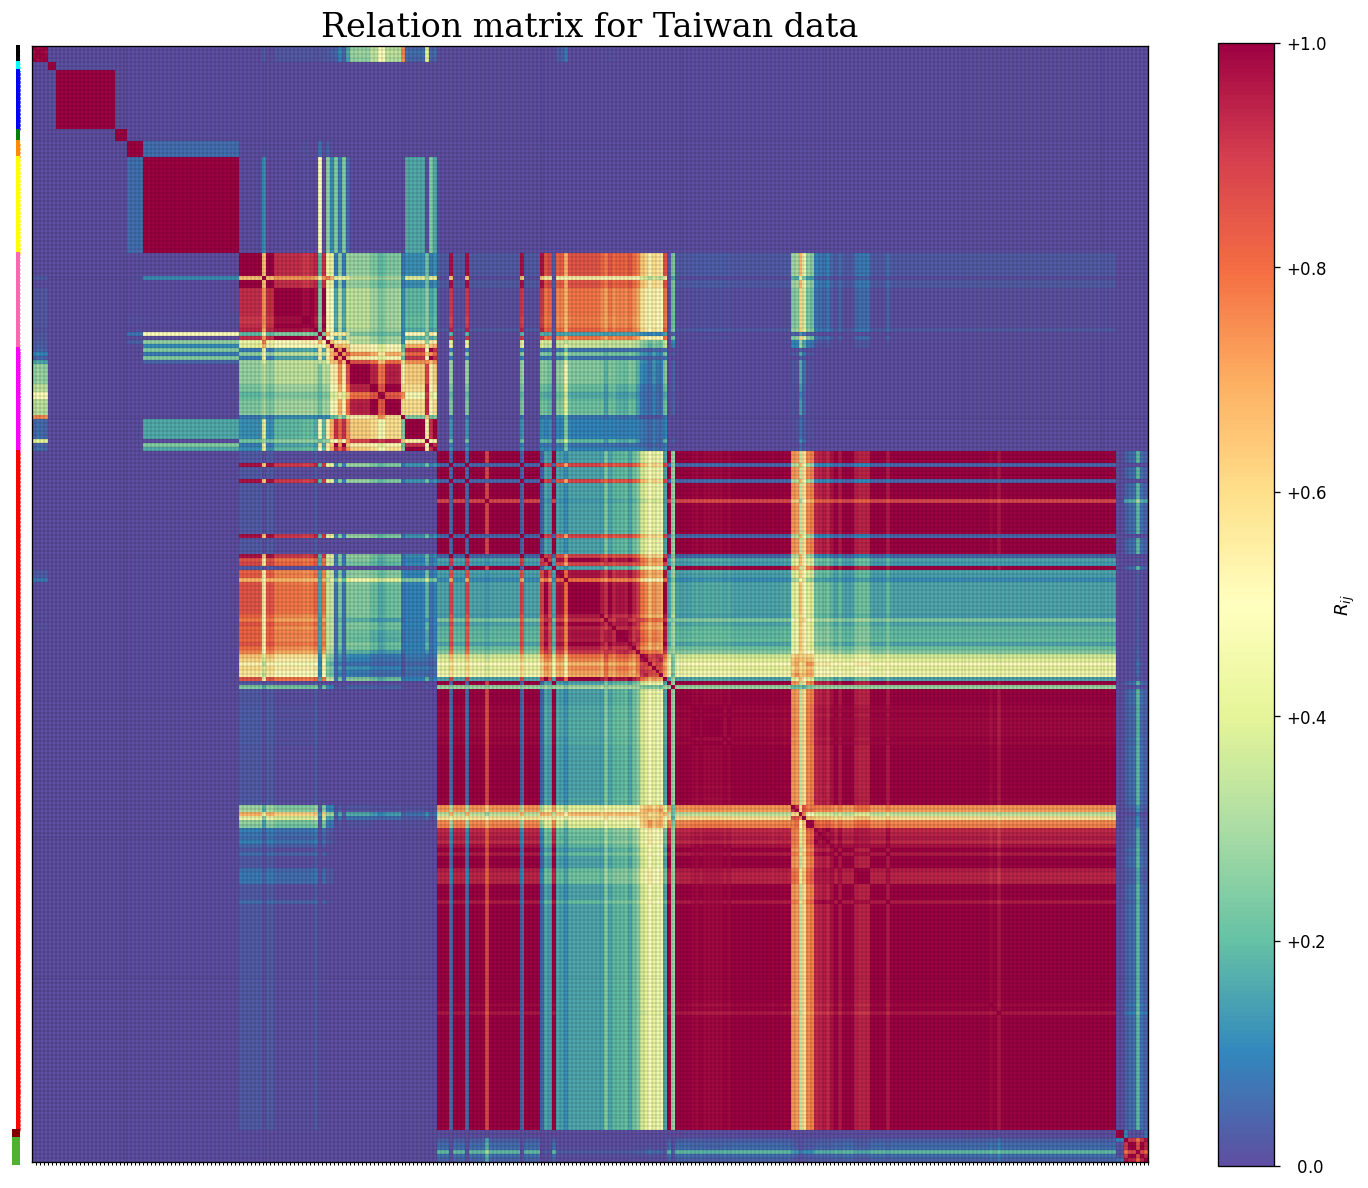

In [ ]:

scaling = Rij_NJ_Taiwan


fig, ax = plt.subplots(figsize=(15,15),dpi=120)

cl = list()
cl.append( ( 0.00,  matplotlib.colors.hsv_to_rgb((0.0, 0.  ,1))) )
cl.append( ( 0.50,  matplotlib.colors.hsv_to_rgb((0.6, 0.1 ,1))) )
cl.append( ( 1.00,  matplotlib.colors.hsv_to_rgb((0.6, 1.  ,1))))
ccm = matplotlib.colors.LinearSegmentedColormap.from_list('custom_cmap', cl)
plt.imshow(scaling ,interpolation='nearest',vmin=0,vmax=1,cmap="Spectral_r")

plt.gca().set_xticks([])
plt.gca().set_xticklabels([])
plt.gca().set_yticks(range(num_of_stations_Taiwan))
plt.gca().set_yticklabels(clusters_K_original_TW[sorted_indices_byoriginalTW],fontsize=4)

plt.tick_params(axis='both', which='both', top=False, left=False )
fmt = lambda p, pos=None : f'${p:+.1f}$' if p!=0 else '  $0.0$'
cb = plt.colorbar(format=ticker.FuncFormatter(fmt),shrink=0.81)
cb.set_label(""+r"$R_{ij}$", fontsize=11)



for t in ax.get_yticklabels():
    txt = t.get_text()
    t.set_color(colorlist_tw_11[int(txt)-1])
    t.set_bbox(dict(facecolor=colorlist_tw_11[int(txt)-1],
                    boxstyle='square,pad=0.0', edgecolor='none', alpha=1.0))


plt.grid(True, which='both', color='black', linewidth=0.0, linestyle='-')
plt.gca().set_xticks(np.arange(scaling.shape[1])+0.5 , minor=True)
plt.gca().set_yticks(np.arange(scaling.shape[0])+0.5 , minor=True)
plt.gca().grid(True, which='minor', color='black', linewidth=0.1, linestyle='-')

plt.title("Relation matrix for Taiwan data",fontsize=20)